# Customer Segmentation using Clustering
***
This mini-project is based on [this blog post](http://blog.yhat.com/posts/customer-segmentation-using-python.html) by yhat. Please feel free to refer to the post for additional information, and solutions.

In [1]:
%matplotlib inline
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns

# Setup Seaborn
sns.set_style("whitegrid")
sns.set_context("poster")

## Data

The dataset contains information on marketing newsletters/e-mail campaigns (e-mail offers sent to customers) and transaction level data from customers. The transactional data shows which offer customers responded to, and what the customer ended up buying. The data is presented as an Excel workbook containing two worksheets. Each worksheet contains a different dataset.

In [2]:
df_offers = pd.read_excel("./WineKMC.xlsx", sheet_name=0)
df_offers.columns = ["offer_id", "campaign", "varietal", "min_qty", "discount", "origin", "past_peak"]
df_offers.head()

offer_id  campaign            varietal  min_qty  discount       origin  \
0         1   January              Malbec       72        56       France   
1         2   January          Pinot Noir       72        17       France   
2         3  February           Espumante      144        32       Oregon   
3         4  February           Champagne       72        48       France   
4         5  February  Cabernet Sauvignon      144        44  New Zealand   

   past_peak  
0      False  
1      False  
2       True  
3       True  
4       True

We see that the first dataset contains information about each offer such as the month it is in effect and several attributes about the wine that the offer refers to: the variety, minimum quantity, discount, country of origin and whether or not it is past peak. The second dataset in the second worksheet contains transactional data -- which offer each customer responded to.

In [3]:
df_transactions = pd.read_excel("./WineKMC.xlsx", sheet_name=1)
df_transactions.columns = ["customer_name", "offer_id"]
df_transactions['n'] = 1
df_transactions.head()

customer_name  offer_id  n
0         Smith         2  1
1         Smith        24  1
2       Johnson        17  1
3       Johnson        24  1
4       Johnson        26  1

## Data wrangling

We're trying to learn more about how our customers behave, so we can use their behavior (whether or not they purchased something based on an offer) as a way to group similar minded customers together. We can then study those groups to look for patterns and trends which can help us formulate future offers.

The first thing we need is a way to compare customers. To do this, we're going to create a matrix that contains each customer and a 0/1 indicator for whether or not they responded to a given offer. 

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set I</h3>

<p><b>Exercise:</b> Create a data frame where each row has the following columns (Use the pandas [`merge`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.merge.html) and [`pivot_table`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.pivot_table.html) functions for this purpose):
<ul>
<li> customer_name
<li> One column for each offer, with a 1 if the customer responded to the offer
</ul>
<p>Make sure you also deal with any weird values such as `NaN`. Read the documentation to develop your solution.</p>
</div>

In [5]:
#your turn


In [6]:
merged_df = pd.merge(df_transactions,df_offers)

In [7]:
merged_df.head()

customer_name  offer_id  n campaign    varietal  min_qty  discount  origin  \
0         Smith         2  1  January  Pinot Noir       72        17  France   
1     Rodriguez         2  1  January  Pinot Noir       72        17  France   
2        Martin         2  1  January  Pinot Noir       72        17  France   
3       Jackson         2  1  January  Pinot Noir       72        17  France   
4      Campbell         2  1  January  Pinot Noir       72        17  France   

   past_peak  
0      False  
1      False  
2      False  
3      False  
4      False

In [8]:
pivot_df = pd.pivot_table(merged_df,index=['customer_name'],columns=['offer_id','campaign','varietal'],values=['n'])

In [9]:
print(pivot_df)

                    n                                                    \
offer_id           1          2         3         4                  5    
campaign      January    January  February  February           February   
varietal       Malbec Pinot Noir Espumante Champagne Cabernet Sauvignon   
customer_name                                                             
Adams             NaN        NaN       NaN       NaN                NaN   
Allen             NaN        NaN       NaN       NaN                NaN   
Anderson          NaN        NaN       NaN       NaN                NaN   
Bailey            NaN        NaN       NaN       NaN                NaN   
Baker             NaN        NaN       NaN       NaN                NaN   
...               ...        ...       ...       ...                ...   
Williams          NaN        NaN       NaN       NaN                NaN   
Wilson            NaN        NaN       NaN       NaN                NaN   
Wood              1.0    

In [10]:
pivot_df = pivot_df.fillna(0).reset_index()

In [11]:
print(pivot_df)

         customer_name       n                                 \
offer_id                     1          2         3         4   
campaign               January    January  February  February   
varietal                Malbec Pinot Noir Espumante Champagne   
0                Adams     0.0        0.0       0.0       0.0   
1                Allen     0.0        0.0       0.0       0.0   
2             Anderson     0.0        0.0       0.0       0.0   
3               Bailey     0.0        0.0       0.0       0.0   
4                Baker     0.0        0.0       0.0       0.0   
..                 ...     ...        ...       ...       ...   
95            Williams     0.0        0.0       0.0       0.0   
96              Wilson     0.0        0.0       0.0       0.0   
97                Wood     1.0        0.0       0.0       0.0   
98              Wright     0.0        0.0       0.0       1.0   
99               Young     0.0        0.0       0.0       0.0   

                        

## K-Means Clustering

Recall that in K-Means Clustering we want to *maximize* the distance between centroids and *minimize* the distance between data points and the respective centroid for the cluster they are in. True evaluation for unsupervised learning would require labeled data; however, we can use a variety of intuitive metrics to try to pick the number of clusters K. We will introduce two methods: the Elbow method, the Silhouette method and the gap statistic.

### Choosing K: The Elbow Sum-of-Squares Method

The first method looks at the sum-of-squares error in each cluster against $K$. We compute the distance from each data point to the center of the cluster (centroid) to which the data point was assigned. 

$$SS = \sum_k \sum_{x_i \in C_k} \sum_{x_j \in C_k} \left( x_i - x_j \right)^2 = \sum_k \sum_{x_i \in C_k} \left( x_i - \mu_k \right)^2$$

where $x_i$ is a point, $C_k$ represents cluster $k$ and $\mu_k$ is the centroid for cluster $k$. We can plot SS vs. $K$ and choose the *elbow point* in the plot as the best value for $K$. The elbow point is the point at which the plot starts descending much more slowly. 

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set II</h3>

<p><b>Exercise:</b></p> 
<ul>
<li> What values of $SS$ do you believe represent better clusterings? Why?
<li> Create a numpy matrix `x_cols` with only the columns representing the offers (i.e. the 0/1 colums) 
<li> Write code that applies the [`KMeans`](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) clustering method from scikit-learn to this matrix. 
<li> Construct a plot showing $SS$ for each $K$ and pick $K$ using this plot. For simplicity, test $2 \le K \le 10$.
<li> Make a bar chart showing the number of points in each cluster for k-means under the best $K$.
<li> What challenges did you experience using the Elbow method to pick $K$?
</ul>
</div>

In [12]:
# your turn


Smaller values of SS represent better clusterings, as data points are near the centroid of their corresponding cluster. 

In [13]:
import numpy as np

In [14]:
pivot_df.columns

MultiIndex([('customer_name', '',          '',                   ''),
            (            'n',  1,   'January',             'Malbec'),
            (            'n',  2,   'January',         'Pinot Noir'),
            (            'n',  3,  'February',          'Espumante'),
            (            'n',  4,  'February',          'Champagne'),
            (            'n',  5,  'February', 'Cabernet Sauvignon'),
            (            'n',  6,     'March',           'Prosecco'),
            (            'n',  7,     'March',           'Prosecco'),
            (            'n',  8,     'March',          'Espumante'),
            (            'n',  9,     'April',         'Chardonnay'),
            (            'n', 10,     'April',           'Prosecco'),
            (            'n', 11,       'May',          'Champagne'),
            (            'n', 12,       'May',           'Prosecco'),
            (            'n', 13,       'May',             'Merlot'),
            (       

In [15]:
km_df = pivot_df.drop(pivot_df.columns[0],axis=1)

In [16]:
print(km_df)

               n                                                             \
offer_id      1          2         3         4                  5        6    
campaign January    January  February  February           February    March   
varietal  Malbec Pinot Noir Espumante Champagne Cabernet Sauvignon Prosecco   
0            0.0        0.0       0.0       0.0                0.0      0.0   
1            0.0        0.0       0.0       0.0                0.0      0.0   
2            0.0        0.0       0.0       0.0                0.0      0.0   
3            0.0        0.0       0.0       0.0                0.0      0.0   
4            0.0        0.0       0.0       0.0                0.0      0.0   
..           ...        ...       ...       ...                ...      ...   
95           0.0        0.0       0.0       0.0                0.0      0.0   
96           0.0        0.0       0.0       0.0                0.0      0.0   
97           1.0        0.0       0.0       0.0     

In [17]:
x_cols = np.array(km_df)

In [18]:
print(x_cols)

[[0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [1. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 1. 1.]]


In [19]:
from sklearn.cluster import KMeans

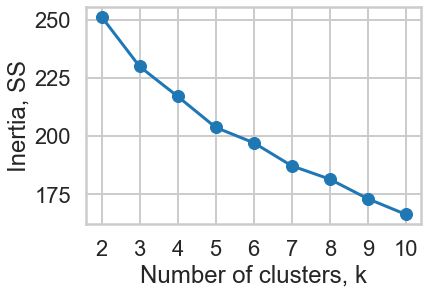

In [20]:
ks = range(2, 11)
inertias = []


for k in ks:
    # Create a KMeans instances
    model = KMeans(n_clusters=k)
    # Fit model to samples
    model.fit(x_cols)
    # Append the inertia to the list of inertias, i.e. SS
    inertias.append(model.inertia_)

    
# Plot ks vs inertias
plt.plot(ks, inertias, '-o')
plt.xlabel('Number of clusters, k')
plt.ylabel('Inertia, SS')
plt.xticks(ks)
plt.show()


For this dataset, the "elbow" is not clear, thus there is no obvious choice of k. The best k chosen is 5.

In [21]:
Km5 = KMeans(n_clusters=5)
km_labels = Km5.fit_predict(x_cols)

In [22]:
km5_df = pd.DataFrame({'Customer':pivot_df['customer_name'],'KMeans_cluster':km_labels})

In [23]:
print(km5_df)

    Customer  KMeans_cluster
0      Adams               1
1      Allen               4
2   Anderson               3
3     Bailey               1
4      Baker               4
..       ...             ...
95  Williams               4
96    Wilson               1
97      Wood               4
98    Wright               4
99     Young               4

[100 rows x 2 columns]


In [24]:
km5_ct = km5_df.groupby('KMeans_cluster').size().reset_index(name='Count')
print(km5_ct)

   KMeans_cluster  Count
0               0      7
1               1     33
2               2     20
3               3     16
4               4     24


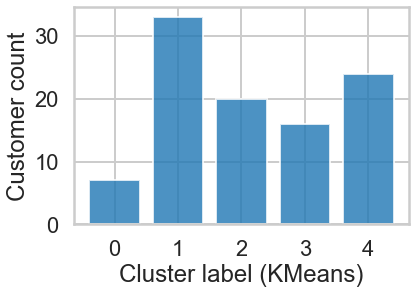

In [25]:
# Plot ks vs inertias
plt.bar(km5_ct['KMeans_cluster'], km5_ct['Count'], align='center', alpha=0.8)
plt.xlabel('Cluster label (KMeans)')
plt.ylabel('Customer count')
plt.xticks(km5_ct['KMeans_cluster'])
plt.show()

### Choosing K: The Silhouette Method

There exists another method that measures how well each datapoint $x_i$ "fits" its assigned cluster *and also* how poorly it fits into other clusters. This is a different way of looking at the same objective. Denote $a_{x_i}$ as the *average* distance from $x_i$ to all other points within its own cluster $k$. The lower the value, the better. On the other hand $b_{x_i}$ is the minimum average distance from $x_i$ to points in a different cluster, minimized over clusters. That is, compute separately for each cluster the average distance from $x_i$ to the points within that cluster, and then take the minimum. The silhouette $s(x_i)$ is defined as

$$s(x_i) = \frac{b_{x_i} - a_{x_i}}{\max{\left( a_{x_i}, b_{x_i}\right)}}$$

The silhouette score is computed on *every datapoint in every cluster*. The silhouette score ranges from -1 (a poor clustering) to +1 (a very dense clustering) with 0 denoting the situation where clusters overlap. Some criteria for the silhouette coefficient is provided in the table below.

<pre>

| Range       | Interpretation                                |
|-------------|-----------------------------------------------|
| 0.71 - 1.0  | A strong structure has been found.            |
| 0.51 - 0.7  | A reasonable structure has been found.        |
| 0.26 - 0.5  | The structure is weak and could be artificial.|
| < 0.25      | No substantial structure has been found.      |

</pre>
Source: http://www.stat.berkeley.edu/~spector/s133/Clus.html

Fortunately, scikit-learn provides a function to compute this for us (phew!) called [`sklearn.metrics.silhouette_score`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html). Take a look at [this article](http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html) on picking $K$ in scikit-learn, as it will help you in the next exercise set.

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set III</h3>

<p><b>Exercise:</b> Using the documentation for the `silhouette_score` function above, construct a series of silhouette plots like the ones in the article linked above.</p>

<p><b>Exercise:</b> Compute the average silhouette score for each $K$ and plot it. What $K$ does the plot suggest we should choose? Does it differ from what we found using the Elbow method?</p>
</div>

In [26]:
# Your turn.


In [27]:
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm

For n_clusters = 2 The average silhouette_score is : 0.08206113079944462
For n_clusters = 3 The average silhouette_score is : 0.10559256273408764
For n_clusters = 4 The average silhouette_score is : 0.1292771407624089
For n_clusters = 5 The average silhouette_score is : 0.1233444888825575
For n_clusters = 6 The average silhouette_score is : 0.12280066125744576
For n_clusters = 7 The average silhouette_score is : 0.12399416308802139
For n_clusters = 8 The average silhouette_score is : 0.10691495275188886
For n_clusters = 9 The average silhouette_score is : 0.13775637114367068
For n_clusters = 10 The average silhouette_score is : 0.1312568654907899


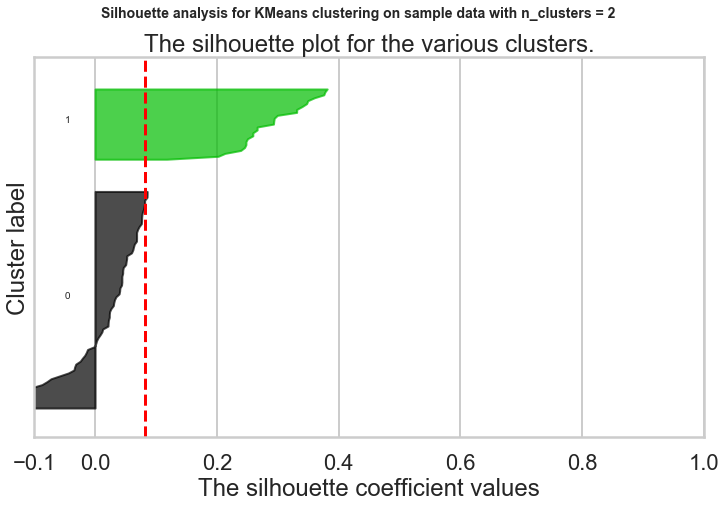

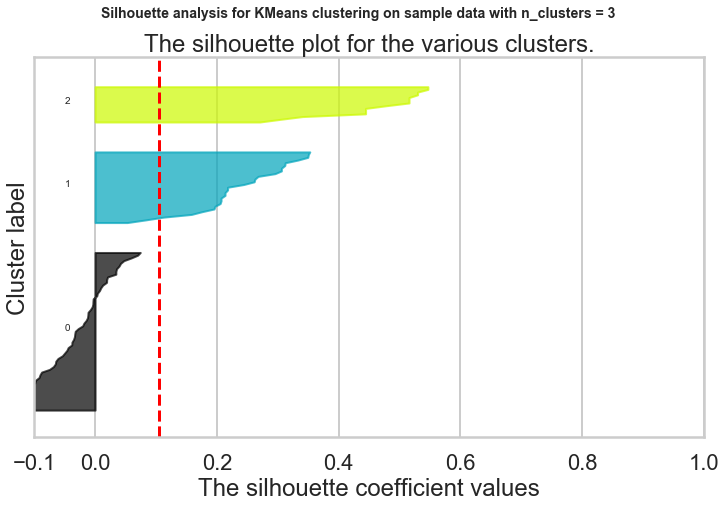

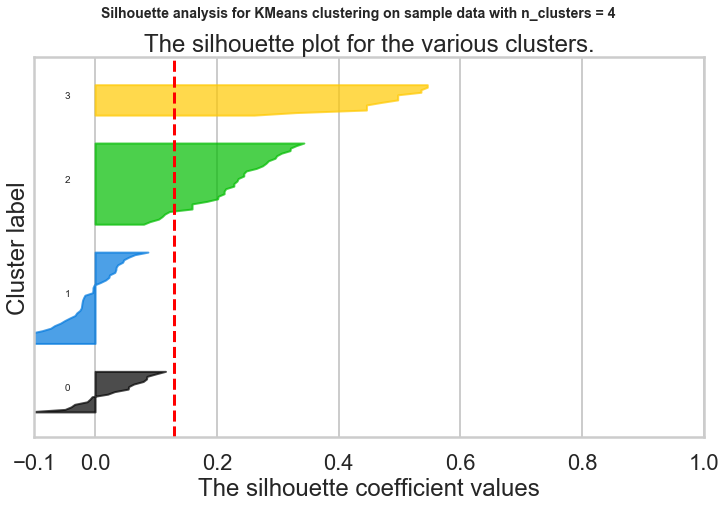

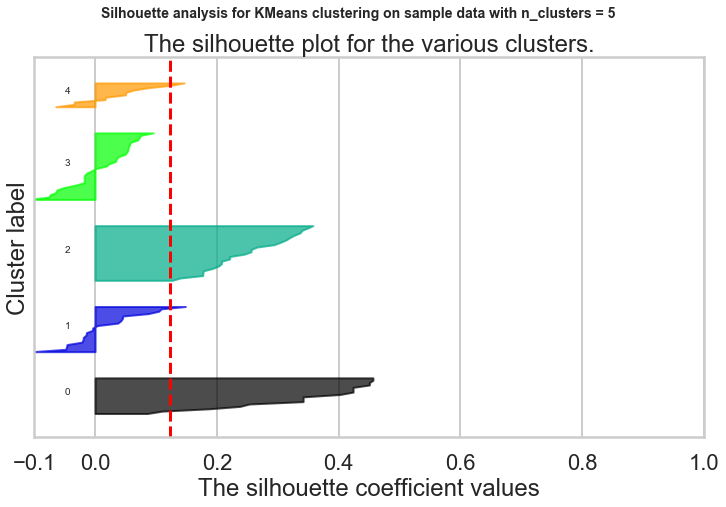

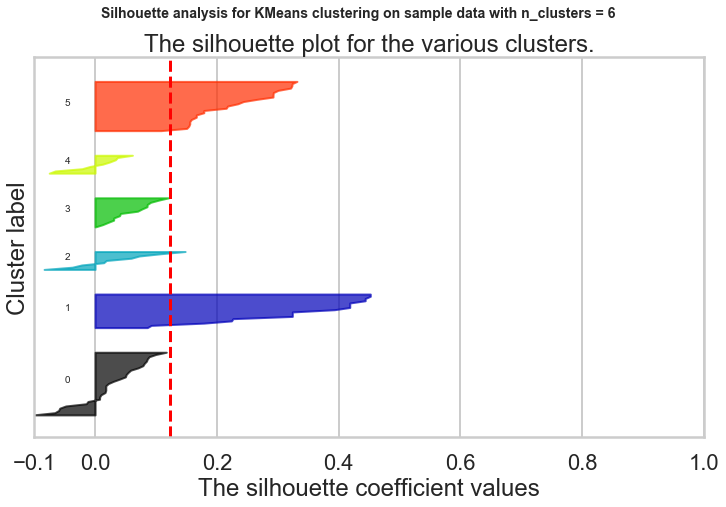

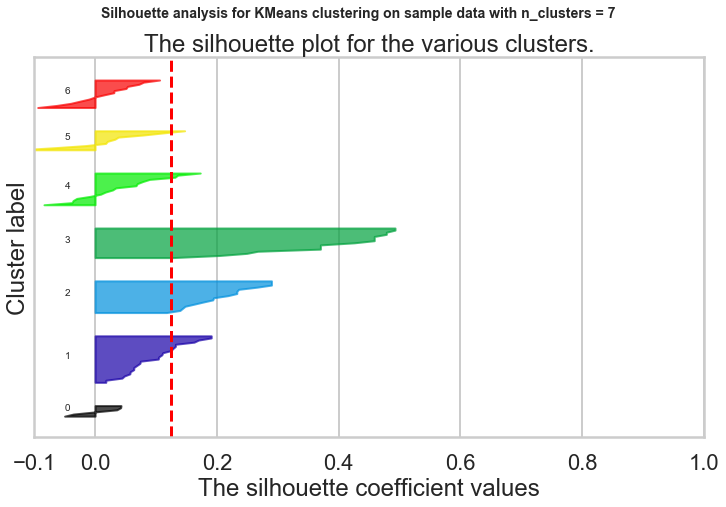

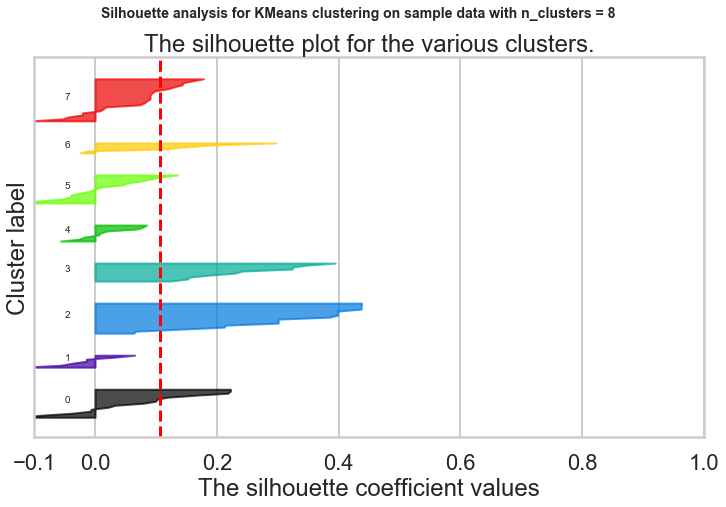

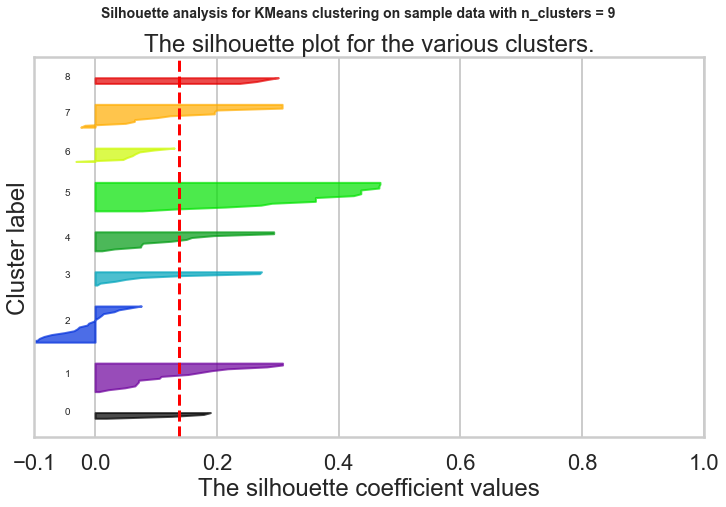

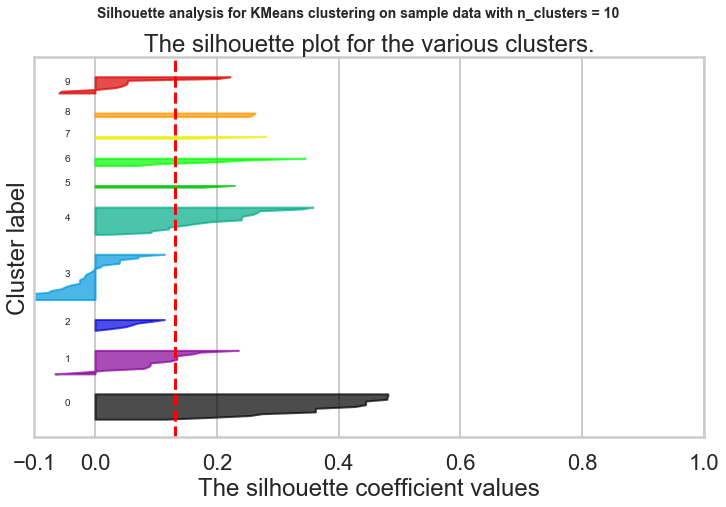

In [30]:
range_n_clusters = np.arange(2,11)
avg_silhouette_score = []

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1) = plt.subplots(1, 1)
    fig.set_size_inches(12, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(x_cols) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    #clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    clusterer = KMeans(n_clusters=n_clusters)
    cluster_labels = clusterer.fit_predict(x_cols)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(x_cols, cluster_labels)
    avg_silhouette_score.append(silhouette_avg)
    
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(x_cols, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()

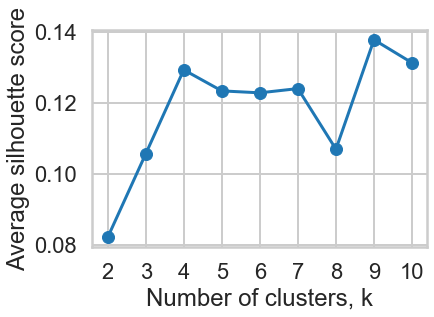

In [31]:
plt.plot(range_n_clusters, avg_silhouette_score, '-o')
plt.xlabel('Number of clusters, k')
plt.ylabel('Average silhouette score')
plt.xticks(range_n_clusters)
plt.show()

The average silhouette scores for up to 10 clusters are all below 0.25. The best silhouette score is 0.138 with k=9. However, similar to the elbow method, the results do not reflect a clear choice for an optimal value of k.

### Choosing $K$: The Gap Statistic

There is one last method worth covering for picking $K$, the so-called Gap statistic. The computation for the gap statistic builds on the sum-of-squares established in the Elbow method discussion, and compares it to the sum-of-squares of a "null distribution," that is, a random set of points with no clustering. The estimate for the optimal number of clusters $K$ is the value for which $\log{SS}$ falls the farthest below that of the reference distribution:

$$G_k = E_n^*\{\log SS_k\} - \log SS_k$$

In other words a good clustering yields a much larger difference between the reference distribution and the clustered data. The reference distribution is a Monte Carlo (randomization) procedure that constructs $B$ random distributions of points within the bounding box (limits) of the original data and then applies K-means to this synthetic distribution of data points.. $E_n^*\{\log SS_k\}$ is just the average $SS_k$ over all $B$ replicates. We then compute the standard deviation $\sigma_{SS}$ of the values of $SS_k$ computed from the $B$ replicates of the reference distribution and compute

$$s_k = \sqrt{1+1/B}\sigma_{SS}$$

Finally, we choose $K=k$ such that $G_k \geq G_{k+1} - s_{k+1}$.

### Aside: Choosing $K$ when we Have Labels

Unsupervised learning expects that we do not have the labels. In some situations, we may wish to cluster data that is labeled. Computing the optimal number of clusters is much easier if we have access to labels. There are several methods available. We will not go into the math or details since it is rare to have access to the labels, but we provide the names and references of these measures.

* Adjusted Rand Index
* Mutual Information
* V-Measure
* Fowlkes–Mallows index

See [this article](http://scikit-learn.org/stable/modules/clustering.html) for more information about these metrics.

## Visualizing Clusters using PCA

How do we visualize clusters? If we only had two features, we could likely plot the data as is. But we have 100 data points each containing 32 features (dimensions). Principal Component Analysis (PCA) will help us reduce the dimensionality of our data from 32 to something lower. For a visualization on the coordinate plane, we will use 2 dimensions. In this exercise, we're going to use it to transform our multi-dimensional dataset into a 2 dimensional dataset.

This is only one use of PCA for dimension reduction. We can also use PCA when we want to perform regression but we have a set of highly correlated variables. PCA untangles these correlations into a smaller number of features/predictors all of which are orthogonal (not correlated). PCA is also used to reduce a large set of variables into a much smaller one.

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set IV</h3>

<p><b>Exercise:</b> Use PCA to plot your clusters:</p>

<ul>
<li> Use scikit-learn's [`PCA`](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) function to reduce the dimensionality of your clustering data to 2 components
<li> Create a data frame with the following fields:
  <ul>
  <li> customer name
  <li> cluster id the customer belongs to
  <li> the two PCA components (label them `x` and `y`)
  </ul>
<li> Plot a scatterplot of the `x` vs `y` columns
<li> Color-code points differently based on cluster ID
<li> How do the clusters look? 
<li> Based on what you see, what seems to be the best value for $K$? Moreover, which method of choosing $K$ seems to have produced the optimal result visually?
</ul>

<p><b>Exercise:</b> Now look at both the original raw data about the offers and transactions and look at the fitted clusters. Tell a story about the clusters in context of the original data. For example, do the clusters correspond to wine variants or something else interesting?</p>
</div>

In [32]:
#your turn


In [33]:
#Kmeans with n_clusters = 9 based on average silhouette score
Km9 = KMeans(n_clusters=7)
km9_labels = Km9.fit_predict(x_cols)
km9_df = pd.DataFrame({'Customer':pivot_df['customer_name'],'KMeans_cluster':km9_labels})

In [34]:
print(km9_df)

    Customer  KMeans_cluster
0      Adams               1
1      Allen               4
2   Anderson               3
3     Bailey               1
4      Baker               0
..       ...             ...
95  Williams               0
96    Wilson               5
97      Wood               0
98    Wright               6
99     Young               4

[100 rows x 2 columns]


In [35]:
from sklearn.decomposition import PCA

# Create a PCA model with 2 components
pca = PCA(n_components=2)
# Fit the PCA instance to the sample
pca.fit(x_cols)
# Transform the samples
pca_features = pca.transform(x_cols)
# Print the shape of pca_features
print(pca_features.shape)

(100, 2)


In [36]:
#picking k by elbow method
km5_df['x']=pca_features[:,0]
km5_df['y']=pca_features[:,1]

In [37]:
print(km5_df)

    Customer  KMeans_cluster         x         y
0      Adams               1  1.007580  0.108215
1      Allen               4 -0.287539  0.044715
2   Anderson               3 -0.392032  1.038391
3     Bailey               1  0.699477 -0.022542
4      Baker               4  0.088183 -0.471695
..       ...             ...       ...       ...
95  Williams               4 -0.151666 -0.587844
96    Wilson               1  0.688224 -0.013688
97      Wood               4 -0.551215 -0.395670
98    Wright               4 -0.489805 -0.383307
99     Young               4 -0.881994 -1.041788

[100 rows x 4 columns]


In [38]:
#picking k by silhouette score
km9_df['x']=pca_features[:,0]
km9_df['y']=pca_features[:,1]

In [40]:
print(km9_df)

    Customer  KMeans_cluster         x         y
0      Adams               1  1.007580  0.108215
1      Allen               4 -0.287539  0.044715
2   Anderson               3 -0.392032  1.038391
3     Bailey               1  0.699477 -0.022542
4      Baker               0  0.088183 -0.471695
..       ...             ...       ...       ...
95  Williams               0 -0.151666 -0.587844
96    Wilson               5  0.688224 -0.013688
97      Wood               0 -0.551215 -0.395670
98    Wright               6 -0.489805 -0.383307
99     Young               4 -0.881994 -1.041788

[100 rows x 4 columns]


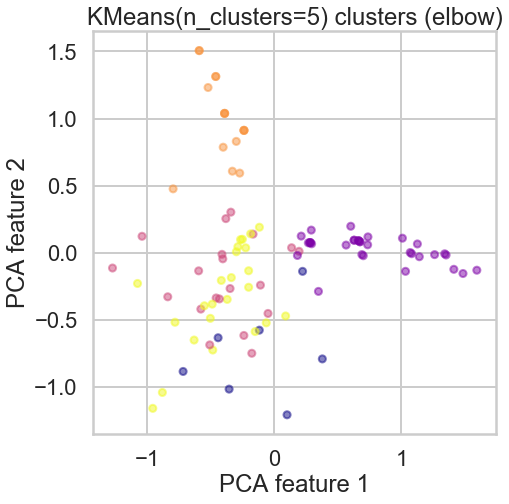

In [41]:
fig= plt.figure(figsize=(7,7))
axes= fig.add_axes([0.1,0.1,0.8,0.8])
axes.scatter(km5_df['x'], km5_df['y'], c=km5_df['KMeans_cluster'], s=50, alpha=0.5, cmap='plasma')
plt.title('KMeans(n_clusters=5) clusters (elbow)')
plt.xlabel('PCA feature 1')
plt.ylabel('PCA feature 2')
plt.show()

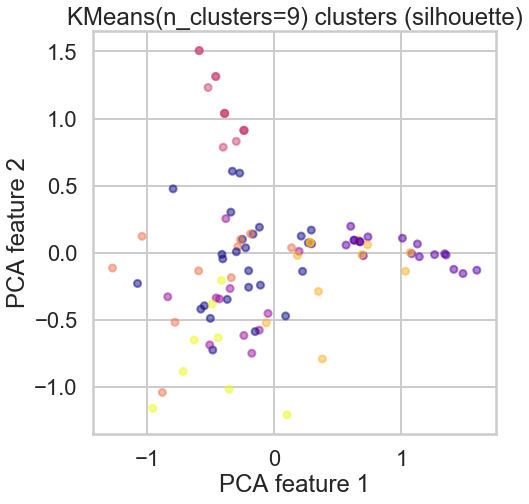

In [42]:
fig= plt.figure(figsize=(7,7))
axes= fig.add_axes([0.1,0.1,0.8,0.8])
axes.scatter(km9_df['x'], km9_df['y'], c=km9_df['KMeans_cluster'], s=50, alpha=0.5, cmap='plasma')
plt.title('KMeans(n_clusters=9) clusters (silhouette)')
plt.xlabel('PCA feature 1')
plt.ylabel('PCA feature 2')
plt.show()

Based on the plots, plot with k=5, which is chosen using the Elbow method, produced a cleaner plot with less overlapping between clusters.

In [43]:
combined_data = km5_df.copy()

In [44]:
combined_data = combined_data.merge(pivot_df,left_on='Customer',right_on='customer_name')

/Users/siegfried/anaconda3/lib/python3.7/site-packages/pandas/core/reshape/merge.py:617: UserWarning: merging between different levels can give an unintended result (1 levels on the left, 4 on the right)
  warnings.warn(msg, UserWarning)


In [45]:
list_clusters =np.sort(combined_data['KMeans_cluster'].unique())

cluster label =  0
                               n   ct
21    (n, 22, August, Champagne)  6.0
2    (n, 3, February, Espumante)  5.0
5        (n, 6, March, Prosecco)  4.0
6        (n, 7, March, Prosecco)  4.0
7       (n, 8, March, Espumante)  3.0
18      (n, 19, July, Champagne)  3.0
3    (n, 4, February, Champagne)  2.0
26   (n, 27, October, Champagne)  2.0
9       (n, 10, April, Prosecco)  1.0
10       (n, 11, May, Champagne)  1.0
20    (n, 21, August, Champagne)  1.0
30  (n, 31, December, Champagne)  1.0


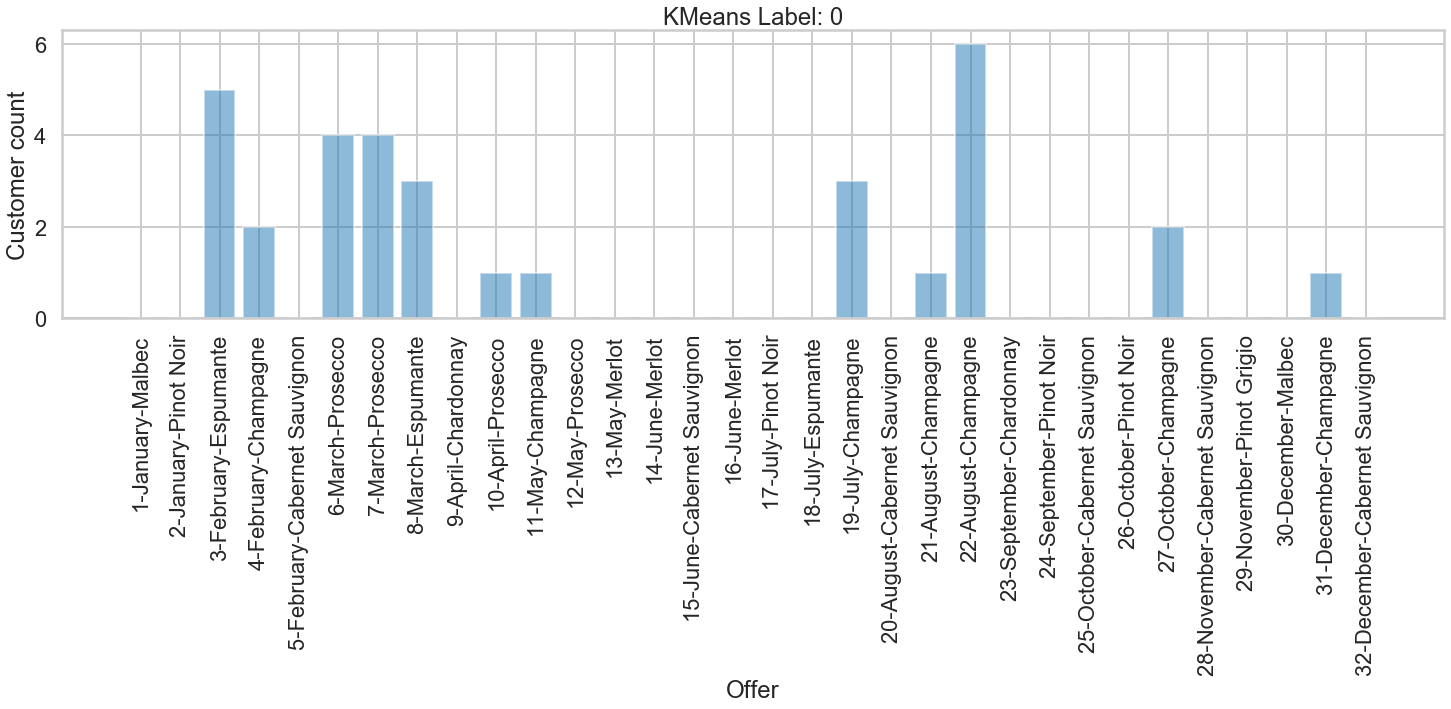

cluster label =  1
                                        n    ct
7                (n, 8, March, Espumante)  16.0
28        (n, 29, November, Pinot Grigio)  16.0
29              (n, 30, December, Malbec)  16.0
6                 (n, 7, March, Prosecco)  14.0
17               (n, 18, July, Espumante)  13.0
12                   (n, 13, May, Merlot)   6.0
5                 (n, 6, March, Prosecco)   1.0
9                (n, 10, April, Prosecco)   1.0
11                 (n, 12, May, Prosecco)   1.0
20             (n, 21, August, Champagne)   1.0
26            (n, 27, October, Champagne)   1.0
27  (n, 28, November, Cabernet Sauvignon)   1.0


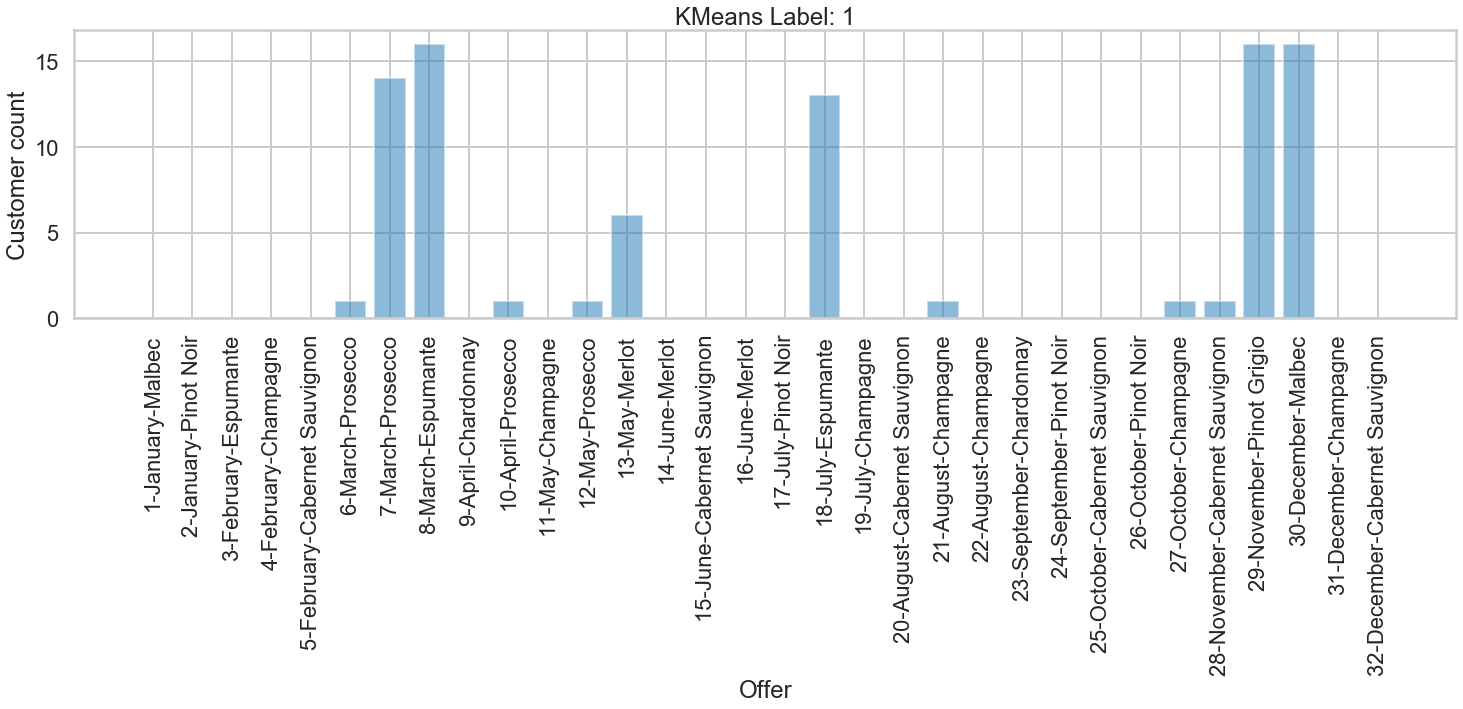

cluster label =  2
                                        n    ct
10                (n, 11, May, Champagne)  12.0
21             (n, 22, August, Champagne)   8.0
0                 (n, 1, January, Malbec)   7.0
29              (n, 30, December, Malbec)   6.0
24   (n, 25, October, Cabernet Sauvignon)   6.0
3             (n, 4, February, Champagne)   5.0
27  (n, 28, November, Cabernet Sauvignon)   5.0
1             (n, 2, January, Pinot Noir)   4.0
30           (n, 31, December, Champagne)   4.0
19    (n, 20, August, Cabernet Sauvignon)   4.0
15                  (n, 16, June, Merlot)   4.0
8               (n, 9, April, Chardonnay)   4.0
11                 (n, 12, May, Prosecco)   3.0
14      (n, 15, June, Cabernet Sauvignon)   2.0
13                  (n, 14, June, Merlot)   2.0
25           (n, 26, October, Pinot Noir)   2.0
31  (n, 32, December, Cabernet Sauvignon)   2.0
26            (n, 27, October, Champagne)   1.0
28        (n, 29, November, Pinot Grigio)   1.0
5                 (n,

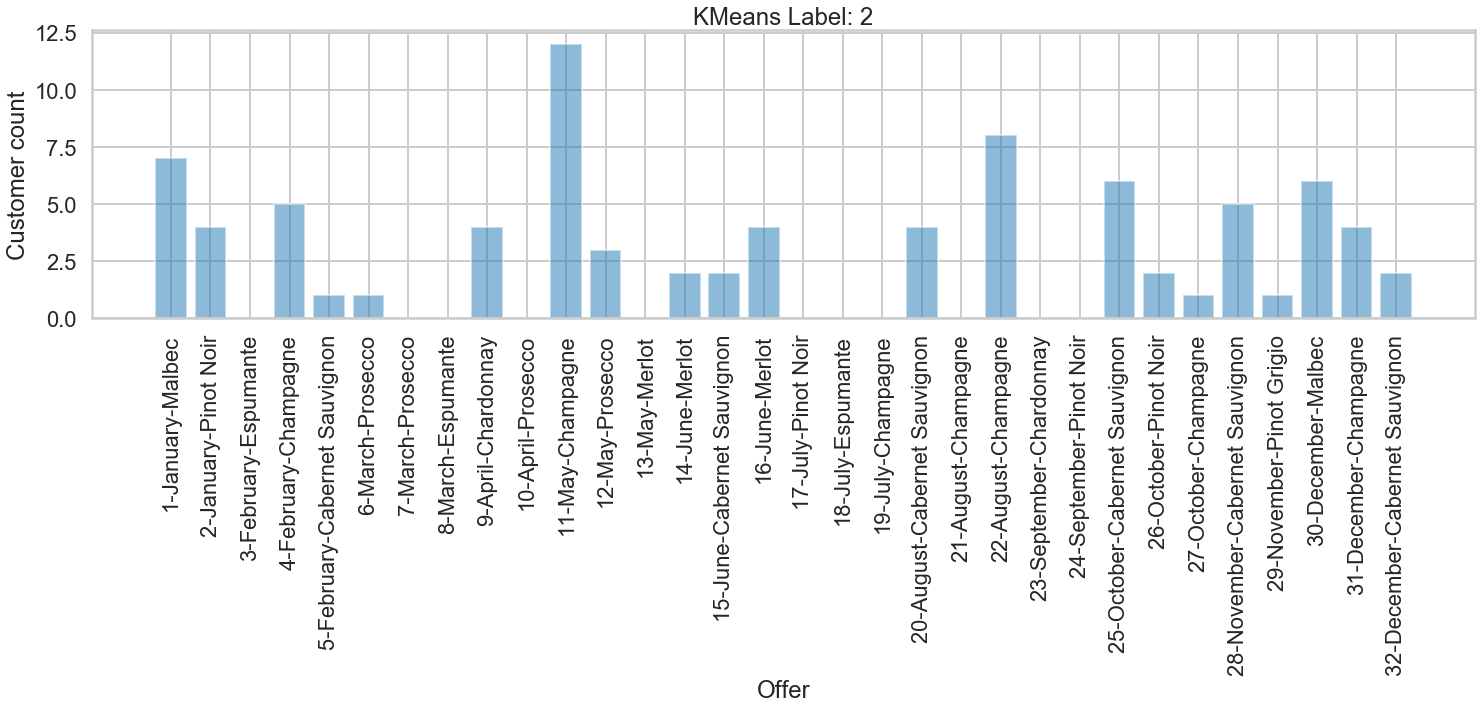

cluster label =  3
                                 n    ct
23  (n, 24, September, Pinot Noir)  12.0
25    (n, 26, October, Pinot Noir)  12.0
16       (n, 17, July, Pinot Noir)   7.0
1      (n, 2, January, Pinot Noir)   6.0
0          (n, 1, January, Malbec)   1.0
9         (n, 10, April, Prosecco)   1.0
11          (n, 12, May, Prosecco)   1.0
15           (n, 16, June, Merlot)   1.0
22  (n, 23, September, Chardonnay)   1.0
26     (n, 27, October, Champagne)   1.0


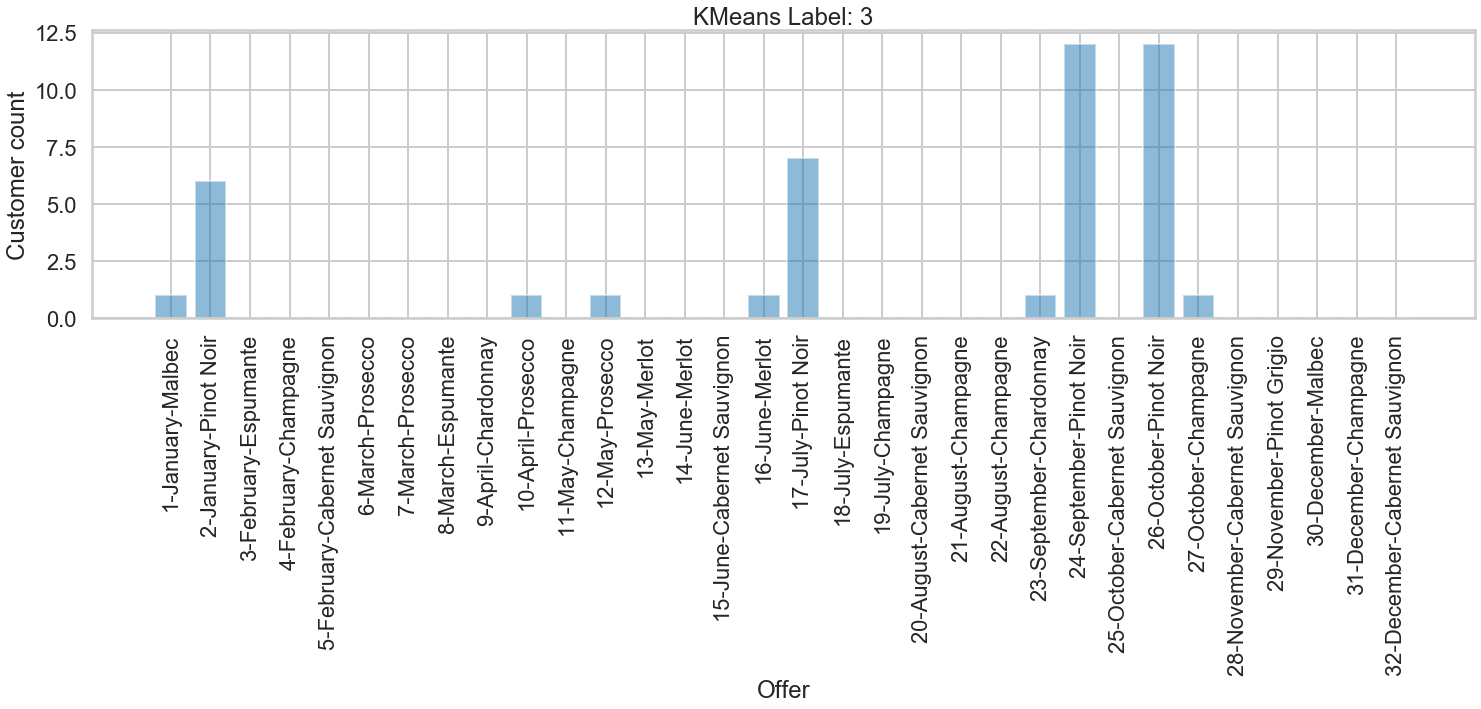

cluster label =  4
                                        n    ct
30           (n, 31, December, Champagne)  12.0
13                  (n, 14, June, Merlot)   7.0
21             (n, 22, August, Champagne)   7.0
5                 (n, 6, March, Prosecco)   6.0
8               (n, 9, April, Chardonnay)   6.0
3             (n, 4, February, Champagne)   5.0
14      (n, 15, June, Cabernet Sauvignon)   4.0
26            (n, 27, October, Champagne)   4.0
9                (n, 10, April, Prosecco)   4.0
22         (n, 23, September, Chardonnay)   4.0
4    (n, 5, February, Cabernet Sauvignon)   3.0
19    (n, 20, August, Cabernet Sauvignon)   2.0
20             (n, 21, August, Champagne)   2.0
0                 (n, 1, January, Malbec)   2.0
18               (n, 19, July, Champagne)   2.0
31  (n, 32, December, Cabernet Sauvignon)   2.0
17               (n, 18, July, Espumante)   1.0
2             (n, 3, February, Espumante)   1.0
25           (n, 26, October, Pinot Noir)   1.0
7                (n, 

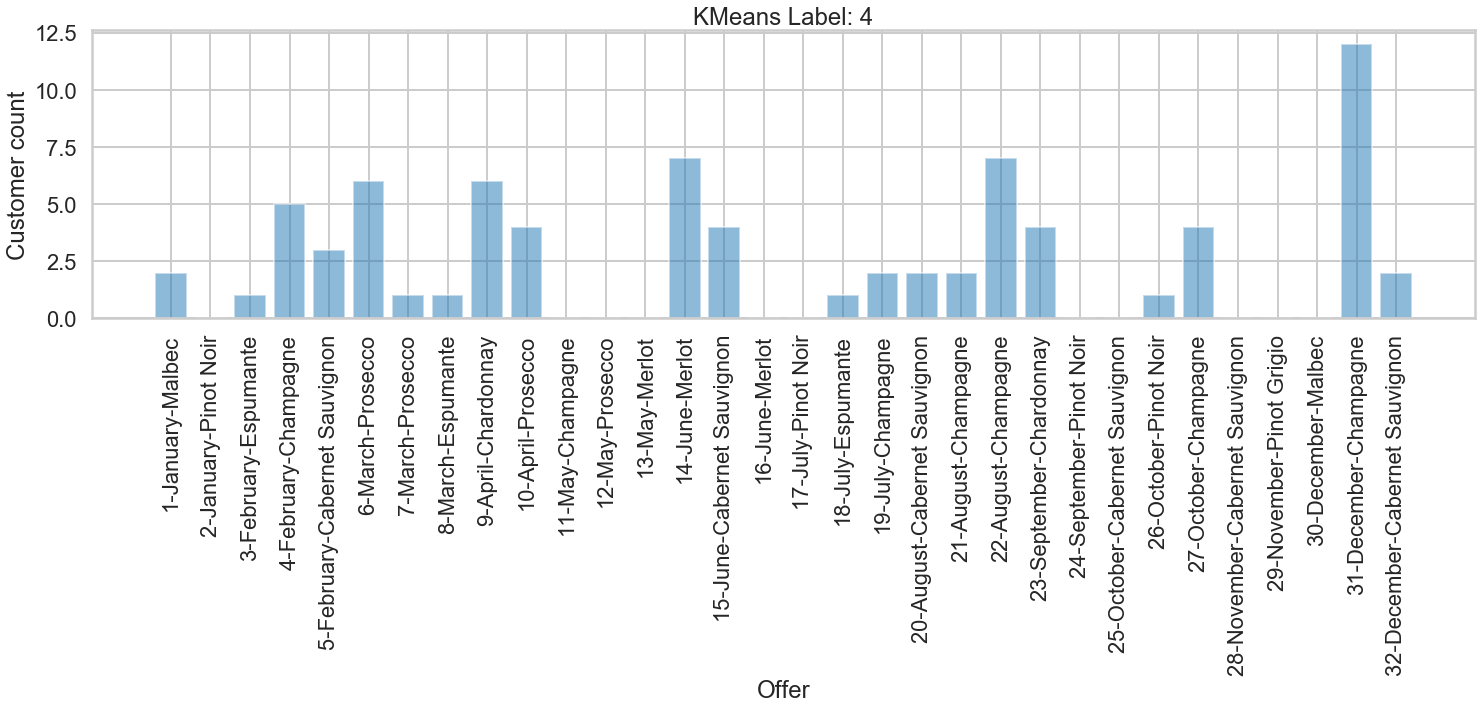

In [46]:
for cluster in list_clusters:
    exclude_cols = combined_data.columns[:5].tolist()
    sum_cols = combined_data.columns[5:].tolist()
    sum_list = combined_data[combined_data.KMeans_cluster==cluster].drop(exclude_cols,axis=1).sum().tolist()
    sum_df = pd.DataFrame({'n':sum_cols,'ct':sum_list})
    print("cluster label = ",cluster)
    print(sum_df[sum_df.ct != 0].sort_values(by='ct',ascending=False))
    fig= plt.figure(figsize=(24,5))
    axes= fig.add_axes([0.1,0.1,0.8,0.8])
    n_list = []
    offer_list = []
    for n in sum_cols:
        n_list.append(n[1])
        offer_list.append(str(n[1])+"-"+n[2]+"-"+n[3])
    axes.bar(offer_list, sum_df['ct'], align='center',alpha=0.5)
    plt_title = "KMeans Label: "+str(cluster)
    plt.title(plt_title)
    plt.xlabel('Offer')
    plt.ylabel('Customer count')
    plt.xticks(rotation=90)
    plt.show()

The KMeans clusters can mostly explained by the wine variants. Cluster 1 includes customers who bought Pinot Noir, cluster 2 includes those who most bought Champagne, and cluster 4 includes those who bought Prosecco. In addition, the clusters may also provide insights into the shopping habbits of the customers. Cluster 3 appears to include customers that would buy the offering wines regardless time and type of wines. Cluster 0 appears to include customers whoe would buy wines in specific times of the year. It is also conceivable that this group include subsets of customers who like specific wine types.  

In [49]:
combined_data.head()

Customer  KMeans_cluster         x         y (customer_name, , , )  \
0     Adams               1  1.007580  0.108215                 Adams   
1     Allen               4 -0.287539  0.044715                 Allen   
2  Anderson               3 -0.392032  1.038391              Anderson   
3    Bailey               1  0.699477 -0.022542                Bailey   
4     Baker               4  0.088183 -0.471695                 Baker   

   (n, 1, January, Malbec)  (n, 2, January, Pinot Noir)  \
0                      0.0                          0.0   
1                      0.0                          0.0   
2                      0.0                          0.0   
3                      0.0                          0.0   
4                      0.0                          0.0   

   (n, 3, February, Espumante)  (n, 4, February, Champagne)  \
0                          0.0                          0.0   
1                          0.0                          0.0   
2                          0.0                          0.0   
3                          0.0                          0.0   
4                          0.0                          0.0   

   (n, 5, February, Cabernet Sauvignon)  ...  (n, 23, September, Chardonnay)  \
0                                   0.0  ...                             0.0   
1                                   0.0  ...                             0.0   
2                                   0.0  ...                             0.0   
3                                   0.0  ...                             0.0   
4                                   0.0  ...                             0.0   

   (n, 24, September, Pinot Noir)  (n, 25, October, Cabernet Sauvignon)  \
0                             0.0                                   0.0   
1                             0.0                                   0.0   
2                             1.0                                   0.0   
3                             0.0                                   0.0   
4                             0.0                                   0.0   

   (n, 26, October, Pinot Noir)  (n, 27, October, Champagne)  \
0                           0.0                          0.0   
1                           0.0                          1.0   
2                           1.0                          0.0   
3                           0.0                          0.0   
4                           0.0                          0.0   

   (n, 28, November, Cabernet Sauvignon)  (n, 29, November, Pinot Grigio)  \
0                                    0.0                              1.0   
1                                    0.0                              0.0   
2                                    0.0                              0.0   
3                                    0.0                              0.0   
4                                    0.0                              0.0   

   (n, 30, December, Malbec)  (n, 31, December, Champagne)  \
0                        1.0                           0.0   
1                        0.0                           0.0   
2                        0.0                           0.0   
3                        1.0                           0.0   
4                        0.0                           1.0   

   (n, 32, December, Cabernet Sauvignon)  
0                                    0.0  
1                                    0.0  
2                                    0.0  
3                                    0.0  
4                                    0.0  

[5 rows x 37 columns]

In [51]:
import calendar

cluster label =  0
                               n   ct
21    (n, 22, August, Champagne)  6.0
2    (n, 3, February, Espumante)  5.0
5        (n, 6, March, Prosecco)  4.0
6        (n, 7, March, Prosecco)  4.0
7       (n, 8, March, Espumante)  3.0
18      (n, 19, July, Champagne)  3.0
3    (n, 4, February, Champagne)  2.0
26   (n, 27, October, Champagne)  2.0
9       (n, 10, April, Prosecco)  1.0
10       (n, 11, May, Champagne)  1.0
20    (n, 21, August, Champagne)  1.0
30  (n, 31, December, Champagne)  1.0


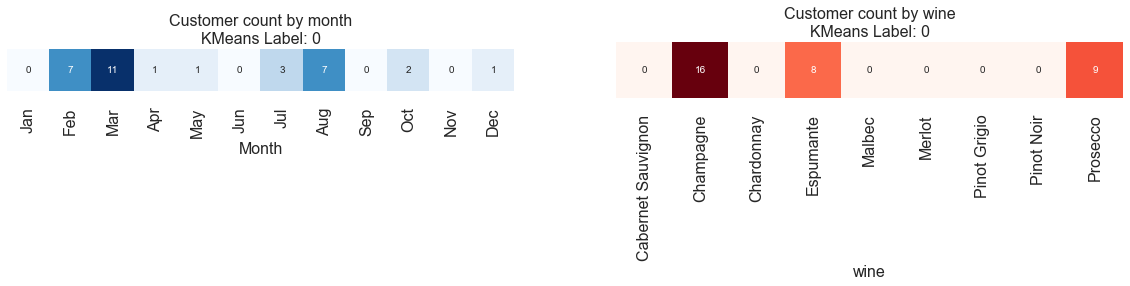

<Figure size 720x216 with 0 Axes>

<Figure size 720x216 with 0 Axes>

cluster label =  1
                                        n    ct
7                (n, 8, March, Espumante)  16.0
28        (n, 29, November, Pinot Grigio)  16.0
29              (n, 30, December, Malbec)  16.0
6                 (n, 7, March, Prosecco)  14.0
17               (n, 18, July, Espumante)  13.0
12                   (n, 13, May, Merlot)   6.0
5                 (n, 6, March, Prosecco)   1.0
9                (n, 10, April, Prosecco)   1.0
11                 (n, 12, May, Prosecco)   1.0
20             (n, 21, August, Champagne)   1.0
26            (n, 27, October, Champagne)   1.0
27  (n, 28, November, Cabernet Sauvignon)   1.0


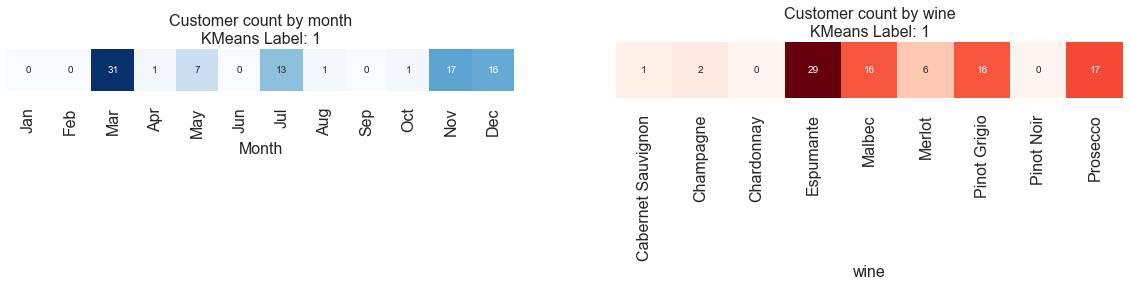

<Figure size 720x216 with 0 Axes>

<Figure size 720x216 with 0 Axes>

cluster label =  2
                                        n    ct
10                (n, 11, May, Champagne)  12.0
21             (n, 22, August, Champagne)   8.0
0                 (n, 1, January, Malbec)   7.0
29              (n, 30, December, Malbec)   6.0
24   (n, 25, October, Cabernet Sauvignon)   6.0
3             (n, 4, February, Champagne)   5.0
27  (n, 28, November, Cabernet Sauvignon)   5.0
1             (n, 2, January, Pinot Noir)   4.0
30           (n, 31, December, Champagne)   4.0
19    (n, 20, August, Cabernet Sauvignon)   4.0
15                  (n, 16, June, Merlot)   4.0
8               (n, 9, April, Chardonnay)   4.0
11                 (n, 12, May, Prosecco)   3.0
14      (n, 15, June, Cabernet Sauvignon)   2.0
13                  (n, 14, June, Merlot)   2.0
25           (n, 26, October, Pinot Noir)   2.0
31  (n, 32, December, Cabernet Sauvignon)   2.0
26            (n, 27, October, Champagne)   1.0
28        (n, 29, November, Pinot Grigio)   1.0
5                 (n,

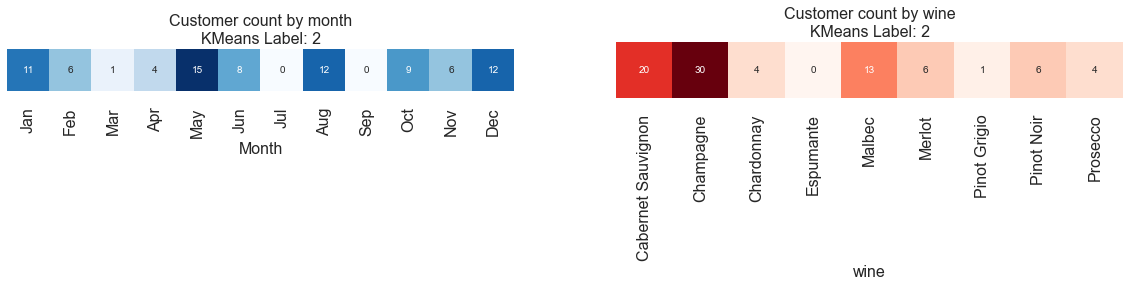

<Figure size 720x216 with 0 Axes>

<Figure size 720x216 with 0 Axes>

cluster label =  3
                                 n    ct
23  (n, 24, September, Pinot Noir)  12.0
25    (n, 26, October, Pinot Noir)  12.0
16       (n, 17, July, Pinot Noir)   7.0
1      (n, 2, January, Pinot Noir)   6.0
0          (n, 1, January, Malbec)   1.0
9         (n, 10, April, Prosecco)   1.0
11          (n, 12, May, Prosecco)   1.0
15           (n, 16, June, Merlot)   1.0
22  (n, 23, September, Chardonnay)   1.0
26     (n, 27, October, Champagne)   1.0


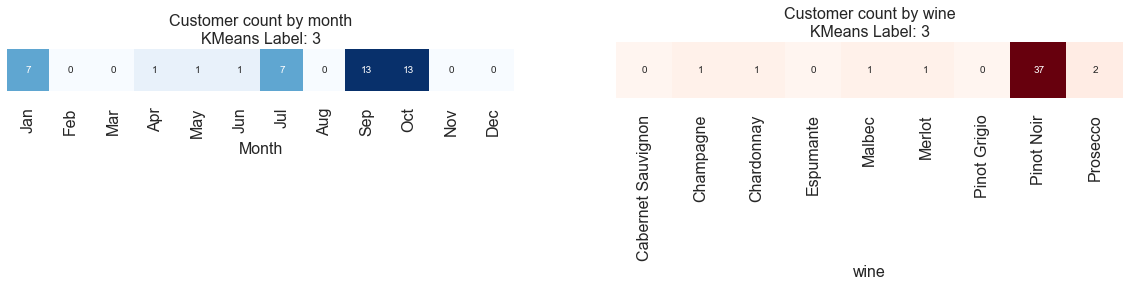

<Figure size 720x216 with 0 Axes>

<Figure size 720x216 with 0 Axes>

cluster label =  4
                                        n    ct
30           (n, 31, December, Champagne)  12.0
13                  (n, 14, June, Merlot)   7.0
21             (n, 22, August, Champagne)   7.0
5                 (n, 6, March, Prosecco)   6.0
8               (n, 9, April, Chardonnay)   6.0
3             (n, 4, February, Champagne)   5.0
14      (n, 15, June, Cabernet Sauvignon)   4.0
26            (n, 27, October, Champagne)   4.0
9                (n, 10, April, Prosecco)   4.0
22         (n, 23, September, Chardonnay)   4.0
4    (n, 5, February, Cabernet Sauvignon)   3.0
19    (n, 20, August, Cabernet Sauvignon)   2.0
20             (n, 21, August, Champagne)   2.0
0                 (n, 1, January, Malbec)   2.0
18               (n, 19, July, Champagne)   2.0
31  (n, 32, December, Cabernet Sauvignon)   2.0
17               (n, 18, July, Espumante)   1.0
2             (n, 3, February, Espumante)   1.0
25           (n, 26, October, Pinot Noir)   1.0
7                (n, 

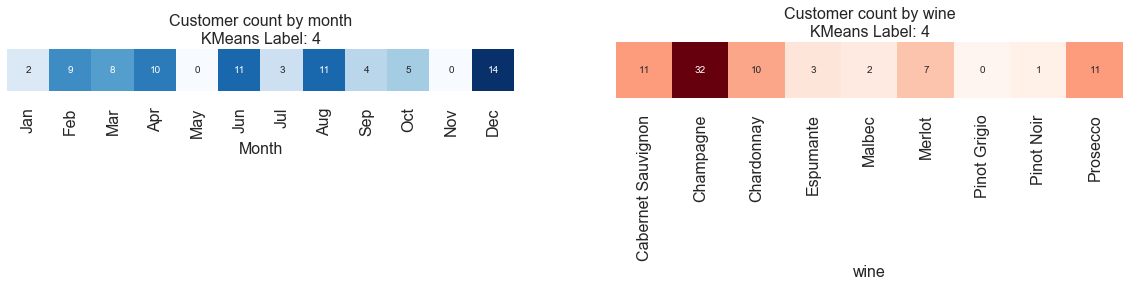

<Figure size 720x216 with 0 Axes>

<Figure size 720x216 with 0 Axes>

In [52]:
for cluster in list_clusters:
    exclude_cols = combined_data.columns[:5].tolist()
    sum_cols = combined_data.columns[5:].tolist()
    sum_list = combined_data[combined_data.KMeans_cluster==cluster].drop(exclude_cols,axis=1).sum().tolist()
    sum_df = pd.DataFrame({'n':sum_cols,'ct':sum_list})
    print("cluster label = ",cluster)
    print(sum_df[sum_df.ct != 0].sort_values(by='ct',ascending=False))

    # get lists of months and wines from sum_df
    list_month =[]
    list_wine = []
    for col in sum_cols:
        list_month.append(col[2])
        list_wine.append(col[3])
    sum_df['month'] = list_month
    sum_df['wine'] = list_wine
    sum_df['month'] = pd.to_datetime(sum_df.month, format='%B', errors='coerce').dt.month

    # to examine purchasing customers in each month: groupby month, count customers
    combined_month_ct = sum_df.groupby('month').sum()
    #print(combined_month_ct)
    
    # to examine purchasing customers by wine type; groupby wine, count customers
    combined_wine_ct = sum_df.drop(['month'],axis=1).groupby('wine').sum()
    #print(combined_wine_ct)
    
    # print 1D heatmap for each
    f = plt.figure(figsize=(20,3))

    ax1 = f.add_subplot(121)
    ax2 = f.add_subplot(122)

    plt_title1 = "Customer count by month\nKMeans Label: "+str(cluster)
    x_axlabels1 = []
    for n in combined_month_ct.index:
        x_axlabels1.append(calendar.month_abbr[n])
    g1 = plt.figure(figsize=(10,3))
    g1 = sns.heatmap([combined_month_ct['ct']], cmap='Blues', annot=True, yticklabels=False, cbar=False, ax=ax1, square=True)
    g1.set_title(plt_title1,fontsize=16)
    g1.set_xlabel('Month',fontsize=16)
    g1.set_xticklabels(x_axlabels1, fontsize=16, rotation=90)

    plt_title2 = "Customer count by wine\nKMeans Label: "+str(cluster)
    x_axlabels2 = np.array(combined_wine_ct.index)
    g2 = plt.figure(figsize=(10,3))
    g2 = sns.heatmap([combined_wine_ct['ct']], cmap='Reds', annot=True, yticklabels=False, cbar=False, ax=ax2, square=True)
    g2.set_title(plt_title2,fontsize=16)
    g2.set_xlabel('wine',fontsize=16)
    g2.set_xticklabels(x_axlabels2, fontsize=16, rotation=90)

    plt.show()

What we've done is we've taken those columns of 0/1 indicator variables, and we've transformed them into a 2-D dataset. We took one column and arbitrarily called it `x` and then called the other `y`. Now we can throw each point into a scatterplot. We color coded each point based on it's cluster so it's easier to see them.

<div class="span5 alert alert-info">
<h3>Exercise Set V</h3>

<p>As we saw earlier, PCA has a lot of other uses. Since we wanted to visualize our data in 2 dimensions, restricted the number of dimensions to 2 in PCA. But what is the true optimal number of dimensions?</p>

<p><b>Exercise:</b> Using a new PCA object shown in the next cell, plot the `explained_variance_` field and look for the elbow point, the point where the curve's rate of descent seems to slow sharply. This value is one possible value for the optimal number of dimensions. What is it?</p>
</div>

In [53]:
#your turn
# Initialize a new PCA model with a default number of components.
import sklearn.decomposition
pca = sklearn.decomposition.PCA()
pca.fit(x_cols)

# Do the rest on your own :)


PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

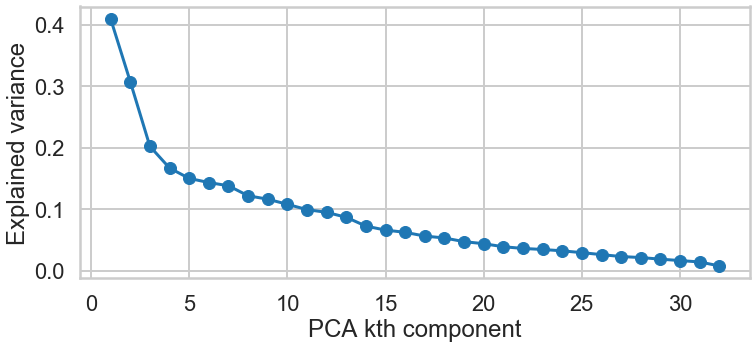

In [54]:
plt.figure(figsize=(12,5))
plt.plot(np.arange(1,len(pca.explained_variance_)+1), pca.explained_variance_, '-o')
plt.xlabel('PCA kth component')
plt.ylabel('Explained variance')
plt.show()

Based on the explained variance, the optimal dimension appears to be 4.

## Other Clustering Algorithms

k-means is only one of a ton of clustering algorithms. Below is a brief description of several clustering algorithms, and the table provides references to the other clustering algorithms in scikit-learn. 

* **Affinity Propagation** does not require the number of clusters $K$ to be known in advance! AP uses a "message passing" paradigm to cluster points based on their similarity. 

* **Spectral Clustering** uses the eigenvalues of a similarity matrix to reduce the dimensionality of the data before clustering in a lower dimensional space. This is tangentially similar to what we did to visualize k-means clusters using PCA. The number of clusters must be known a priori.

* **Ward's Method** applies to hierarchical clustering. Hierarchical clustering algorithms take a set of data and successively divide the observations into more and more clusters at each layer of the hierarchy. Ward's method is used to determine when two clusters in the hierarchy should be combined into one. It is basically an extension of hierarchical clustering. Hierarchical clustering is *divisive*, that is, all observations are part of the same cluster at first, and at each successive iteration, the clusters are made smaller and smaller. With hierarchical clustering, a hierarchy is constructed, and there is not really the concept of "number of clusters." The number of clusters simply determines how low or how high in the hierarchy we reference and can be determined empirically or by looking at the [dendogram](https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.cluster.hierarchy.dendrogram.html).

* **Agglomerative Clustering** is similar to hierarchical clustering but but is not divisive, it is *agglomerative*. That is, every observation is placed into its own cluster and at each iteration or level or the hierarchy, observations are merged into fewer and fewer clusters until convergence. Similar to hierarchical clustering, the constructed hierarchy contains all possible numbers of clusters and it is up to the analyst to pick the number by reviewing statistics or the dendogram.

* **DBSCAN** is based on point density rather than distance. It groups together points with many nearby neighbors. DBSCAN is one of the most cited algorithms in the literature. It does not require knowing the number of clusters a priori, but does require specifying the neighborhood size.

### Clustering Algorithms in Scikit-learn
<table border="1">
<colgroup>
<col width="15%" />
<col width="16%" />
<col width="20%" />
<col width="27%" />
<col width="22%" />
</colgroup>
<thead valign="bottom">
<tr><th>Method name</th>
<th>Parameters</th>
<th>Scalability</th>
<th>Use Case</th>
<th>Geometry (metric used)</th>
</tr>
</thead>
<tbody valign="top">
<tr><td>K-Means</span></a></td>
<td>number of clusters</td>
<td>Very large<span class="pre">n_samples</span>, medium <span class="pre">n_clusters</span> with
MiniBatch code</td>
<td>General-purpose, even cluster size, flat geometry, not too many clusters</td>
<td>Distances between points</td>
</tr>
<tr><td>Affinity propagation</td>
<td>damping, sample preference</td>
<td>Not scalable with n_samples</td>
<td>Many clusters, uneven cluster size, non-flat geometry</td>
<td>Graph distance (e.g. nearest-neighbor graph)</td>
</tr>
<tr><td>Mean-shift</td>
<td>bandwidth</td>
<td>Not scalable with <span class="pre">n_samples</span></td>
<td>Many clusters, uneven cluster size, non-flat geometry</td>
<td>Distances between points</td>
</tr>
<tr><td>Spectral clustering</td>
<td>number of clusters</td>
<td>Medium <span class="pre">n_samples</span>, small <span class="pre">n_clusters</span></td>
<td>Few clusters, even cluster size, non-flat geometry</td>
<td>Graph distance (e.g. nearest-neighbor graph)</td>
</tr>
<tr><td>Ward hierarchical clustering</td>
<td>number of clusters</td>
<td>Large <span class="pre">n_samples</span> and <span class="pre">n_clusters</span></td>
<td>Many clusters, possibly connectivity constraints</td>
<td>Distances between points</td>
</tr>
<tr><td>Agglomerative clustering</td>
<td>number of clusters, linkage type, distance</td>
<td>Large <span class="pre">n_samples</span> and <span class="pre">n_clusters</span></td>
<td>Many clusters, possibly connectivity constraints, non Euclidean
distances</td>
<td>Any pairwise distance</td>
</tr>
<tr><td>DBSCAN</td>
<td>neighborhood size</td>
<td>Very large <span class="pre">n_samples</span>, medium <span class="pre">n_clusters</span></td>
<td>Non-flat geometry, uneven cluster sizes</td>
<td>Distances between nearest points</td>
</tr>
<tr><td>Gaussian mixtures</td>
<td>many</td>
<td>Not scalable</td>
<td>Flat geometry, good for density estimation</td>
<td>Mahalanobis distances to  centers</td>
</tr>
<tr><td>Birch</td>
<td>branching factor, threshold, optional global clusterer.</td>
<td>Large <span class="pre">n_clusters</span> and <span class="pre">n_samples</span></td>
<td>Large dataset, outlier removal, data reduction.</td>
<td>Euclidean distance between points</td>
</tr>
</tbody>
</table>
Source: http://scikit-learn.org/stable/modules/clustering.html

<div class="span5 alert alert-info">
<h3>Exercise Set VI</h3>

<p><b>Exercise:</b> Try clustering using the following algorithms. </p>
<ol>
<li>Affinity propagation
<li>Spectral clustering
<li>Agglomerative clustering
<li>DBSCAN
</ol>
<p>How do their results compare? Which performs the best? Tell a story why you think it performs the best.</p>
</div>


In [70]:
# Your turn

In [71]:
#Affinity propagation

In [55]:
from sklearn.cluster import AffinityPropagation
ap= AffinityPropagation()
ap_labels = ap.fit_predict(x_cols)

In [56]:
cluster_centers_indices = ap.cluster_centers_indices_
ap_n_clusters = len(cluster_centers_indices)
ap_title = "Affinity propagation clusters ("+str(ap_n_clusters)+")"

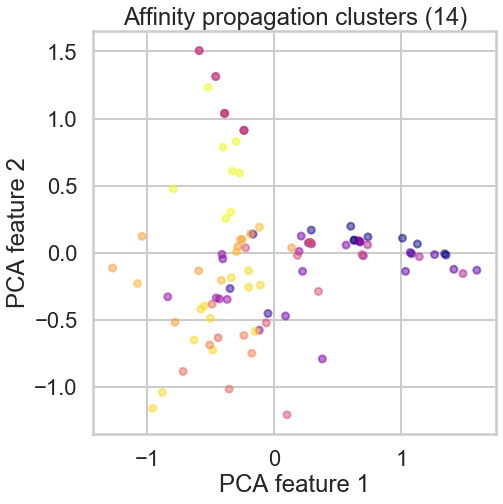

In [57]:
fig= plt.figure(figsize=(7,7))
axes= fig.add_axes([0.1,0.1,0.8,0.8])
axes.scatter(km5_df['x'], km5_df['y'], c=ap_labels, s=50, alpha=0.5, cmap='plasma')
plt.title(ap_title)
plt.xlabel('PCA feature 1')
plt.ylabel('PCA feature 2')
plt.show()

In [60]:
#Spectral clustering

In [61]:
from sklearn.cluster import SpectralClustering
sc = SpectralClustering(n_clusters=5, assign_labels='discretize')
sc_labels = sc.fit_predict(x_cols)

In [64]:
sc_labels

array([0, 4, 1, 0, 4, 4, 1, 3, 4, 0, 4, 1, 0, 4, 4, 1, 4, 1, 0, 4, 0, 3,
       4, 4, 1, 4, 4, 4, 4, 4, 4, 3, 4, 2, 4, 3, 4, 0, 4, 0, 1, 1, 3, 4,
       0, 2, 0, 4, 4, 4, 4, 4, 4, 1, 2, 3, 1, 4, 0, 3, 4, 3, 4, 0, 0, 4,
       1, 4, 4, 4, 4, 4, 2, 0, 4, 0, 1, 2, 4, 1, 4, 4, 4, 1, 3, 3, 0, 4,
       4, 3, 2, 0, 4, 0, 4, 4, 3, 4, 2, 4])

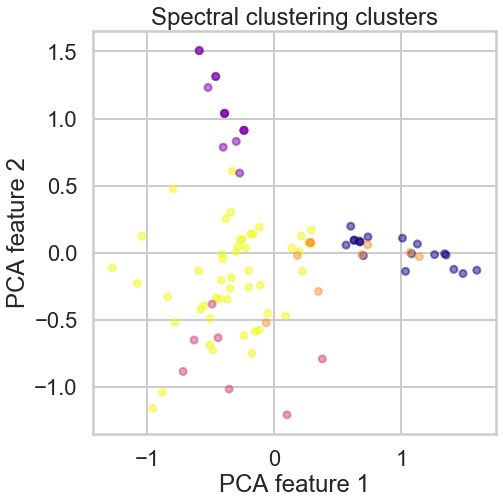

In [65]:
fig= plt.figure(figsize=(7,7))
axes= fig.add_axes([0.1,0.1,0.8,0.8])
axes.scatter(km5_df['x'], km5_df['y'], c=sc_labels, s=50, alpha=0.5, cmap='plasma')
plt.title('Spectral clustering clusters')
plt.xlabel('PCA feature 1')
plt.ylabel('PCA feature 2')
plt.show()

In [66]:
#Agglomerative clustering

In [67]:
from sklearn.cluster import AgglomerativeClustering
aggc = AgglomerativeClustering(n_clusters=5, linkage='ward')
aggc_labels = aggc.fit_predict(x_cols)

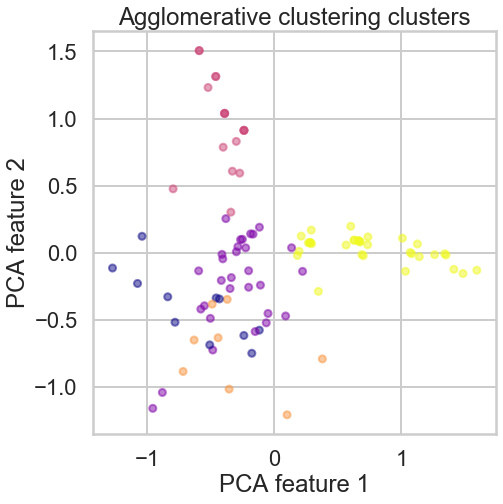

In [68]:
fig= plt.figure(figsize=(7,7))
axes= fig.add_axes([0.1,0.1,0.8,0.8])
axes.scatter(km5_df['x'], km5_df['y'], c=aggc_labels, s=50, alpha=0.5, cmap='plasma')
plt.title('Agglomerative clustering clusters')
plt.xlabel('PCA feature 1')
plt.ylabel('PCA feature 2')
plt.show()

In [69]:
#DBSCAN

In [70]:
from sklearn.cluster import DBSCAN
dbscan = DBSCAN(min_samples=3,eps=1)
dbscan_labels = dbscan.fit_predict(x_cols)

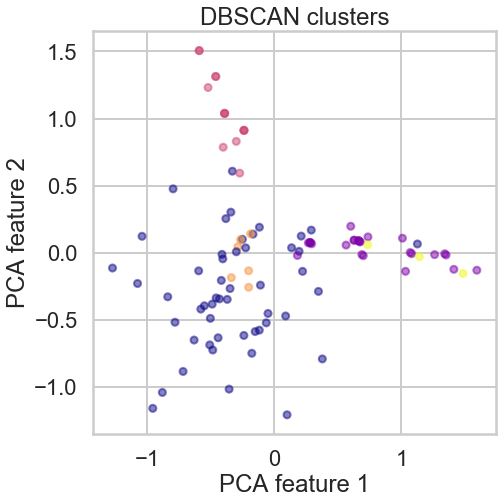

In [71]:
fig= plt.figure(figsize=(7,7))
axes= fig.add_axes([0.1,0.1,0.8,0.8])
axes.scatter(km5_df['x'], km5_df['y'], c=dbscan_labels, s=50, alpha=0.5, cmap='plasma')
plt.title('DBSCAN clusters')
plt.xlabel('PCA feature 1')
plt.ylabel('PCA feature 2')
plt.show()

In [72]:
#Perform same analysis as for KMeans

In [73]:
km5_df['AffProp_cluster'] = ap_labels
km5_df['Spectral_cluster'] = sc_labels
km5_df['Agglo_cluster'] = aggc_labels
km5_df['DBSCAN_cluster'] = dbscan_labels


In [74]:
km5_df

Customer  KMeans_cluster         x         y  AffProp_cluster  \
0      Adams               1  1.007580  0.108215                0   
1      Allen               4 -0.287539  0.044715               10   
2   Anderson               3 -0.392032  1.038391                6   
3     Bailey               1  0.699477 -0.022542                3   
4      Baker               4  0.088183 -0.471695                3   
..       ...             ...       ...       ...              ...   
95  Williams               4 -0.151666 -0.587844               12   
96    Wilson               1  0.688224 -0.013688                7   
97      Wood               4 -0.551215 -0.395670               12   
98    Wright               4 -0.489805 -0.383307                8   
99     Young               4 -0.881994 -1.041788               12   

    Spectral_cluster  Agglo_cluster  DBSCAN_cluster  
0                  0              4               0  
1                  4              1               2  
2                  1              2               1  
3                  0              4               0  
4                  4              1              -1  
..               ...            ...             ...  
95                 4              1              -1  
96                 3              4               0  
97                 4              1              -1  
98                 2              3              -1  
99                 4              1              -1  

[100 rows x 8 columns]

In [75]:
combined_data2 = km5_df.copy()
combined_data2 = combined_data2.merge(pivot_df,left_on='Customer',right_on='customer_name')

/Users/siegfried/anaconda3/lib/python3.7/site-packages/pandas/core/reshape/merge.py:617: UserWarning: merging between different levels can give an unintended result (1 levels on the left, 4 on the right)
  warnings.warn(msg, UserWarning)


In [76]:
combined_data2.head()

Customer  KMeans_cluster         x         y  AffProp_cluster  \
0     Adams               1  1.007580  0.108215                0   
1     Allen               4 -0.287539  0.044715               10   
2  Anderson               3 -0.392032  1.038391                6   
3    Bailey               1  0.699477 -0.022542                3   
4     Baker               4  0.088183 -0.471695                3   

   Spectral_cluster  Agglo_cluster  DBSCAN_cluster (customer_name, , , )  \
0                 0              4               0                 Adams   
1                 4              1               2                 Allen   
2                 1              2               1              Anderson   
3                 0              4               0                Bailey   
4                 4              1              -1                 Baker   

   (n, 1, January, Malbec)  ...  (n, 23, September, Chardonnay)  \
0                      0.0  ...                             0.0   
1                      0.0  ...                             0.0   
2                      0.0  ...                             0.0   
3                      0.0  ...                             0.0   
4                      0.0  ...                             0.0   

   (n, 24, September, Pinot Noir)  (n, 25, October, Cabernet Sauvignon)  \
0                             0.0                                   0.0   
1                             0.0                                   0.0   
2                             1.0                                   0.0   
3                             0.0                                   0.0   
4                             0.0                                   0.0   

   (n, 26, October, Pinot Noir)  (n, 27, October, Champagne)  \
0                           0.0                          0.0   
1                           0.0                          1.0   
2                           1.0                          0.0   
3                           0.0                          0.0   
4                           0.0                          0.0   

   (n, 28, November, Cabernet Sauvignon)  (n, 29, November, Pinot Grigio)  \
0                                    0.0                              1.0   
1                                    0.0                              0.0   
2                                    0.0                              0.0   
3                                    0.0                              0.0   
4                                    0.0                              0.0   

   (n, 30, December, Malbec)  (n, 31, December, Champagne)  \
0                        1.0                           0.0   
1                        0.0                           0.0   
2                        0.0                           0.0   
3                        1.0                           0.0   
4                        0.0                           1.0   

   (n, 32, December, Cabernet Sauvignon)  
0                                    0.0  
1                                    0.0  
2                                    0.0  
3                                    0.0  
4                                    0.0  

[5 rows x 41 columns]

cluster label =  0
                                        n   ct
17               (n, 18, July, Espumante)  7.0
28        (n, 29, November, Pinot Grigio)  7.0
29              (n, 30, December, Malbec)  6.0
6                 (n, 7, March, Prosecco)  2.0
7                (n, 8, March, Espumante)  1.0
12                   (n, 13, May, Merlot)  1.0
27  (n, 28, November, Cabernet Sauvignon)  1.0


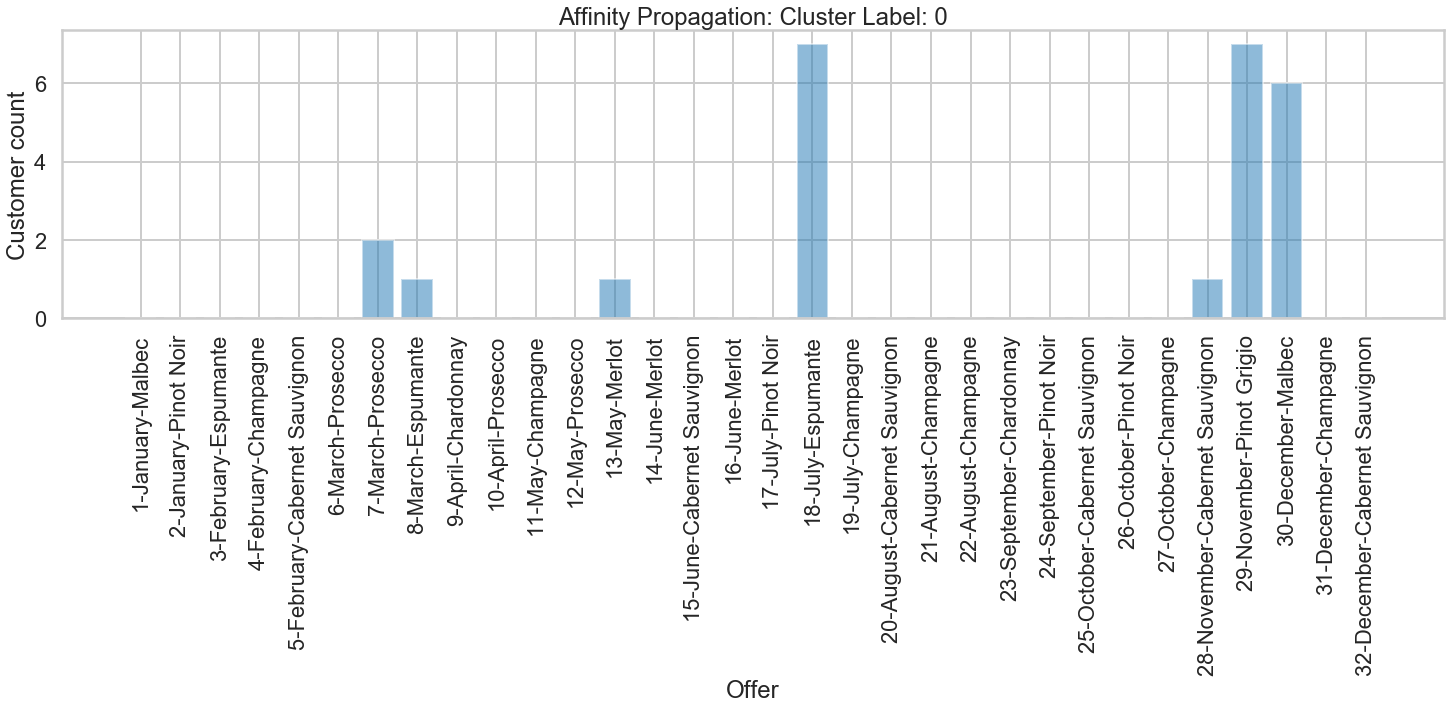

cluster label =  1
                                        n   ct
24   (n, 25, October, Cabernet Sauvignon)  3.0
11                 (n, 12, May, Prosecco)  2.0
21             (n, 22, August, Champagne)  2.0
13                  (n, 14, June, Merlot)  1.0
27  (n, 28, November, Cabernet Sauvignon)  1.0
29              (n, 30, December, Malbec)  1.0


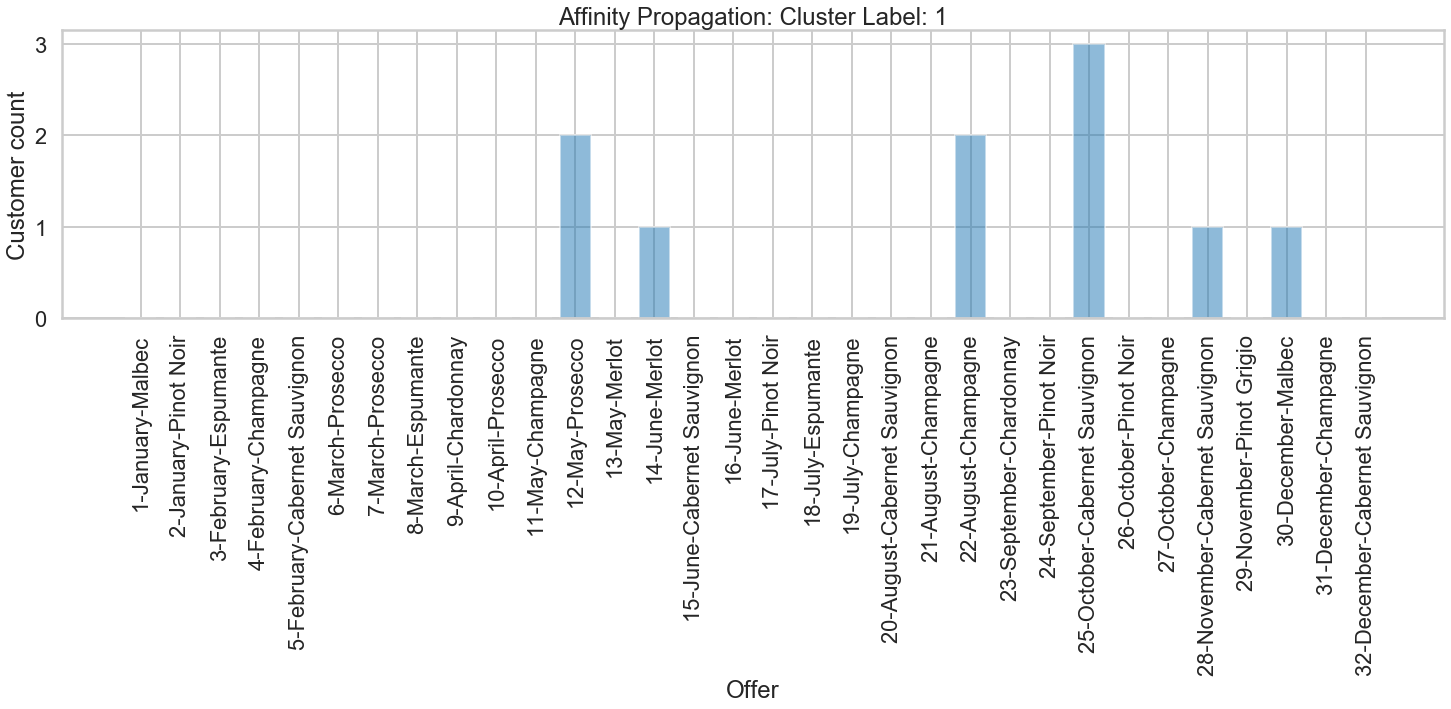

cluster label =  2
                                  n   ct
29        (n, 30, December, Malbec)  6.0
6           (n, 7, March, Prosecco)  5.0
28  (n, 29, November, Pinot Grigio)  5.0
7          (n, 8, March, Espumante)  4.0
12             (n, 13, May, Merlot)  2.0


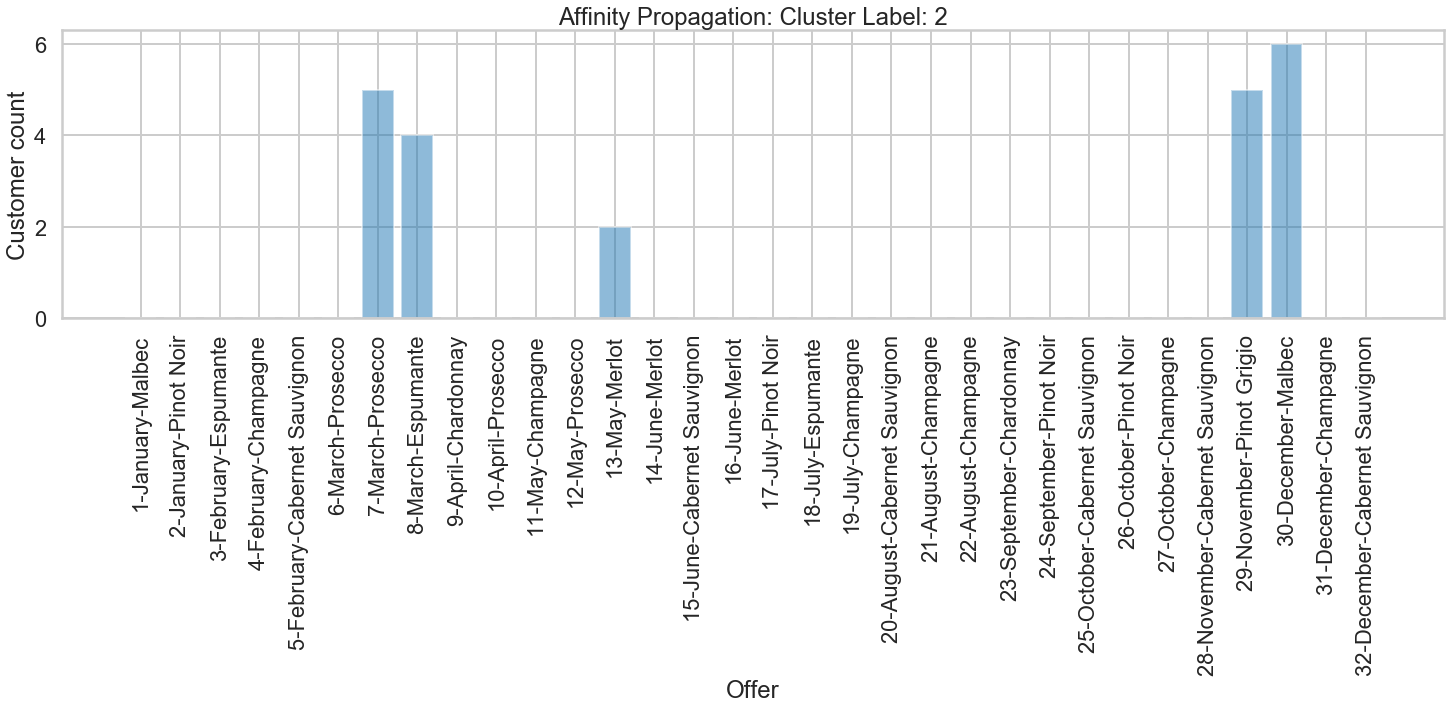

cluster label =  3
                                        n   ct
6                 (n, 7, March, Prosecco)  9.0
2             (n, 3, February, Espumante)  2.0
9                (n, 10, April, Prosecco)  2.0
17               (n, 18, July, Espumante)  2.0
18               (n, 19, July, Champagne)  2.0
20             (n, 21, August, Champagne)  2.0
28        (n, 29, November, Pinot Grigio)  2.0
3             (n, 4, February, Champagne)  1.0
7                (n, 8, March, Espumante)  1.0
11                 (n, 12, May, Prosecco)  1.0
15                  (n, 16, June, Merlot)  1.0
19    (n, 20, August, Cabernet Sauvignon)  1.0
21             (n, 22, August, Champagne)  1.0
29              (n, 30, December, Malbec)  1.0
30           (n, 31, December, Champagne)  1.0
31  (n, 32, December, Cabernet Sauvignon)  1.0


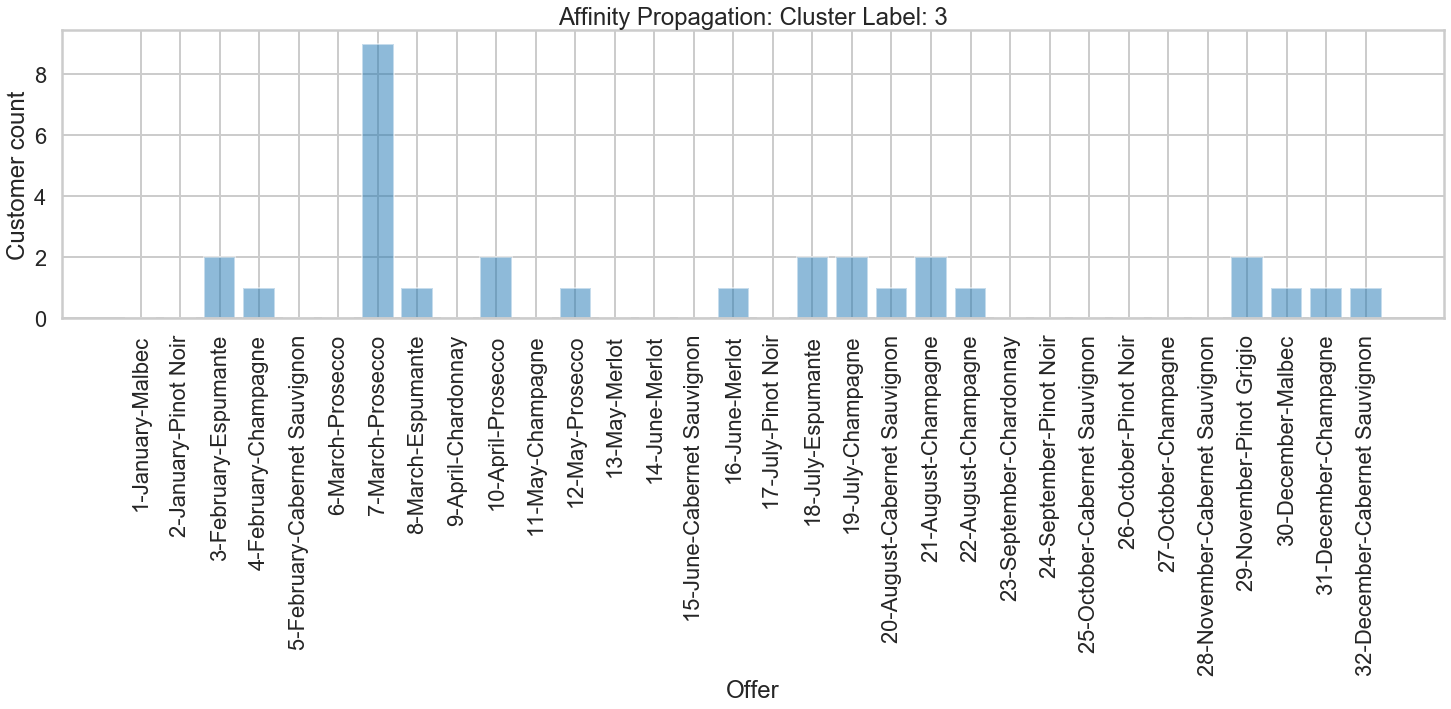

cluster label =  4
                                        n   ct
10                (n, 11, May, Champagne)  6.0
21             (n, 22, August, Champagne)  5.0
0                 (n, 1, January, Malbec)  1.0
1             (n, 2, January, Pinot Noir)  1.0
2             (n, 3, February, Espumante)  1.0
7                (n, 8, March, Espumante)  1.0
11                 (n, 12, May, Prosecco)  1.0
14      (n, 15, June, Cabernet Sauvignon)  1.0
19    (n, 20, August, Cabernet Sauvignon)  1.0
24   (n, 25, October, Cabernet Sauvignon)  1.0
26            (n, 27, October, Champagne)  1.0
29              (n, 30, December, Malbec)  1.0
31  (n, 32, December, Cabernet Sauvignon)  1.0


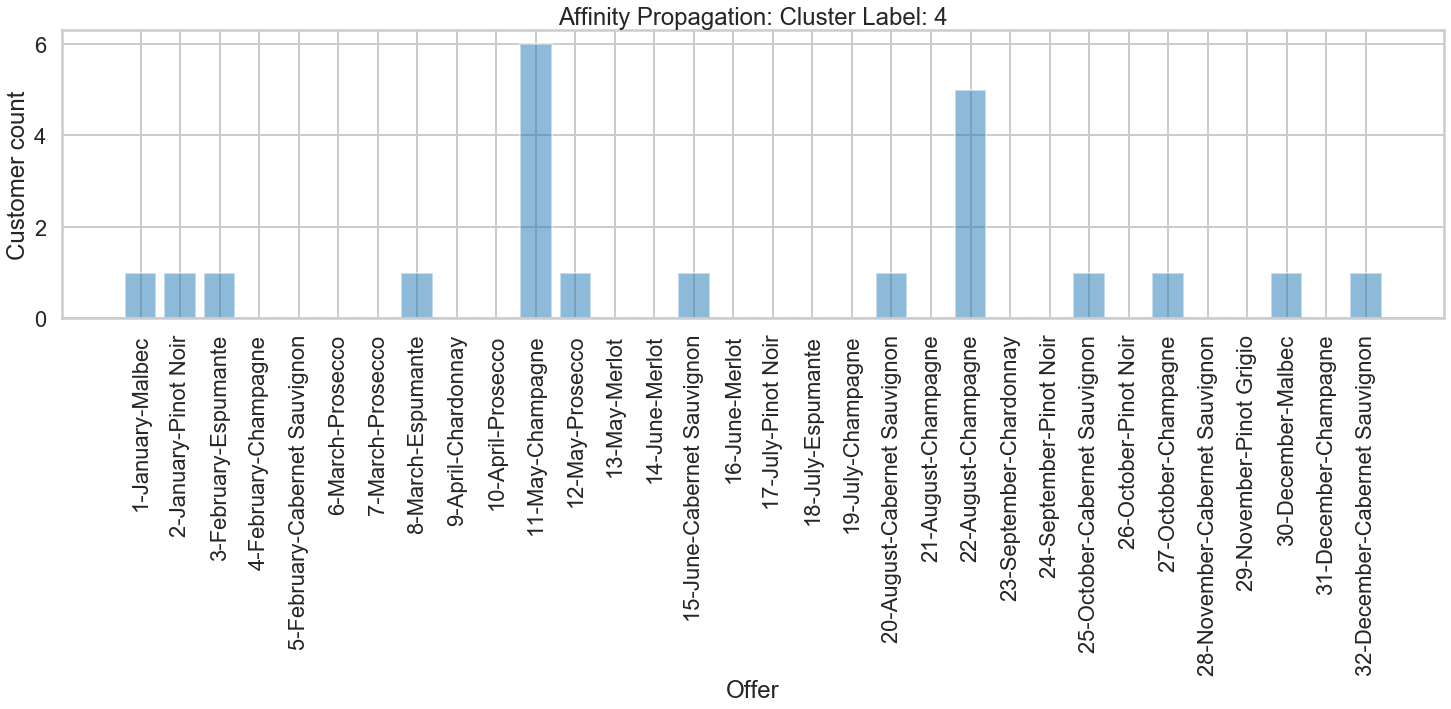

cluster label =  5
                            n   ct
7    (n, 8, March, Espumante)  3.0
12       (n, 13, May, Merlot)  3.0
17   (n, 18, July, Espumante)  3.0
29  (n, 30, December, Malbec)  2.0
6     (n, 7, March, Prosecco)  1.0


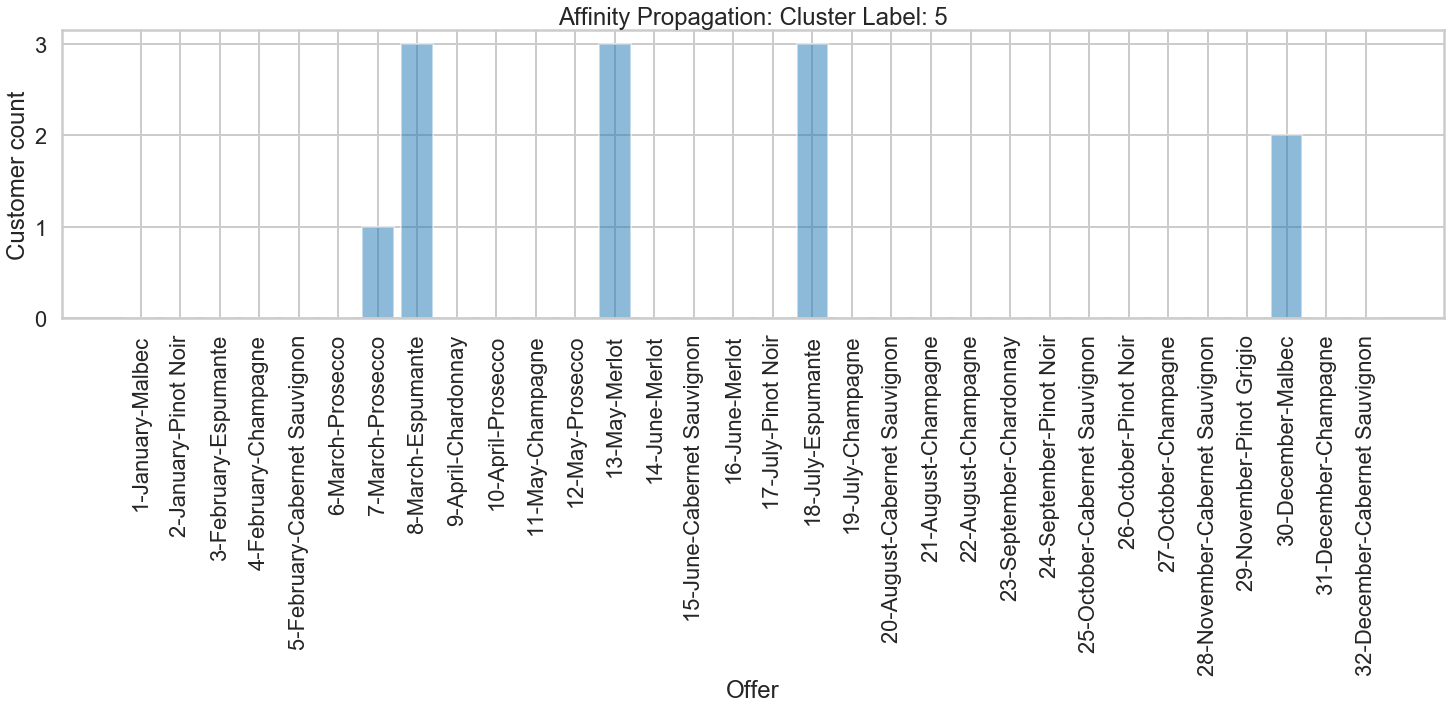

cluster label =  6
                                 n    ct
23  (n, 24, September, Pinot Noir)  10.0
16       (n, 17, July, Pinot Noir)   7.0
25    (n, 26, October, Pinot Noir)   7.0
1      (n, 2, January, Pinot Noir)   2.0


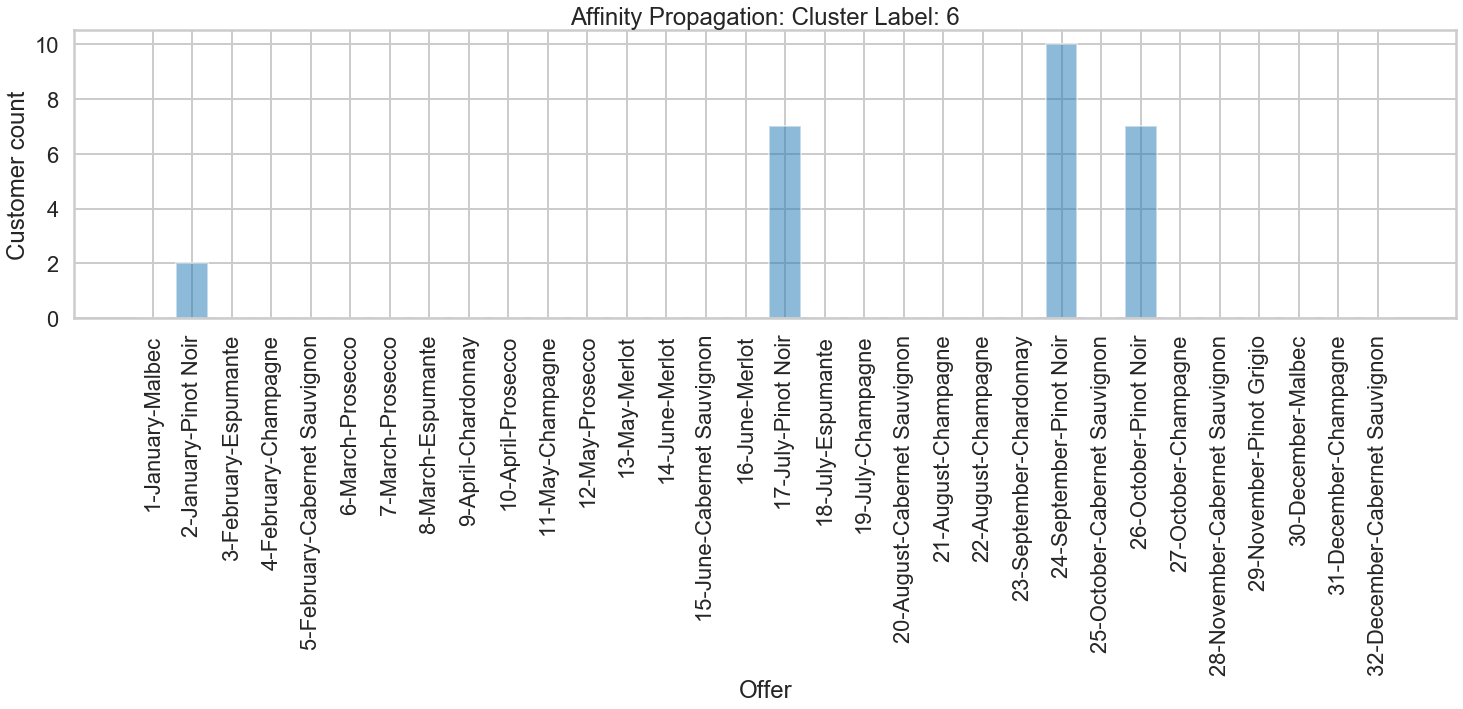

cluster label =  7
                                  n    ct
7          (n, 8, March, Espumante)  10.0
3       (n, 4, February, Champagne)   2.0
5           (n, 6, March, Prosecco)   2.0
28  (n, 29, November, Pinot Grigio)   2.0
30     (n, 31, December, Champagne)   2.0
2       (n, 3, February, Espumante)   1.0
6           (n, 7, March, Prosecco)   1.0
9          (n, 10, April, Prosecco)   1.0
17         (n, 18, July, Espumante)   1.0
18         (n, 19, July, Champagne)   1.0
21       (n, 22, August, Champagne)   1.0
26      (n, 27, October, Champagne)   1.0
29        (n, 30, December, Malbec)   1.0


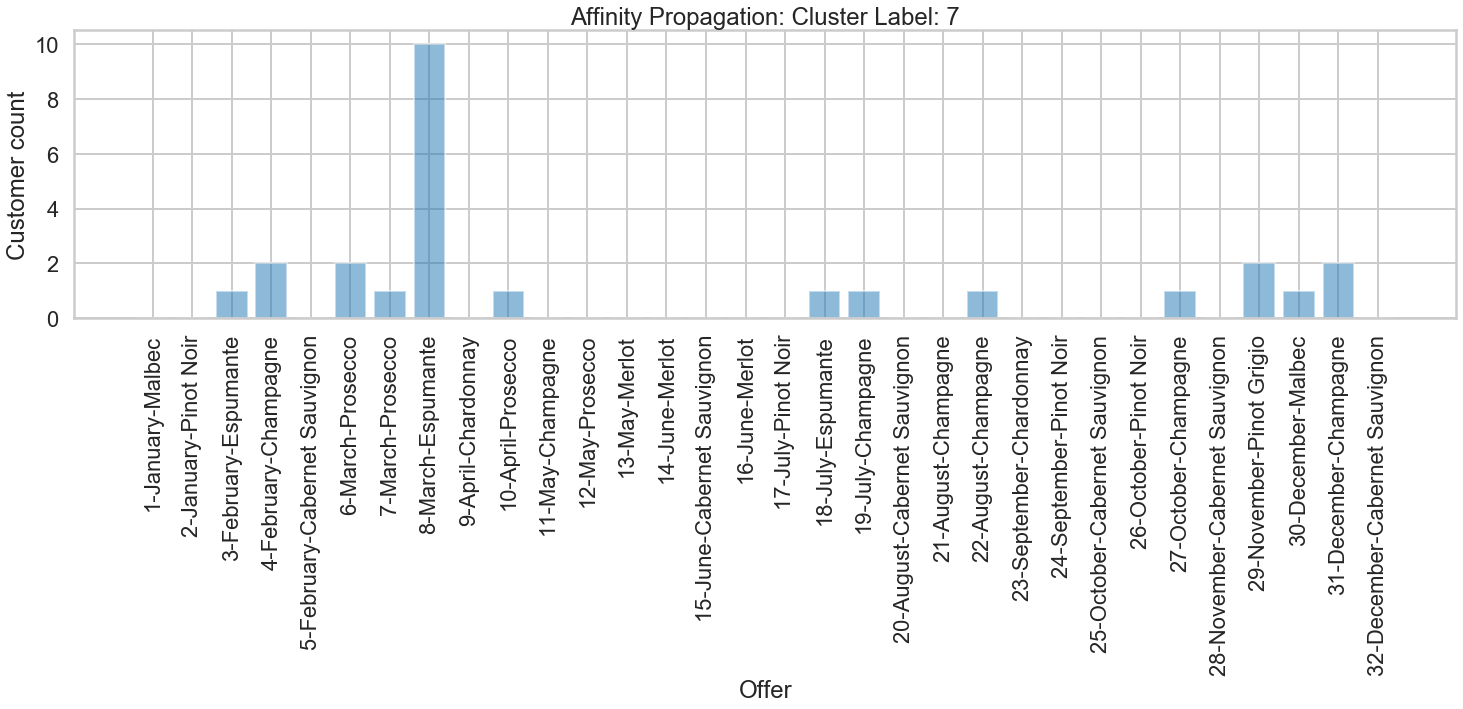

cluster label =  8
                              n   ct
5       (n, 6, March, Prosecco)  4.0
3   (n, 4, February, Champagne)  3.0
21   (n, 22, August, Champagne)  3.0
26  (n, 27, October, Champagne)  3.0
2   (n, 3, February, Espumante)  2.0
6       (n, 7, March, Prosecco)  1.0
18     (n, 19, July, Champagne)  1.0
20   (n, 21, August, Champagne)  1.0


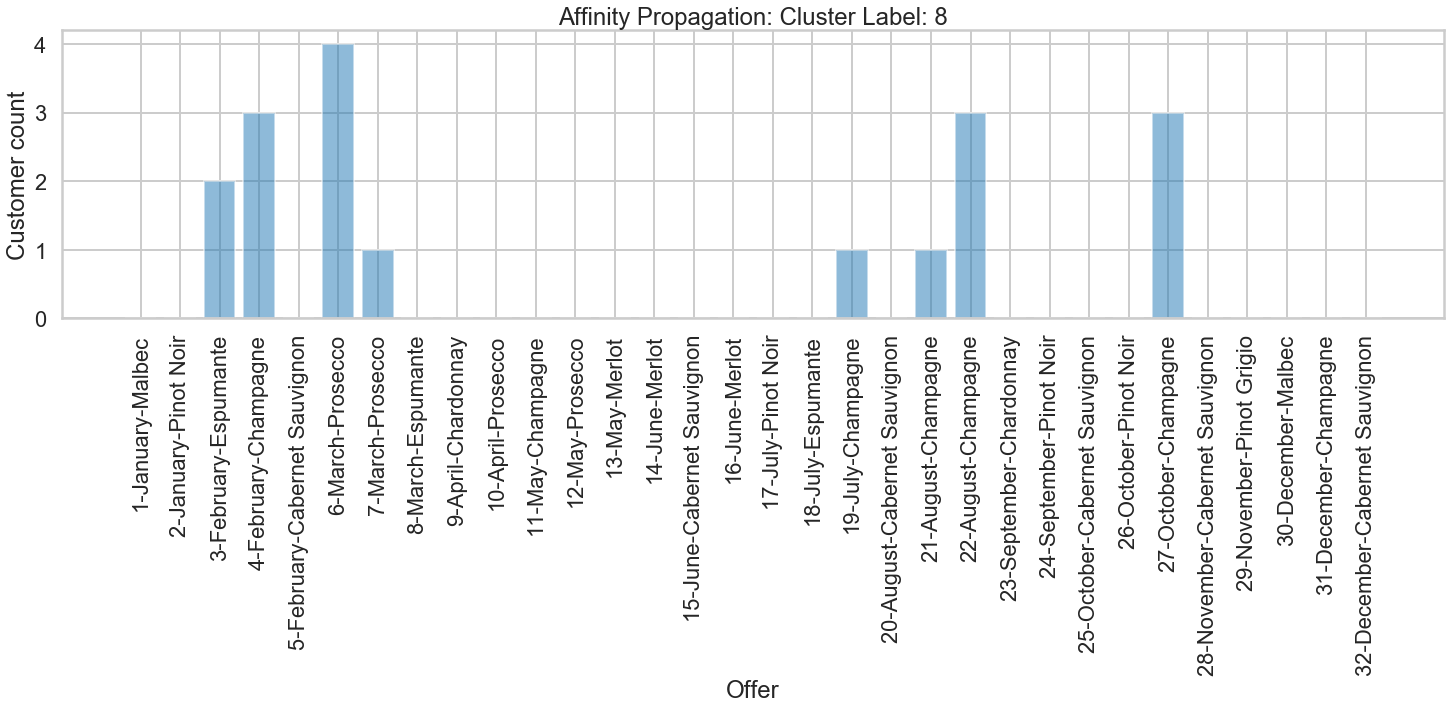

cluster label =  9
                                        n   ct
0                 (n, 1, January, Malbec)  3.0
21             (n, 22, August, Champagne)  3.0
29              (n, 30, December, Malbec)  3.0
27  (n, 28, November, Cabernet Sauvignon)  2.0
30           (n, 31, December, Champagne)  2.0
1             (n, 2, January, Pinot Noir)  1.0
3             (n, 4, February, Champagne)  1.0
10                (n, 11, May, Champagne)  1.0


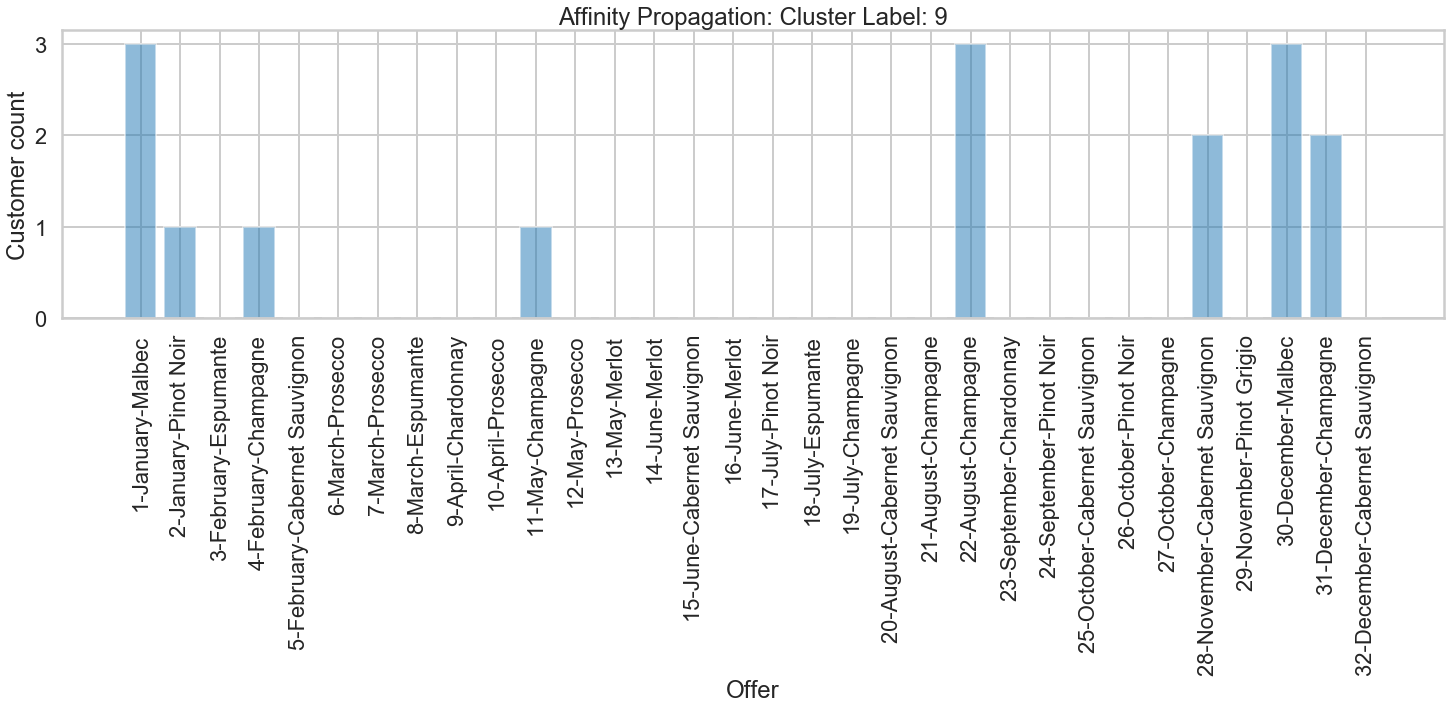

cluster label =  10
                                       n   ct
8              (n, 9, April, Chardonnay)  8.0
0                (n, 1, January, Malbec)  3.0
10               (n, 11, May, Champagne)  3.0
3            (n, 4, February, Champagne)  2.0
13                 (n, 14, June, Merlot)  2.0
15                 (n, 16, June, Merlot)  2.0
22        (n, 23, September, Chardonnay)  2.0
24  (n, 25, October, Cabernet Sauvignon)  2.0
25          (n, 26, October, Pinot Noir)  2.0
26           (n, 27, October, Champagne)  2.0
4   (n, 5, February, Cabernet Sauvignon)  1.0
5                (n, 6, March, Prosecco)  1.0
14     (n, 15, June, Cabernet Sauvignon)  1.0
19   (n, 20, August, Cabernet Sauvignon)  1.0
21            (n, 22, August, Champagne)  1.0
29             (n, 30, December, Malbec)  1.0


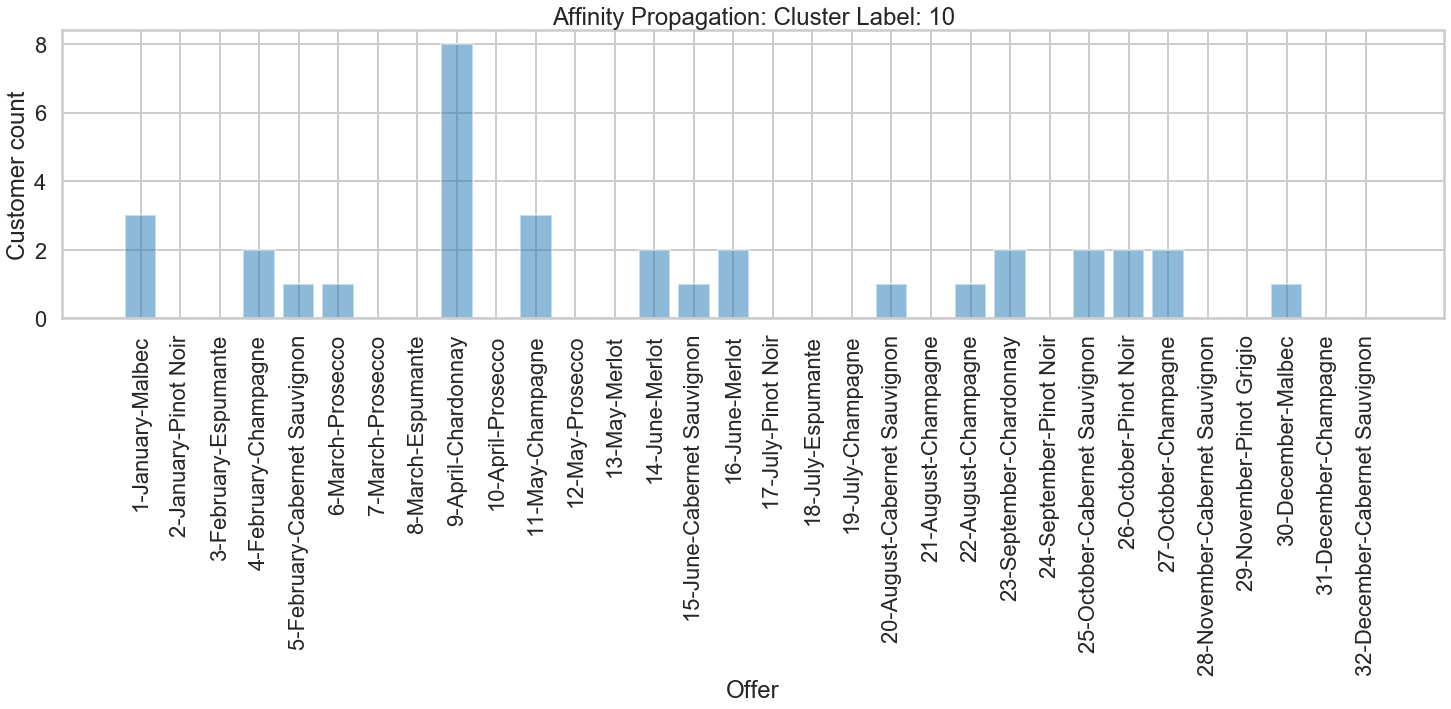

cluster label =  11
                                       n   ct
13                 (n, 14, June, Merlot)  4.0
4   (n, 5, February, Cabernet Sauvignon)  3.0
14     (n, 15, June, Cabernet Sauvignon)  2.0
3            (n, 4, February, Champagne)  1.0
5                (n, 6, March, Prosecco)  1.0
19   (n, 20, August, Cabernet Sauvignon)  1.0
21            (n, 22, August, Champagne)  1.0
22        (n, 23, September, Chardonnay)  1.0
25          (n, 26, October, Pinot Noir)  1.0


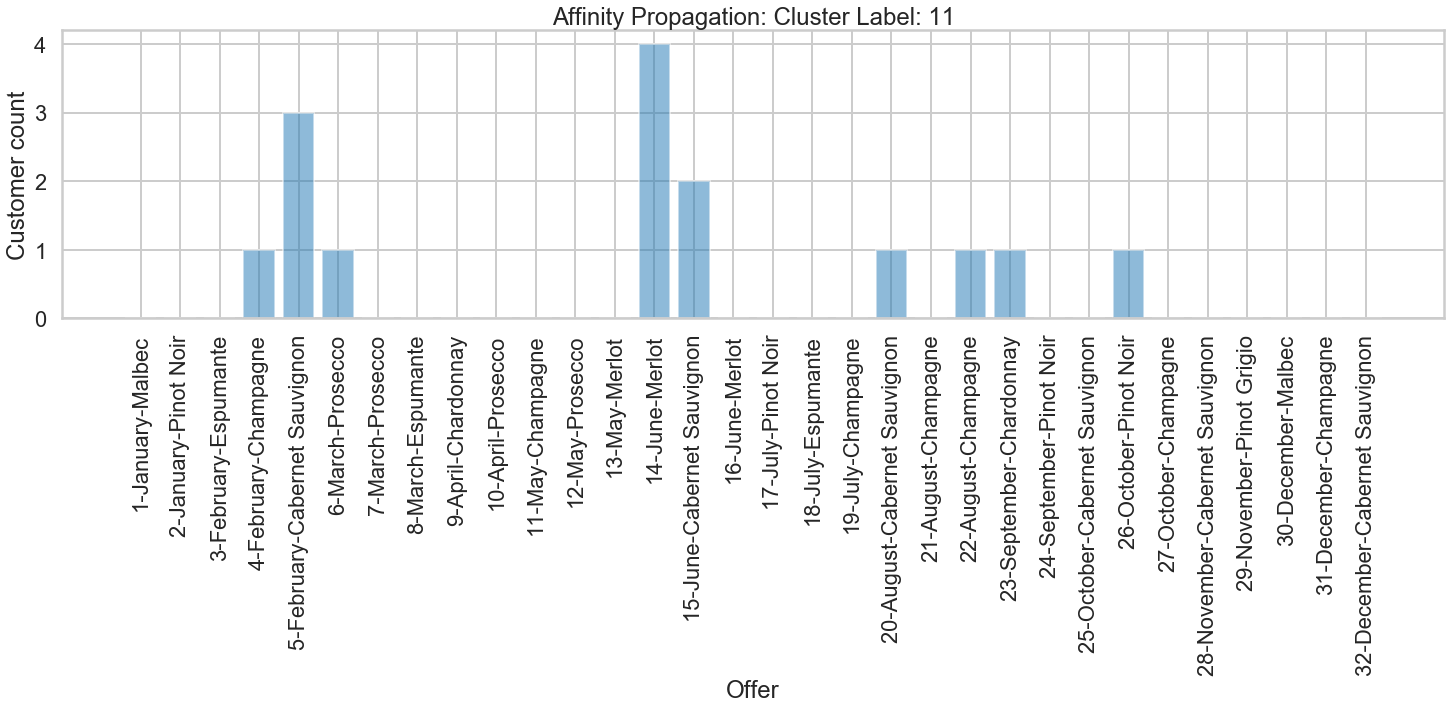

cluster label =  12
                                        n    ct
30           (n, 31, December, Champagne)  12.0
5                 (n, 6, March, Prosecco)   4.0
21             (n, 22, August, Champagne)   4.0
9                (n, 10, April, Prosecco)   3.0
31  (n, 32, December, Cabernet Sauvignon)   2.0
8               (n, 9, April, Chardonnay)   2.0
10                (n, 11, May, Champagne)   2.0
13                  (n, 14, June, Merlot)   2.0
14      (n, 15, June, Cabernet Sauvignon)   2.0
3             (n, 4, February, Champagne)   2.0
19    (n, 20, August, Cabernet Sauvignon)   2.0
26            (n, 27, October, Champagne)   1.0
28        (n, 29, November, Pinot Grigio)   1.0
27  (n, 28, November, Cabernet Sauvignon)   1.0
0                 (n, 1, January, Malbec)   1.0
22         (n, 23, September, Chardonnay)   1.0
20             (n, 21, August, Champagne)   1.0
17               (n, 18, July, Espumante)   1.0
15                  (n, 16, June, Merlot)   1.0
18               (n,

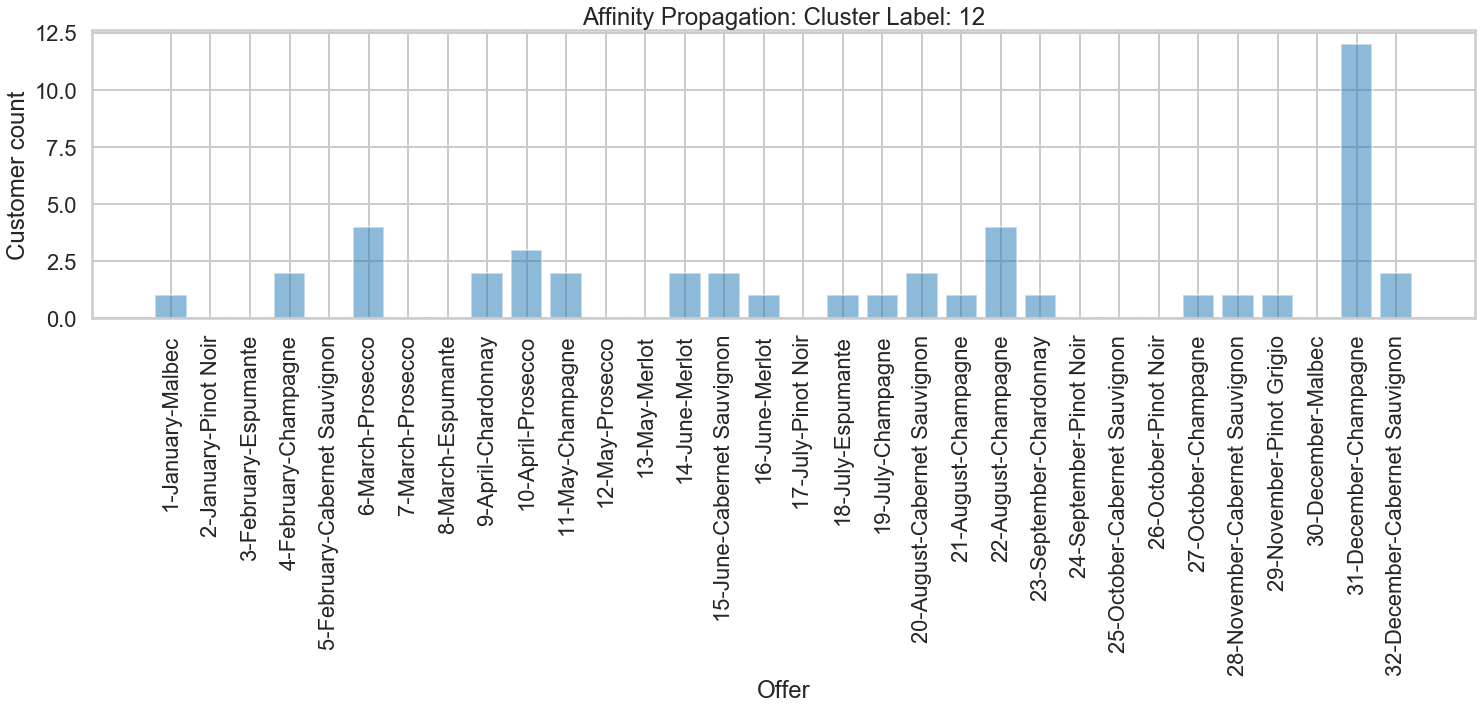

cluster label =  13
                                        n   ct
1             (n, 2, January, Pinot Noir)  6.0
25           (n, 26, October, Pinot Noir)  5.0
0                 (n, 1, January, Malbec)  2.0
23         (n, 24, September, Pinot Noir)  2.0
9                (n, 10, April, Prosecco)  1.0
10                (n, 11, May, Champagne)  1.0
11                 (n, 12, May, Prosecco)  1.0
15                  (n, 16, June, Merlot)  1.0
22         (n, 23, September, Chardonnay)  1.0
26            (n, 27, October, Champagne)  1.0
27  (n, 28, November, Cabernet Sauvignon)  1.0


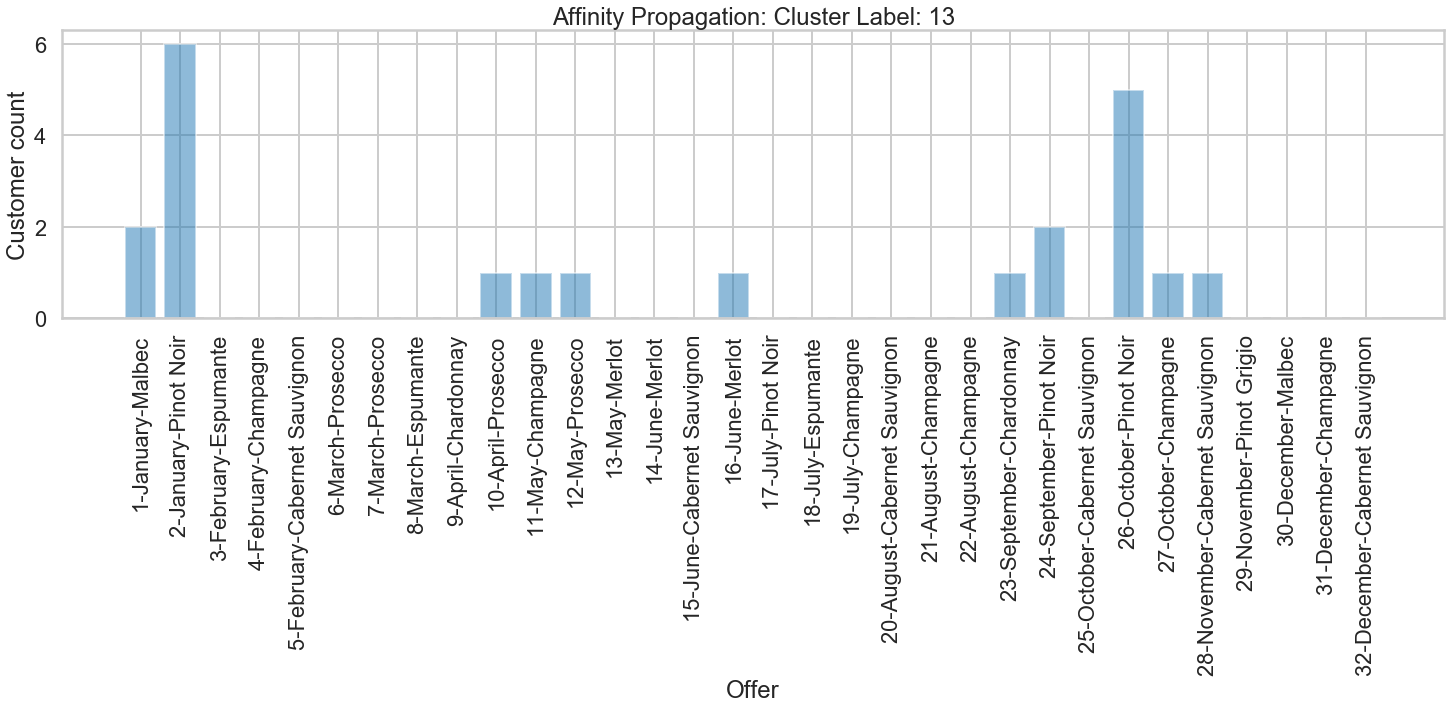

In [77]:
list_ap_clusters =np.sort(combined_data2['AffProp_cluster'].unique())

for cluster in list_ap_clusters:
    exclude_cols = combined_data2.columns[:9].tolist()
    sum_cols = combined_data2.columns[9:].tolist()
    sum_list = combined_data2[combined_data2.AffProp_cluster==cluster].drop(exclude_cols,axis=1).sum().tolist()
    sum_df = pd.DataFrame({'n':sum_cols,'ct':sum_list})
    print("cluster label = ",cluster)
    print(sum_df[sum_df.ct != 0].sort_values(by='ct',ascending=False))
    fig= plt.figure(figsize=(24,5))
    axes= fig.add_axes([0.1,0.1,0.8,0.8])
    n_list = []
    offer_list = []
    for n in sum_cols:
        n_list.append(n[1])
        offer_list.append(str(n[1])+"-"+n[2]+"-"+n[3])
    axes.bar(offer_list, sum_df['ct'], align='center',alpha=0.5)
    plt_title = "Affinity Propagation: Cluster Label: "+str(cluster)
    plt.title(plt_title)
    plt.xlabel('Offer')
    plt.ylabel('Customer count')
    plt.xticks(rotation=90)
    plt.show()

cluster label =  0


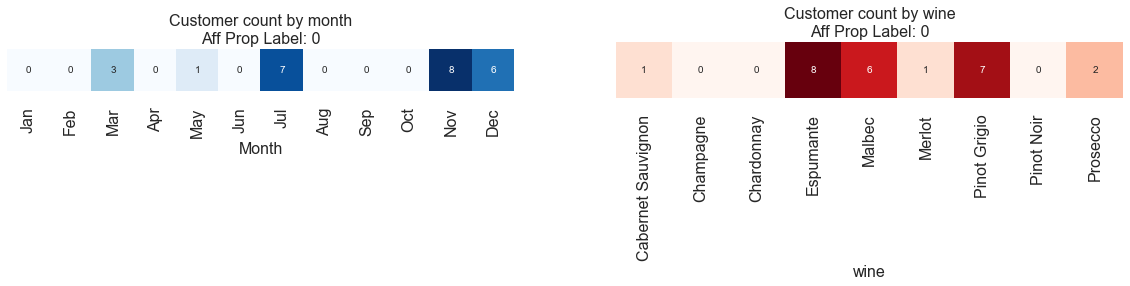

<Figure size 720x216 with 0 Axes>

<Figure size 720x216 with 0 Axes>

cluster label =  1


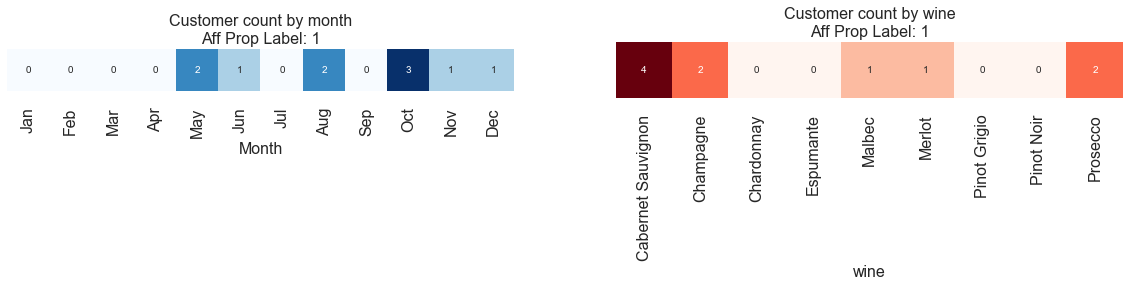

<Figure size 720x216 with 0 Axes>

<Figure size 720x216 with 0 Axes>

cluster label =  2


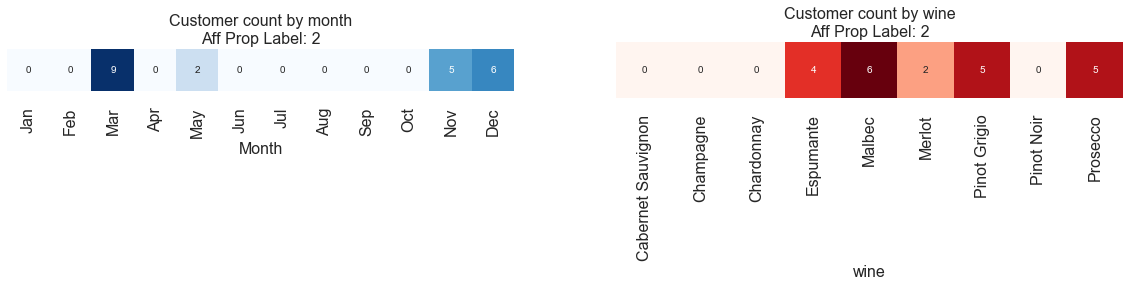

<Figure size 720x216 with 0 Axes>

<Figure size 720x216 with 0 Axes>

cluster label =  3


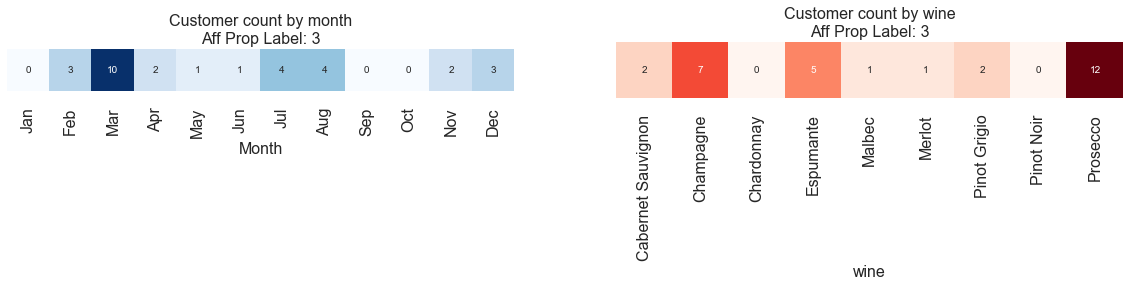

<Figure size 720x216 with 0 Axes>

<Figure size 720x216 with 0 Axes>

cluster label =  4


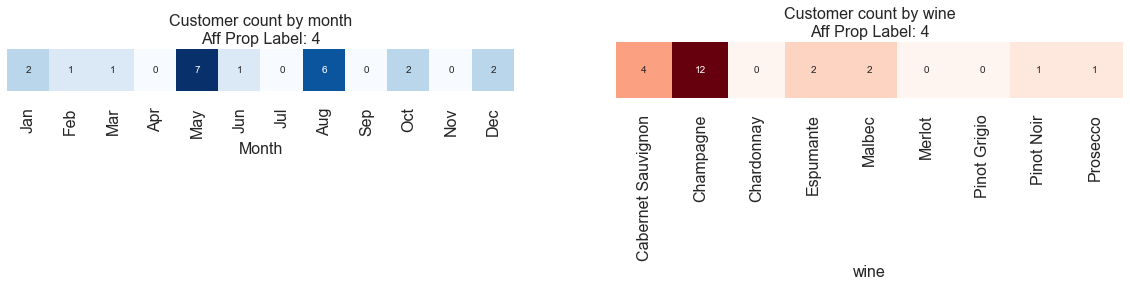

<Figure size 720x216 with 0 Axes>

<Figure size 720x216 with 0 Axes>

cluster label =  5


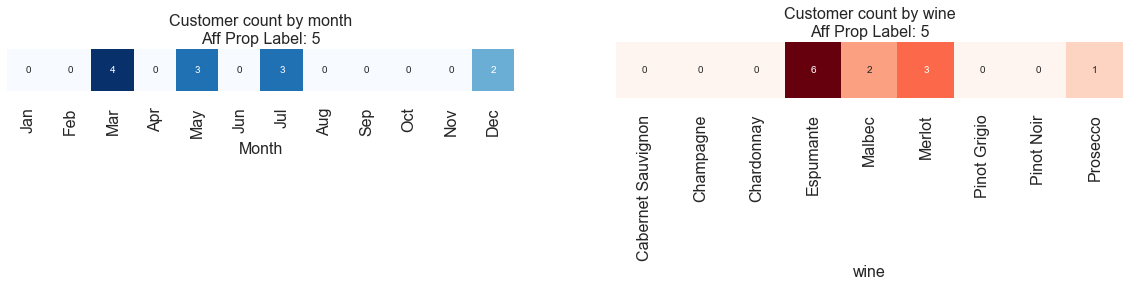

<Figure size 720x216 with 0 Axes>

<Figure size 720x216 with 0 Axes>

cluster label =  6


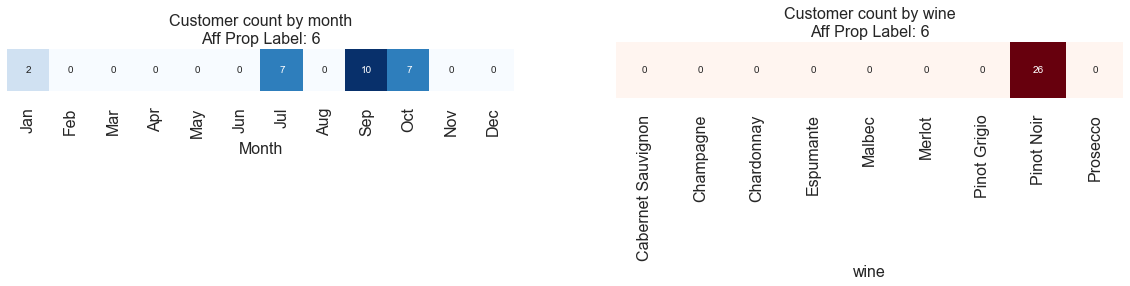

<Figure size 720x216 with 0 Axes>

<Figure size 720x216 with 0 Axes>

cluster label =  7


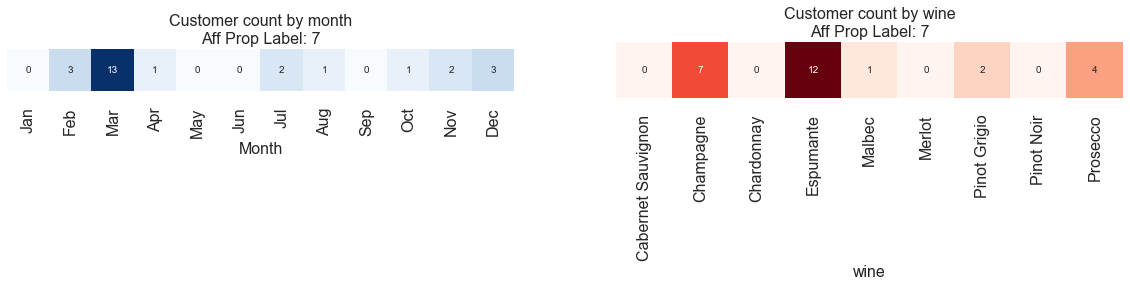

<Figure size 720x216 with 0 Axes>

<Figure size 720x216 with 0 Axes>

cluster label =  8


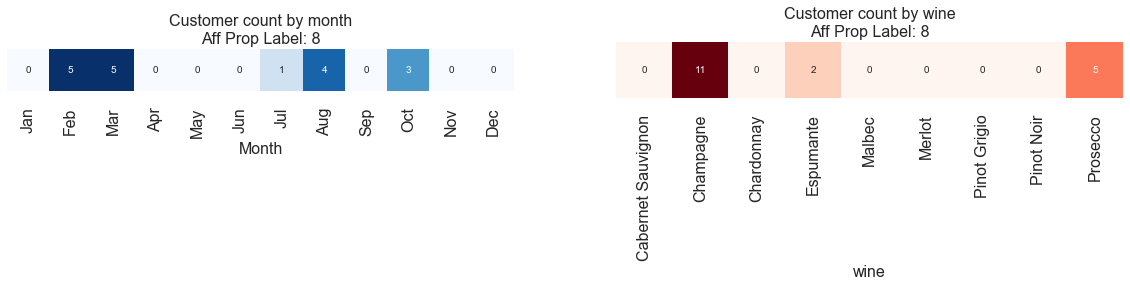

<Figure size 720x216 with 0 Axes>

<Figure size 720x216 with 0 Axes>

cluster label =  9


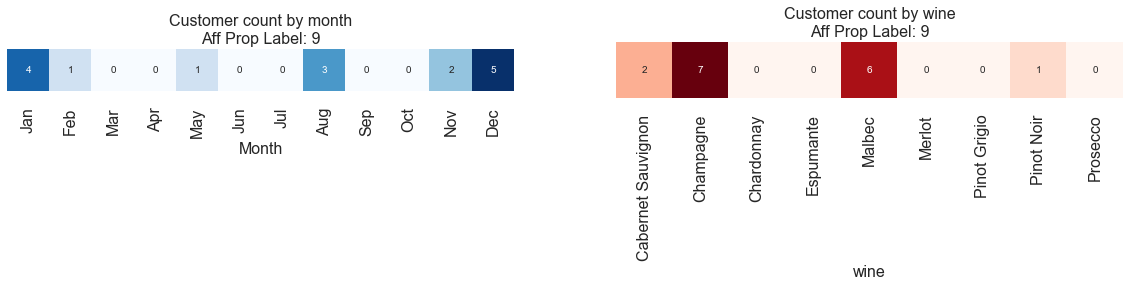

<Figure size 720x216 with 0 Axes>

<Figure size 720x216 with 0 Axes>

cluster label =  10


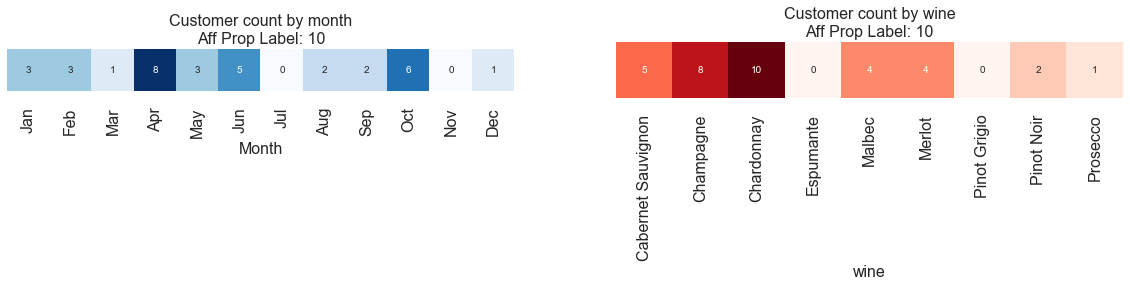

<Figure size 720x216 with 0 Axes>

<Figure size 720x216 with 0 Axes>

cluster label =  11


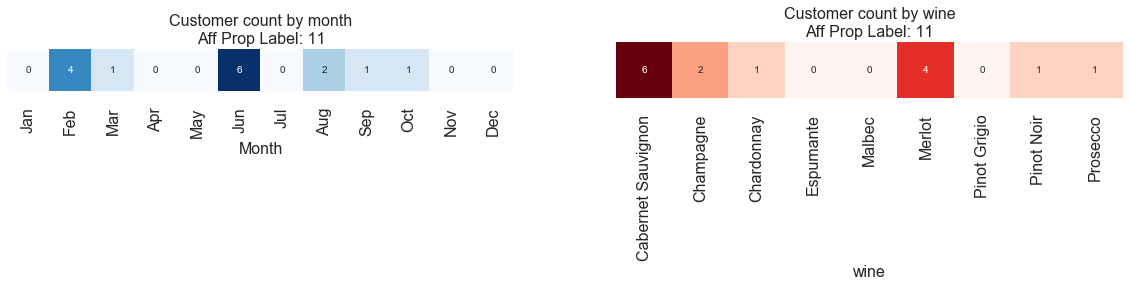

<Figure size 720x216 with 0 Axes>

<Figure size 720x216 with 0 Axes>

cluster label =  12


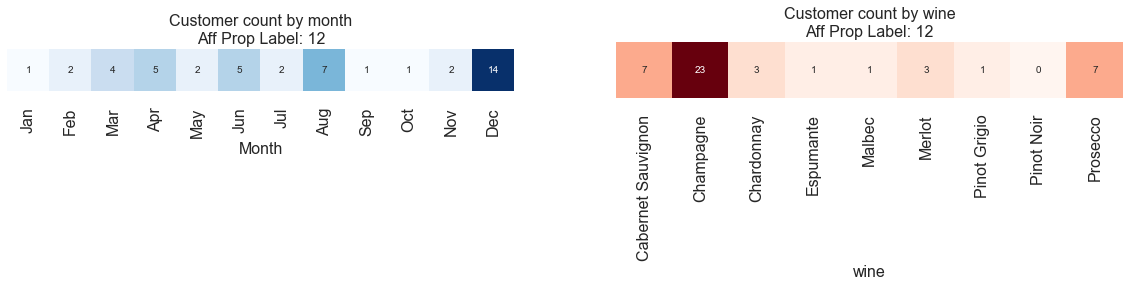

<Figure size 720x216 with 0 Axes>

<Figure size 720x216 with 0 Axes>

cluster label =  13


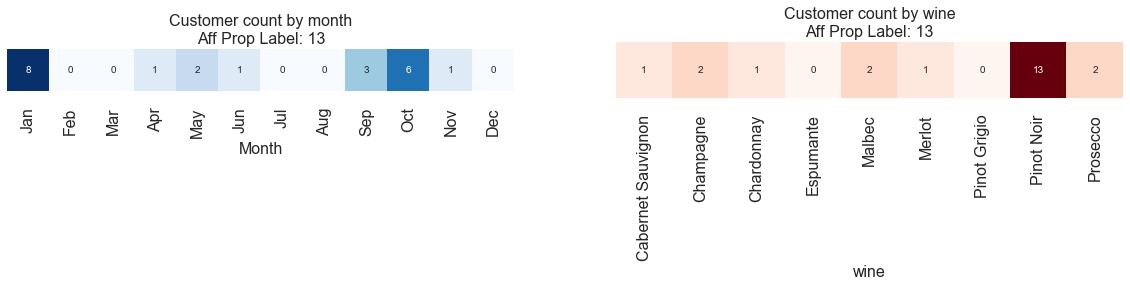

<Figure size 720x216 with 0 Axes>

<Figure size 720x216 with 0 Axes>

In [78]:
for cluster in list_ap_clusters:
    exclude_cols = combined_data2.columns[:9].tolist()
    sum_cols = combined_data2.columns[9:].tolist()
    sum_list = combined_data2[combined_data2.AffProp_cluster==cluster].drop(exclude_cols,axis=1).sum().tolist()
    sum_df = pd.DataFrame({'n':sum_cols,'ct':sum_list})
    print("cluster label = ",cluster)
    #print(sum_df[sum_df.ct != 0].sort_values(by='ct',ascending=False))

    # get lists of months and wines from sum_df
    list_month =[]
    list_wine = []
    for col in sum_cols:
        list_month.append(col[2])
        list_wine.append(col[3])
    sum_df['month'] = list_month
    sum_df['wine'] = list_wine
    sum_df['month'] = pd.to_datetime(sum_df.month, format='%B', errors='coerce').dt.month

    # to examine purchasing customers in each month: groupby month, count customers
    combined_month_ct = sum_df.groupby('month').sum()
    #print(combined_month_ct)
    
    # to examine purchasing customers by wine type; groupby wine, count customers
    combined_wine_ct = sum_df.drop(['month'],axis=1).groupby('wine').sum()
    #print(combined_wine_ct)
    
    # print 1D heatmap for each
    f = plt.figure(figsize=(20,3))

    ax1 = f.add_subplot(121)
    ax2 = f.add_subplot(122)

    plt_title1 = "Customer count by month\nAff Prop Label: "+str(cluster)
    x_axlabels1 = []
    for n in combined_month_ct.index:
        x_axlabels1.append(calendar.month_abbr[n])
    g1 = plt.figure(figsize=(10,3))
    g1 = sns.heatmap([combined_month_ct['ct']], cmap='Blues', annot=True, yticklabels=False, cbar=False, ax=ax1, square=True)
    g1.set_title(plt_title1,fontsize=16)
    g1.set_xlabel('Month',fontsize=16)
    g1.set_xticklabels(x_axlabels1, fontsize=16, rotation=90)

    plt_title2 = "Customer count by wine\nAff Prop Label: "+str(cluster)
    x_axlabels2 = np.array(combined_wine_ct.index)
    g2 = plt.figure(figsize=(10,3))
    g2 = sns.heatmap([combined_wine_ct['ct']], cmap='Reds', annot=True, yticklabels=False, cbar=False, ax=ax2, square=True)
    g2.set_title(plt_title2,fontsize=16)
    g2.set_xlabel('wine',fontsize=16)
    g2.set_xticklabels(x_axlabels2, fontsize=16, rotation=90)

    plt.show()

cluster label =  0
                                  n    ct
29        (n, 30, December, Malbec)  13.0
6           (n, 7, March, Prosecco)  12.0
28  (n, 29, November, Pinot Grigio)  12.0
17         (n, 18, July, Espumante)   9.0
7          (n, 8, March, Espumante)   5.0
12             (n, 13, May, Merlot)   4.0


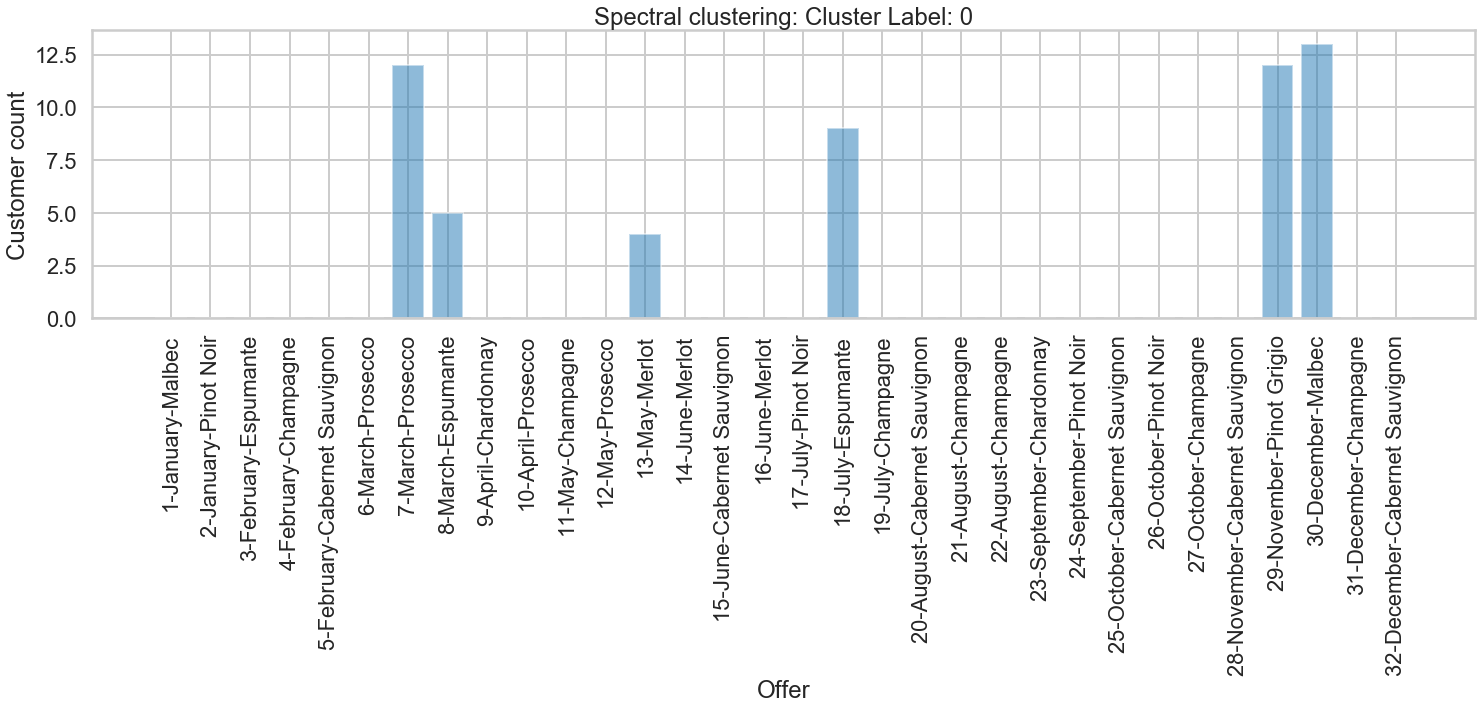

cluster label =  1
                                 n    ct
23  (n, 24, September, Pinot Noir)  12.0
25    (n, 26, October, Pinot Noir)  10.0
16       (n, 17, July, Pinot Noir)   7.0
1      (n, 2, January, Pinot Noir)   5.0


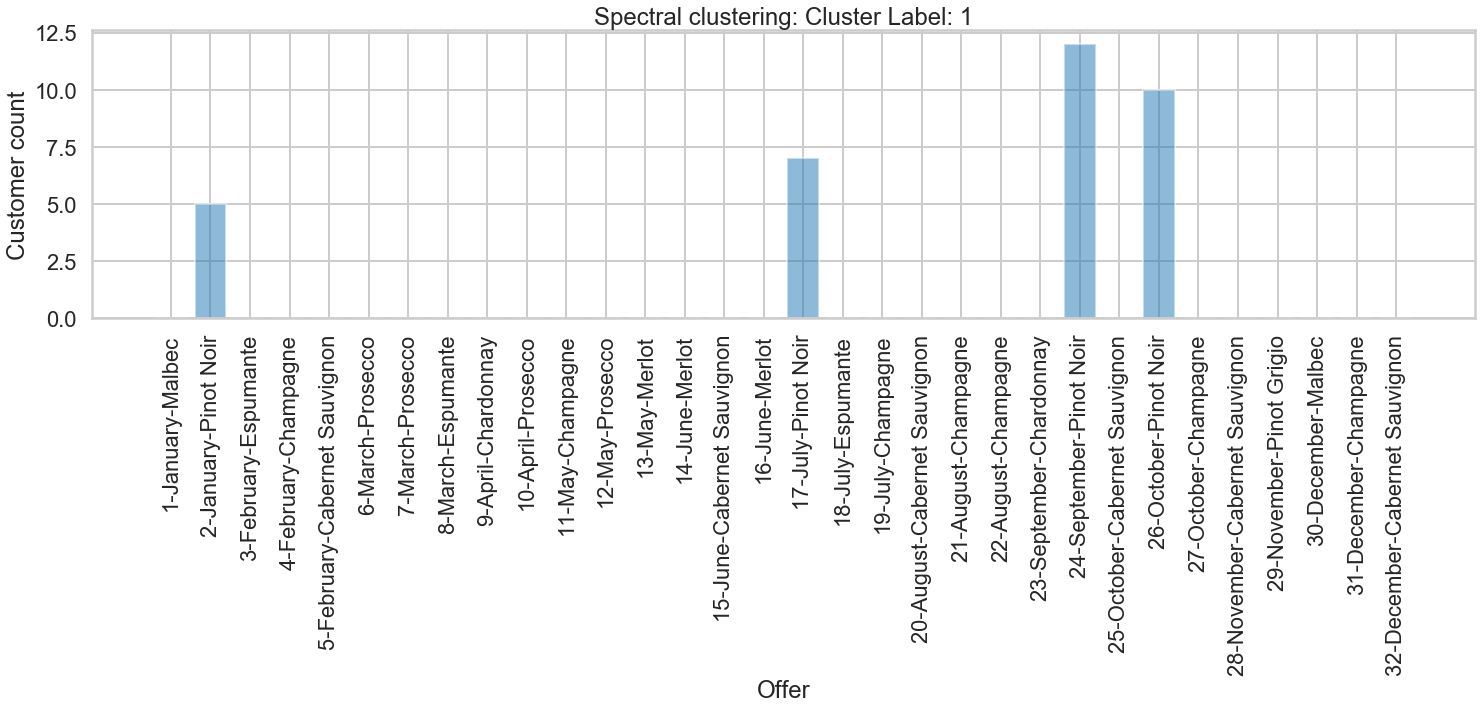

cluster label =  2
                               n   ct
5        (n, 6, March, Prosecco)  6.0
21    (n, 22, August, Champagne)  5.0
3    (n, 4, February, Champagne)  4.0
26   (n, 27, October, Champagne)  4.0
2    (n, 3, February, Espumante)  3.0
6        (n, 7, March, Prosecco)  3.0
18      (n, 19, July, Champagne)  3.0
7       (n, 8, March, Espumante)  2.0
20    (n, 21, August, Champagne)  2.0
30  (n, 31, December, Champagne)  2.0


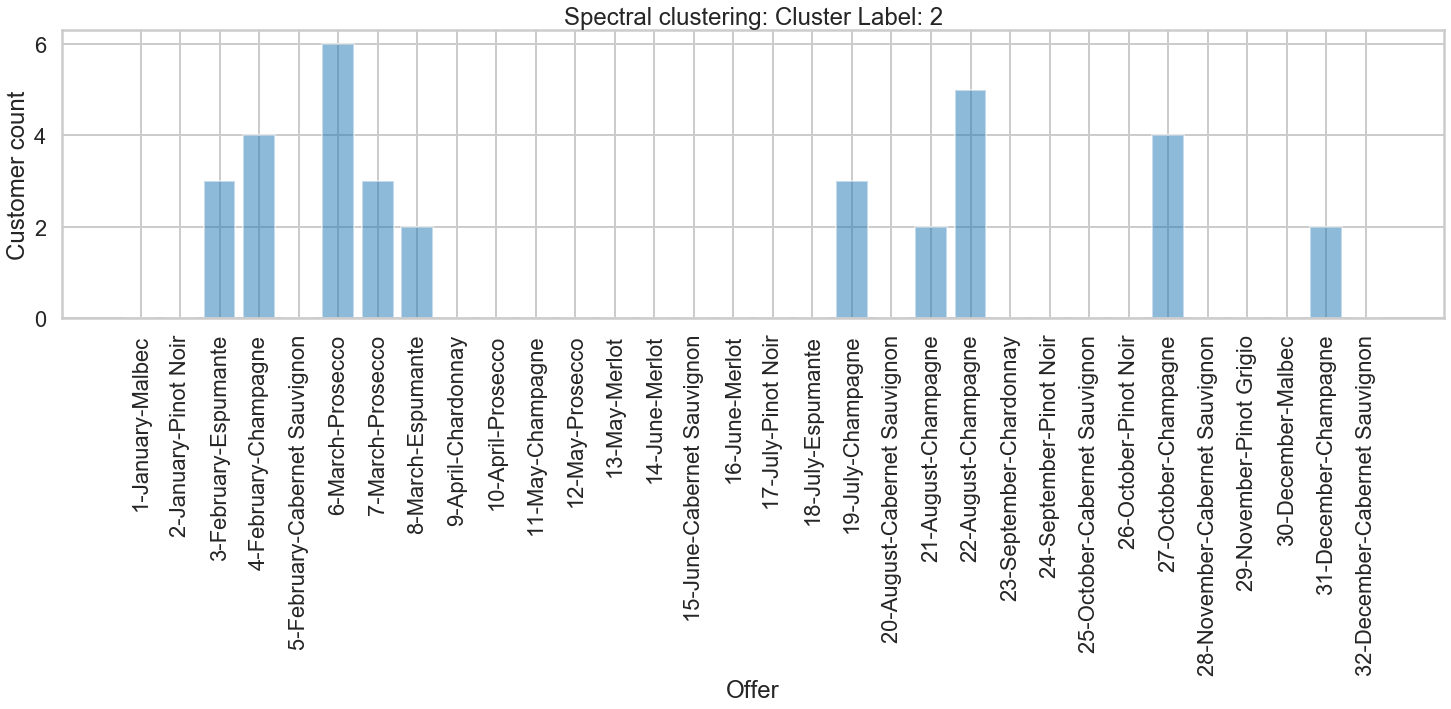

cluster label =  3
                                  n    ct
7          (n, 8, March, Espumante)  12.0
17         (n, 18, July, Espumante)   3.0
28  (n, 29, November, Pinot Grigio)   3.0
29        (n, 30, December, Malbec)   3.0
12             (n, 13, May, Merlot)   2.0
2       (n, 3, February, Espumante)   1.0
3       (n, 4, February, Champagne)   1.0
5           (n, 6, March, Prosecco)   1.0
9          (n, 10, April, Prosecco)   1.0
26      (n, 27, October, Champagne)   1.0
30     (n, 31, December, Champagne)   1.0


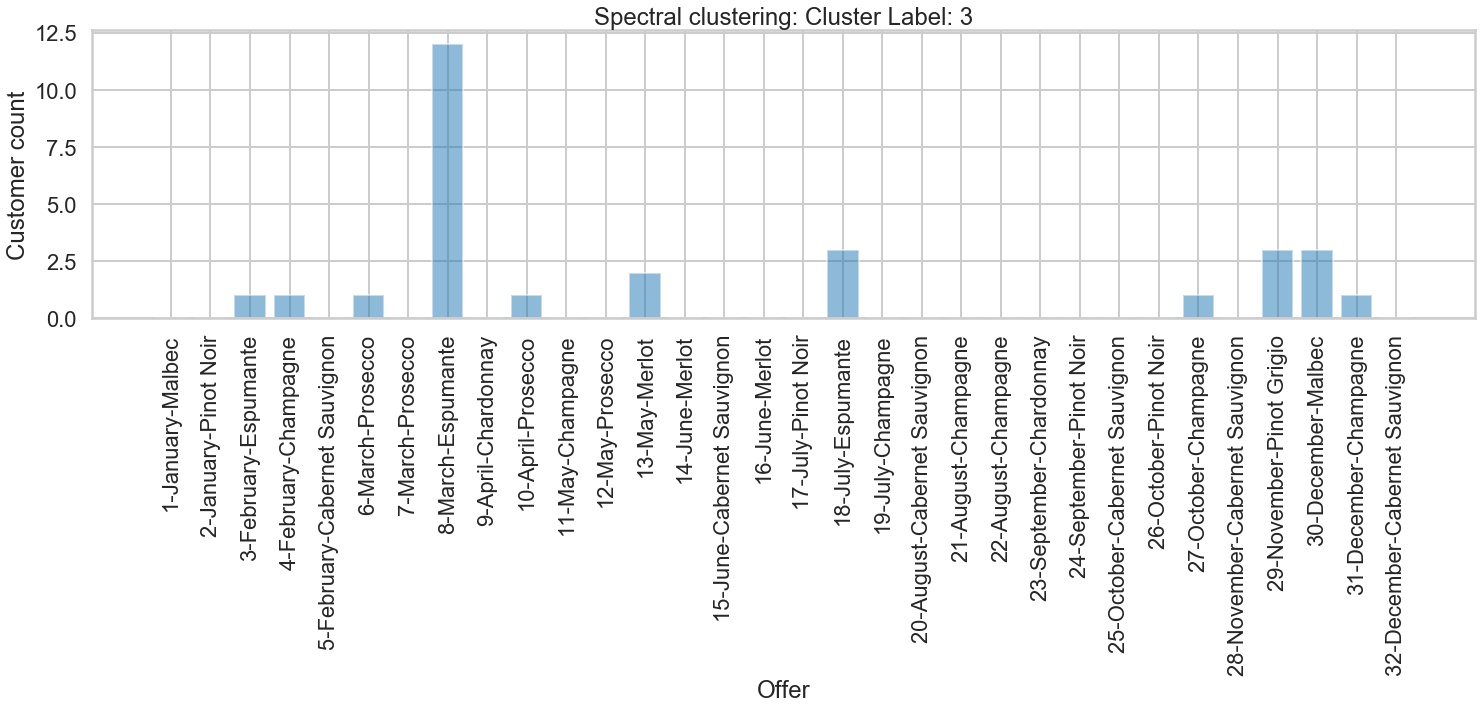

cluster label =  4
                                        n    ct
21             (n, 22, August, Champagne)  16.0
30           (n, 31, December, Champagne)  14.0
10                (n, 11, May, Champagne)  13.0
0                 (n, 1, January, Malbec)  10.0
8               (n, 9, April, Chardonnay)  10.0
13                  (n, 14, June, Merlot)   9.0
3             (n, 4, February, Champagne)   7.0
19    (n, 20, August, Cabernet Sauvignon)   6.0
29              (n, 30, December, Malbec)   6.0
27  (n, 28, November, Cabernet Sauvignon)   6.0
24   (n, 25, October, Cabernet Sauvignon)   6.0
9                (n, 10, April, Prosecco)   6.0
14      (n, 15, June, Cabernet Sauvignon)   6.0
25           (n, 26, October, Pinot Noir)   5.0
22         (n, 23, September, Chardonnay)   5.0
15                  (n, 16, June, Merlot)   5.0
1             (n, 2, January, Pinot Noir)   5.0
11                 (n, 12, May, Prosecco)   5.0
5                 (n, 6, March, Prosecco)   5.0
6                 (n,

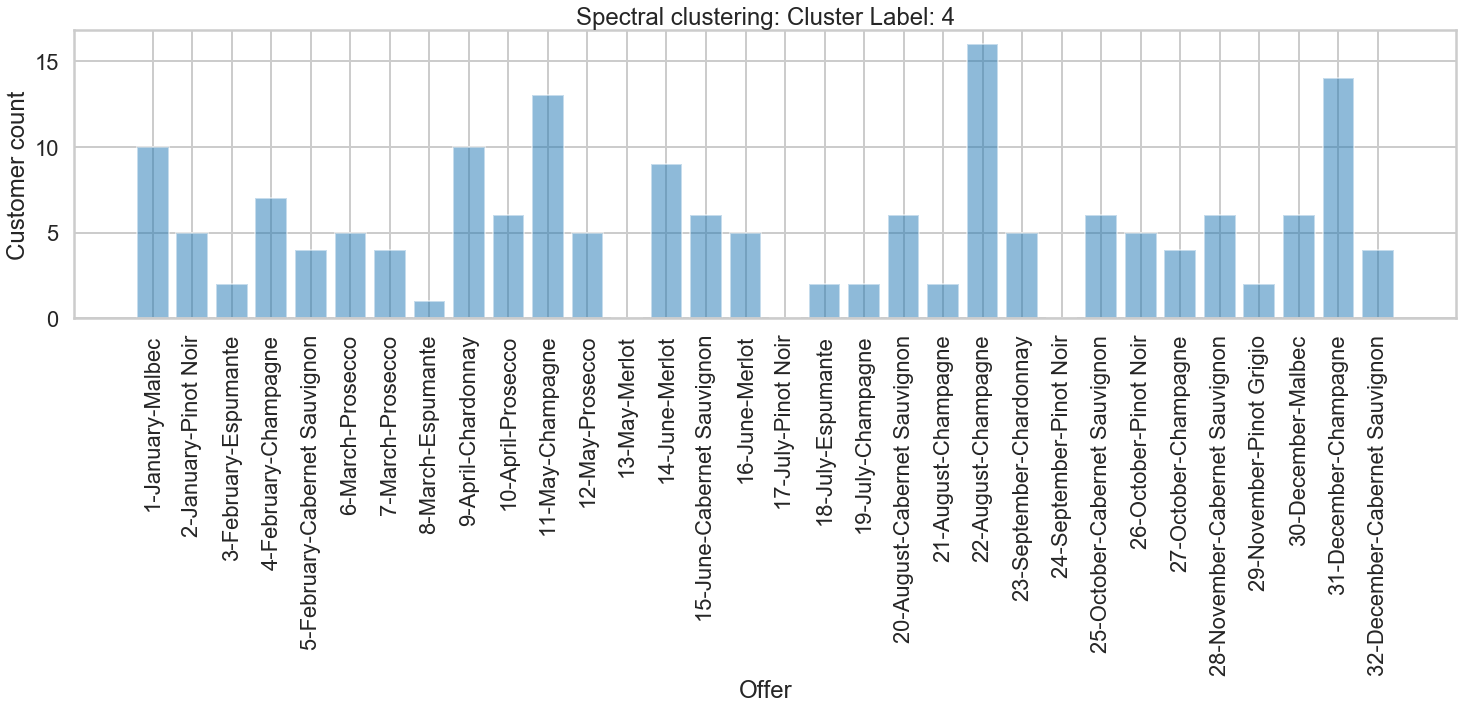

In [79]:
list_sc_clusters =np.sort(combined_data2['Spectral_cluster'].unique())

for cluster in list_sc_clusters:
    exclude_cols = combined_data2.columns[:9].tolist()
    sum_cols = combined_data2.columns[9:].tolist()
    sum_list = combined_data2[combined_data2.Spectral_cluster==cluster].drop(exclude_cols,axis=1).sum().tolist()
    sum_df = pd.DataFrame({'n':sum_cols,'ct':sum_list})
    print("cluster label = ",cluster)
    print(sum_df[sum_df.ct != 0].sort_values(by='ct',ascending=False))
    fig= plt.figure(figsize=(24,5))
    axes= fig.add_axes([0.1,0.1,0.8,0.8])
    n_list = []
    offer_list = []
    for n in sum_cols:
        n_list.append(n[1])
        offer_list.append(str(n[1])+"-"+n[2]+"-"+n[3])
    axes.bar(offer_list, sum_df['ct'], align='center',alpha=0.5)
    plt_title = "Spectral clustering: Cluster Label: "+str(cluster)
    plt.title(plt_title)
    plt.xlabel('Offer')
    plt.ylabel('Customer count')
    plt.xticks(rotation=90)
    plt.show()

cluster label =  0


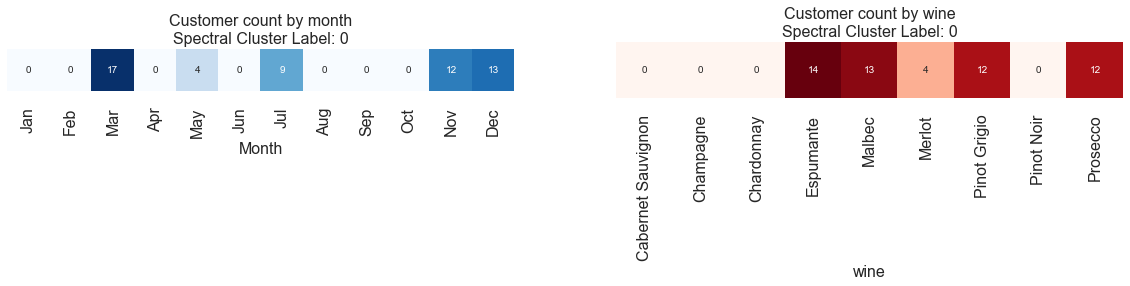

<Figure size 720x216 with 0 Axes>

<Figure size 720x216 with 0 Axes>

cluster label =  1


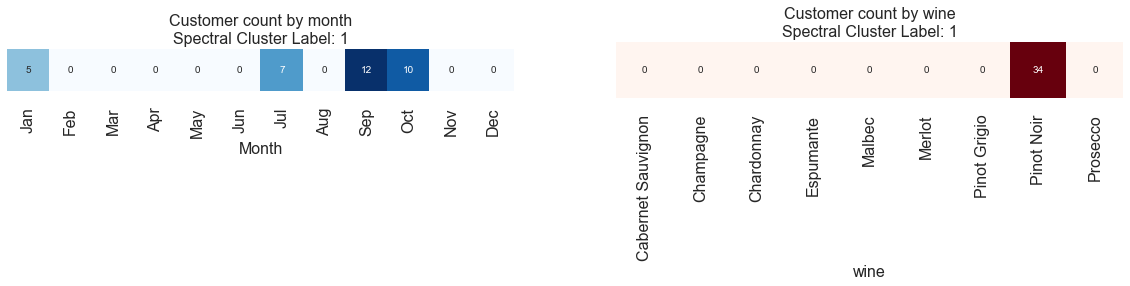

<Figure size 720x216 with 0 Axes>

<Figure size 720x216 with 0 Axes>

cluster label =  2


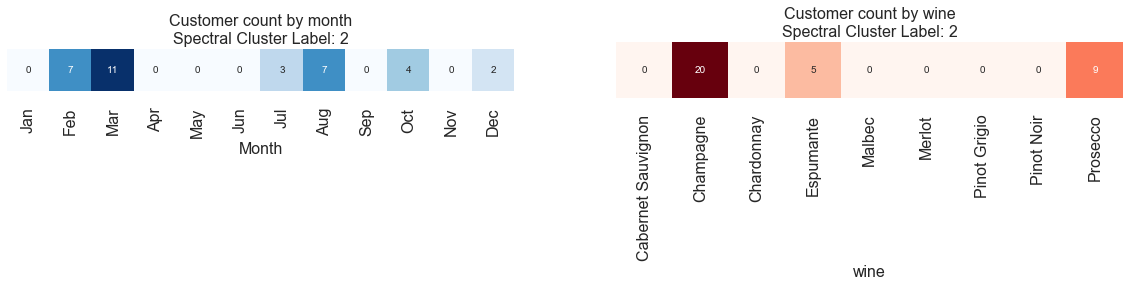

<Figure size 720x216 with 0 Axes>

<Figure size 720x216 with 0 Axes>

cluster label =  3


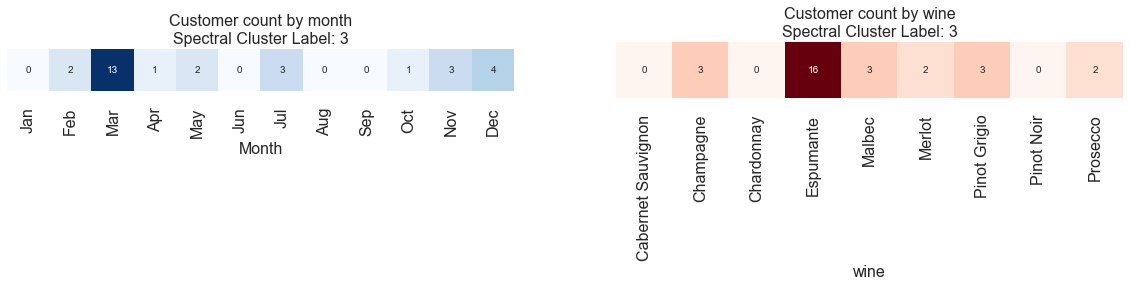

<Figure size 720x216 with 0 Axes>

<Figure size 720x216 with 0 Axes>

cluster label =  4


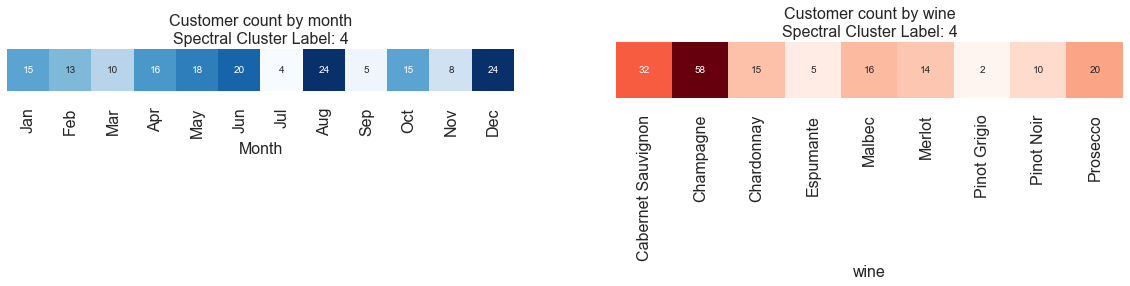

<Figure size 720x216 with 0 Axes>

<Figure size 720x216 with 0 Axes>

In [80]:
for cluster in list_sc_clusters:
    exclude_cols = combined_data2.columns[:9].tolist()
    sum_cols = combined_data2.columns[9:].tolist()
    sum_list = combined_data2[combined_data2.Spectral_cluster==cluster].drop(exclude_cols,axis=1).sum().tolist()
    sum_df = pd.DataFrame({'n':sum_cols,'ct':sum_list})
    print("cluster label = ",cluster)
    #print(sum_df[sum_df.ct != 0].sort_values(by='ct',ascending=False))

    # get lists of months and wines from sum_df
    list_month =[]
    list_wine = []
    for col in sum_cols:
        list_month.append(col[2])
        list_wine.append(col[3])
    sum_df['month'] = list_month
    sum_df['wine'] = list_wine
    sum_df['month'] = pd.to_datetime(sum_df.month, format='%B', errors='coerce').dt.month

    # to examine purchasing customers in each month: groupby month, count customers
    combined_month_ct = sum_df.groupby('month').sum()
    #print(combined_month_ct)
    
    # to examine purchasing customers by wine type; groupby wine, count customers
    combined_wine_ct = sum_df.drop(['month'],axis=1).groupby('wine').sum()
    #print(combined_wine_ct)
    
    # print 1D heatmap for each
    f = plt.figure(figsize=(20,3))

    ax1 = f.add_subplot(121)
    ax2 = f.add_subplot(122)

    plt_title1 = "Customer count by month\nSpectral Cluster Label: "+str(cluster)
    x_axlabels1 = []
    for n in combined_month_ct.index:
        x_axlabels1.append(calendar.month_abbr[n])
    g1 = plt.figure(figsize=(10,3))
    g1 = sns.heatmap([combined_month_ct['ct']], cmap='Blues', annot=True, yticklabels=False, cbar=False, ax=ax1, square=True)
    g1.set_title(plt_title1,fontsize=16)
    g1.set_xlabel('Month',fontsize=16)
    g1.set_xticklabels(x_axlabels1, fontsize=16, rotation=90)

    plt_title2 = "Customer count by wine\nSpectral Cluster Label: "+str(cluster)
    x_axlabels2 = np.array(combined_wine_ct.index)
    g2 = plt.figure(figsize=(10,3))
    g2 = sns.heatmap([combined_wine_ct['ct']], cmap='Reds', annot=True, yticklabels=False, cbar=False, ax=ax2, square=True)
    g2.set_title(plt_title2,fontsize=16)
    g2.set_xlabel('wine',fontsize=16)
    g2.set_xticklabels(x_axlabels2, fontsize=16, rotation=90)

    plt.show()

cluster label =  0
                                        n   ct
21             (n, 22, August, Champagne)  9.0
0                 (n, 1, January, Malbec)  7.0
10                (n, 11, May, Champagne)  7.0
3             (n, 4, February, Champagne)  4.0
8               (n, 9, April, Chardonnay)  3.0
29              (n, 30, December, Malbec)  3.0
25           (n, 26, October, Pinot Noir)  3.0
13                  (n, 14, June, Merlot)  3.0
1             (n, 2, January, Pinot Noir)  2.0
14      (n, 15, June, Cabernet Sauvignon)  2.0
19    (n, 20, August, Cabernet Sauvignon)  2.0
4    (n, 5, February, Cabernet Sauvignon)  2.0
27  (n, 28, November, Cabernet Sauvignon)  2.0
30           (n, 31, December, Champagne)  2.0
7                (n, 8, March, Espumante)  1.0
11                 (n, 12, May, Prosecco)  1.0
5                 (n, 6, March, Prosecco)  1.0
22         (n, 23, September, Chardonnay)  1.0
24   (n, 25, October, Cabernet Sauvignon)  1.0
2             (n, 3, February, Espumante)

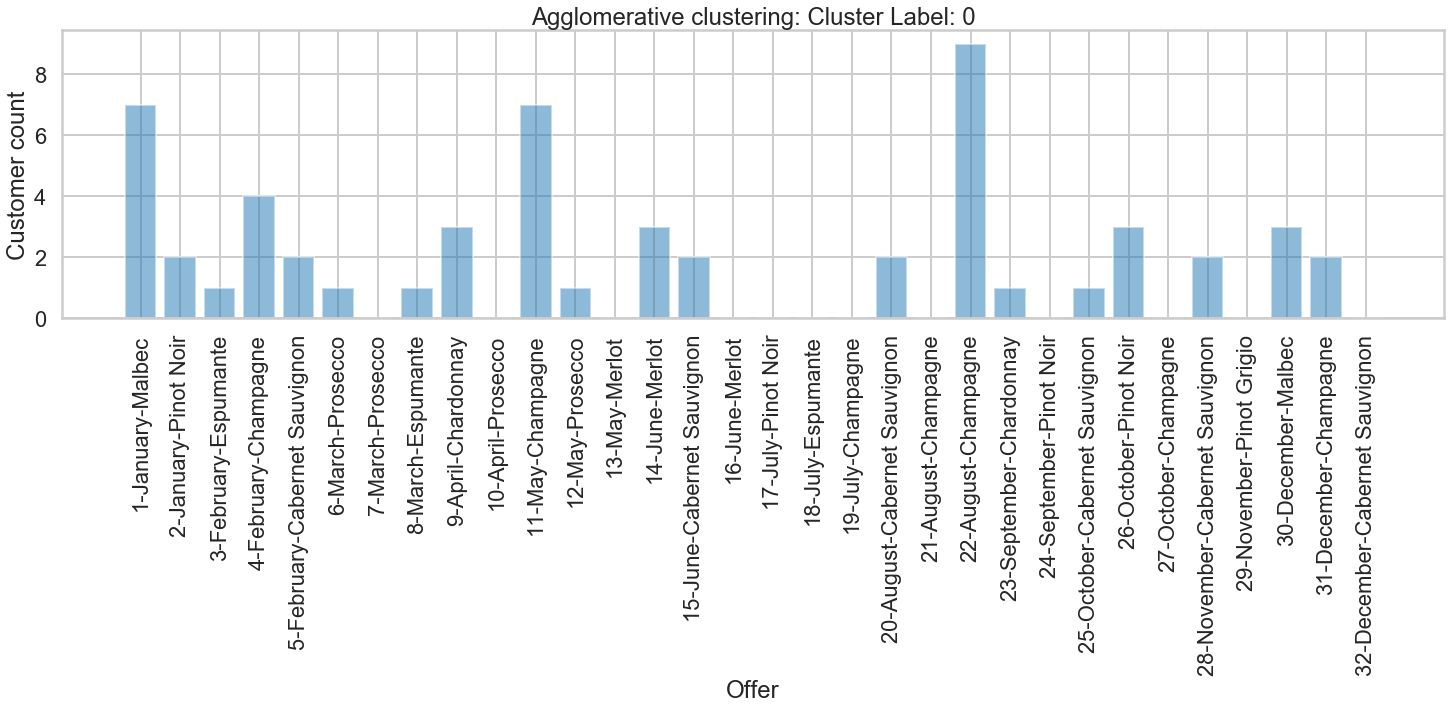

cluster label =  1
                                        n    ct
30           (n, 31, December, Champagne)  13.0
8               (n, 9, April, Chardonnay)   7.0
21             (n, 22, August, Champagne)   6.0
13                  (n, 14, June, Merlot)   6.0
10                (n, 11, May, Champagne)   5.0
24   (n, 25, October, Cabernet Sauvignon)   5.0
9                (n, 10, April, Prosecco)   5.0
15                  (n, 16, June, Merlot)   4.0
19    (n, 20, August, Cabernet Sauvignon)   4.0
14      (n, 15, June, Cabernet Sauvignon)   4.0
31  (n, 32, December, Cabernet Sauvignon)   4.0
5                 (n, 6, March, Prosecco)   4.0
3             (n, 4, February, Champagne)   4.0
22         (n, 23, September, Chardonnay)   3.0
27  (n, 28, November, Cabernet Sauvignon)   3.0
11                 (n, 12, May, Prosecco)   2.0
2             (n, 3, February, Espumante)   2.0
29              (n, 30, December, Malbec)   2.0
26            (n, 27, October, Champagne)   2.0
4    (n, 5, February,

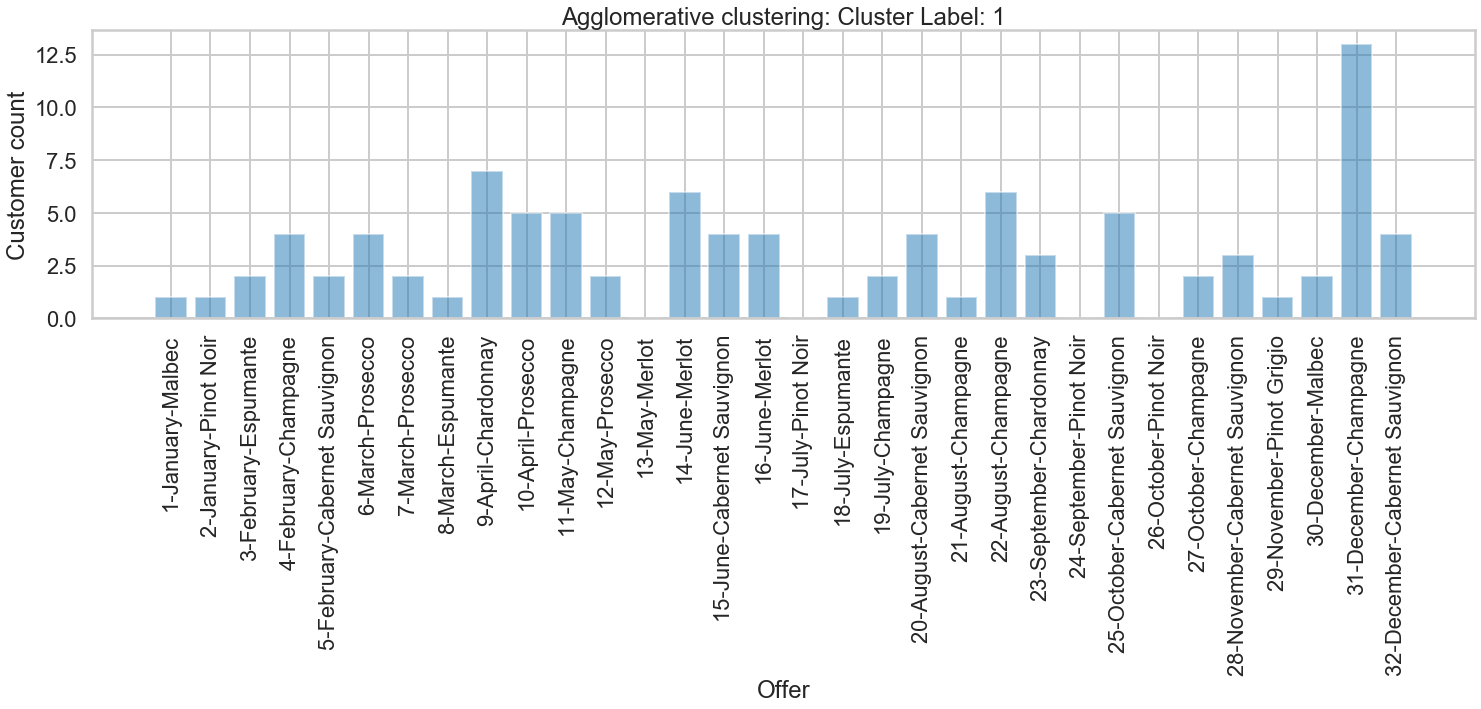

cluster label =  2
                                 n    ct
23  (n, 24, September, Pinot Noir)  12.0
25    (n, 26, October, Pinot Noir)  12.0
1      (n, 2, January, Pinot Noir)   7.0
16       (n, 17, July, Pinot Noir)   7.0
0          (n, 1, January, Malbec)   2.0
9         (n, 10, April, Prosecco)   1.0
11          (n, 12, May, Prosecco)   1.0
15           (n, 16, June, Merlot)   1.0
22  (n, 23, September, Chardonnay)   1.0
26     (n, 27, October, Champagne)   1.0


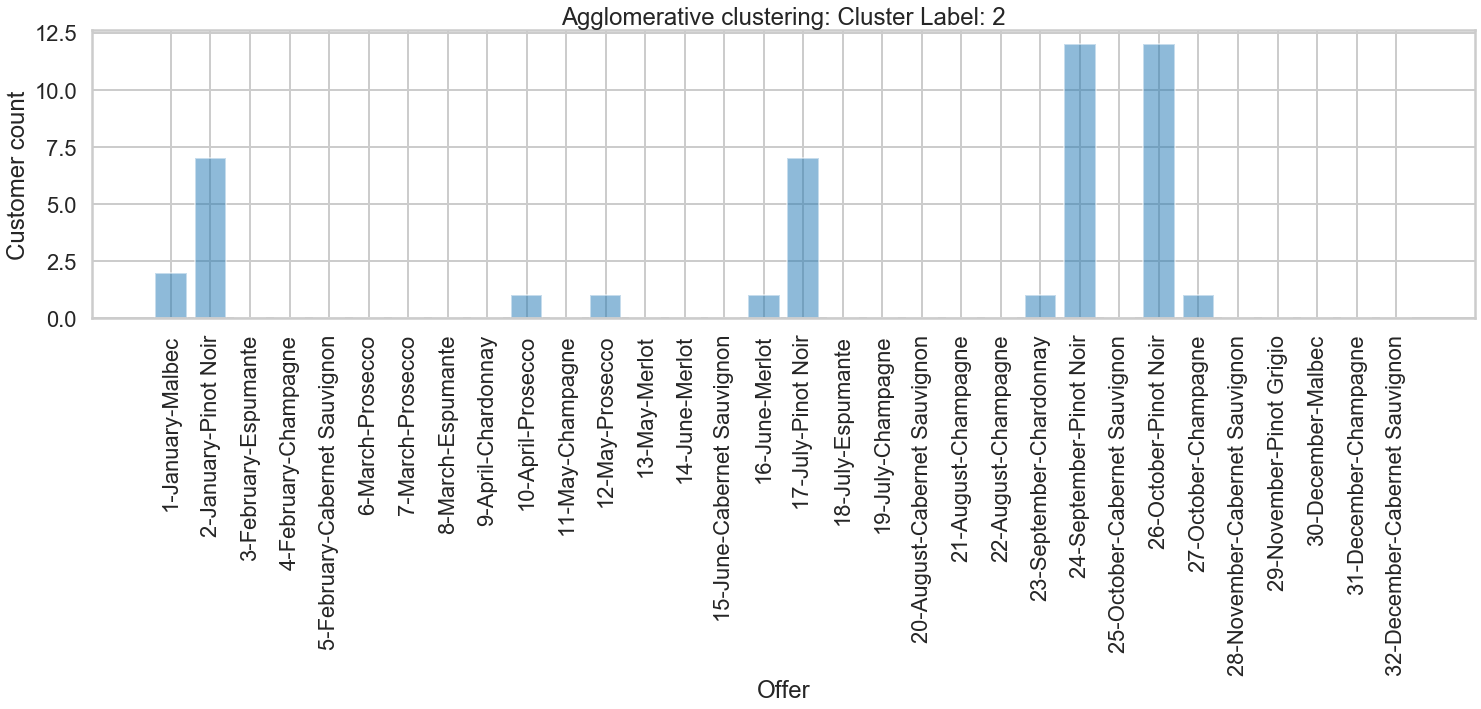

cluster label =  3
                               n   ct
5        (n, 6, March, Prosecco)  6.0
21    (n, 22, August, Champagne)  6.0
26   (n, 27, October, Champagne)  5.0
3    (n, 4, February, Champagne)  4.0
2    (n, 3, February, Espumante)  3.0
6        (n, 7, March, Prosecco)  3.0
18      (n, 19, July, Champagne)  3.0
7       (n, 8, March, Espumante)  2.0
20    (n, 21, August, Champagne)  2.0
30  (n, 31, December, Champagne)  2.0


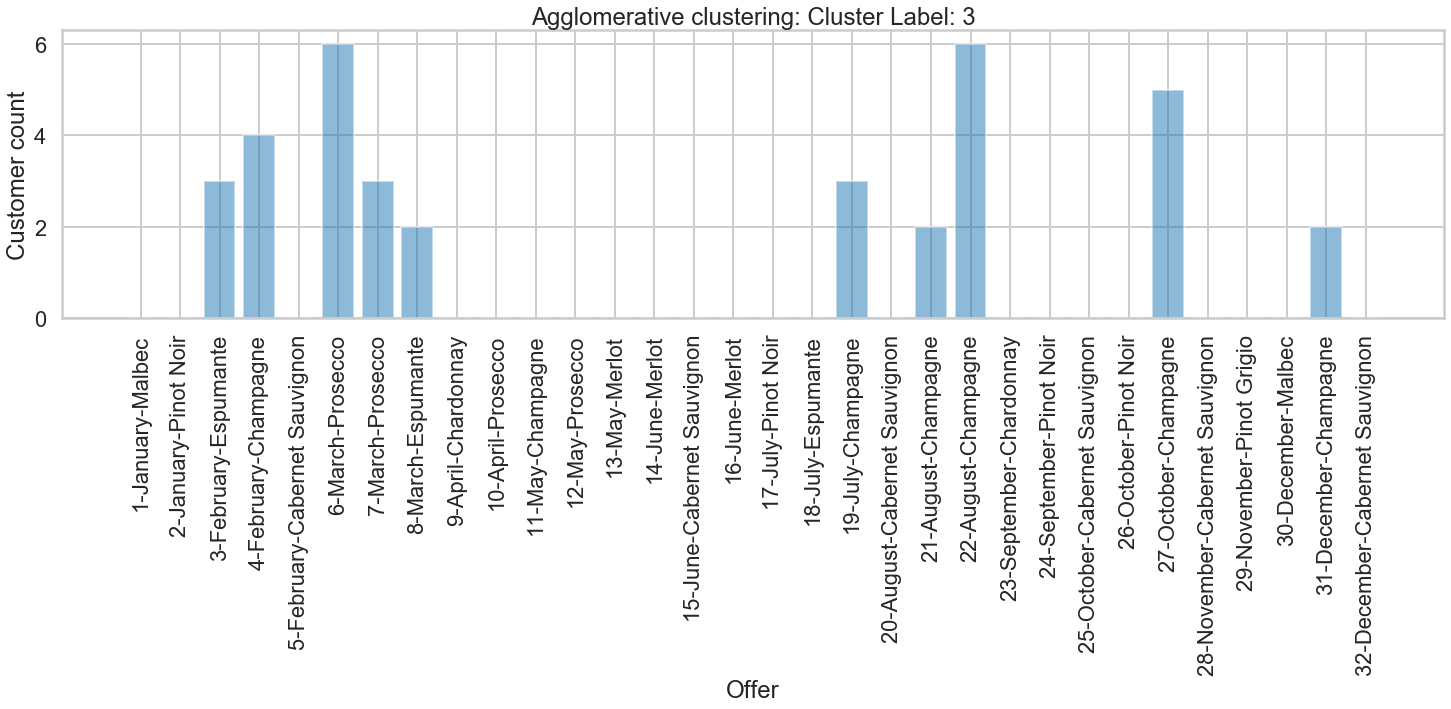

cluster label =  4
                                        n    ct
29              (n, 30, December, Malbec)  17.0
7                (n, 8, March, Espumante)  16.0
28        (n, 29, November, Pinot Grigio)  16.0
6                 (n, 7, March, Prosecco)  14.0
17               (n, 18, July, Espumante)  13.0
12                   (n, 13, May, Merlot)   6.0
5                 (n, 6, March, Prosecco)   1.0
9                (n, 10, April, Prosecco)   1.0
10                (n, 11, May, Champagne)   1.0
11                 (n, 12, May, Prosecco)   1.0
20             (n, 21, August, Champagne)   1.0
26            (n, 27, October, Champagne)   1.0
27  (n, 28, November, Cabernet Sauvignon)   1.0


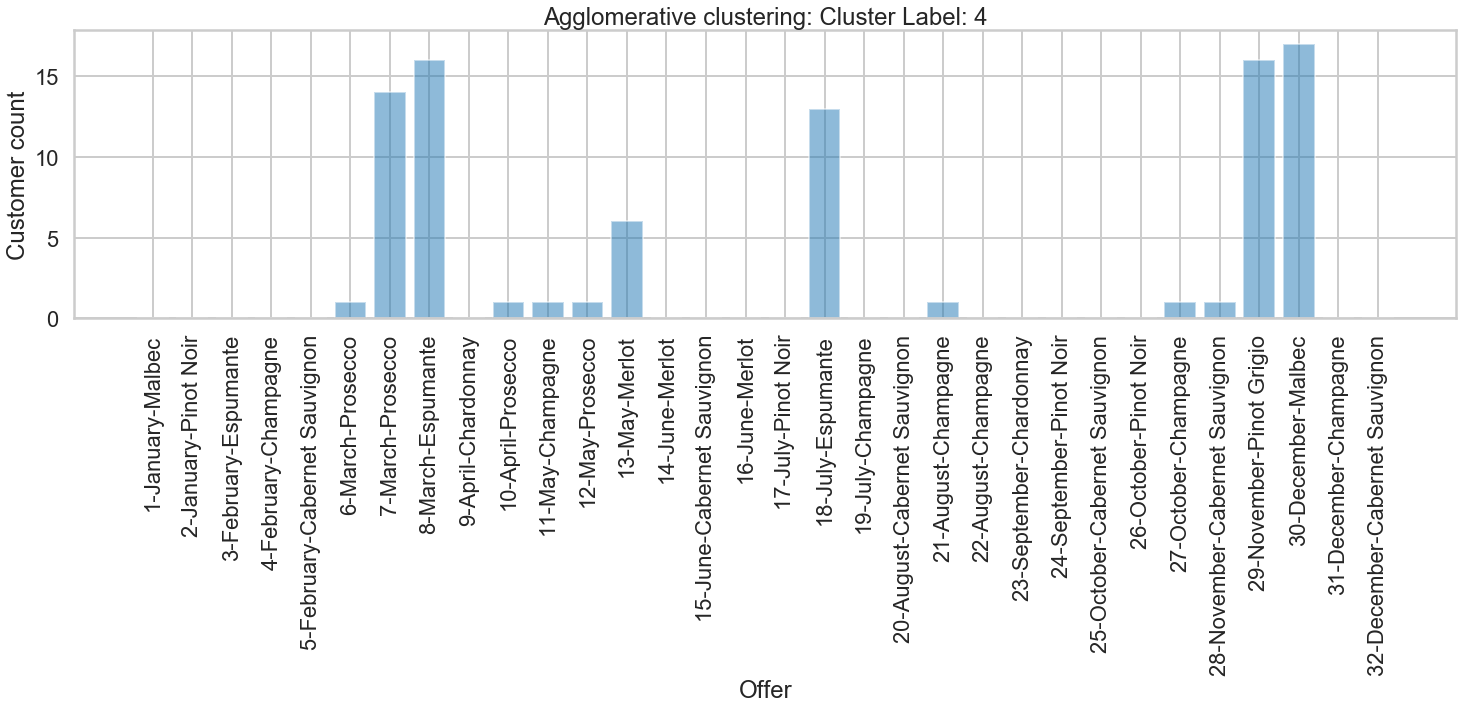

In [81]:
list_aggc_clusters =np.sort(combined_data2['Agglo_cluster'].unique())

for cluster in list_aggc_clusters:
    exclude_cols = combined_data2.columns[:9].tolist()
    sum_cols = combined_data2.columns[9:].tolist()
    sum_list = combined_data2[combined_data2.Agglo_cluster==cluster].drop(exclude_cols,axis=1).sum().tolist()
    sum_df = pd.DataFrame({'n':sum_cols,'ct':sum_list})
    print("cluster label = ",cluster)
    print(sum_df[sum_df.ct != 0].sort_values(by='ct',ascending=False))
    fig= plt.figure(figsize=(24,5))
    axes= fig.add_axes([0.1,0.1,0.8,0.8])
    n_list = []
    offer_list = []
    for n in sum_cols:
        n_list.append(n[1])
        offer_list.append(str(n[1])+"-"+n[2]+"-"+n[3])
    axes.bar(offer_list, sum_df['ct'], align='center',alpha=0.5)
    plt_title = "Agglomerative clustering: Cluster Label: "+str(cluster)
    plt.title(plt_title)
    plt.xlabel('Offer')
    plt.ylabel('Customer count')
    plt.xticks(rotation=90)
    plt.show()

cluster label =  0


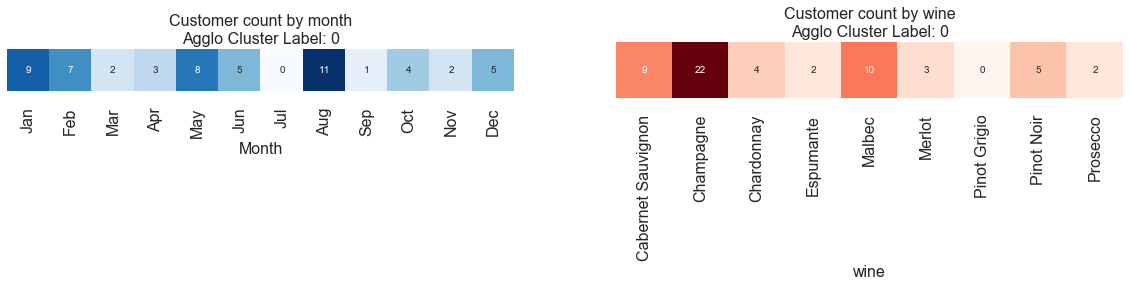

<Figure size 720x216 with 0 Axes>

<Figure size 720x216 with 0 Axes>

cluster label =  1


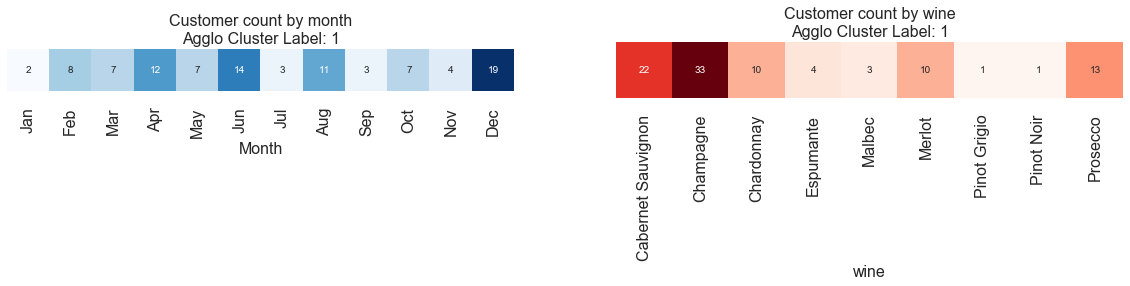

<Figure size 720x216 with 0 Axes>

<Figure size 720x216 with 0 Axes>

cluster label =  2


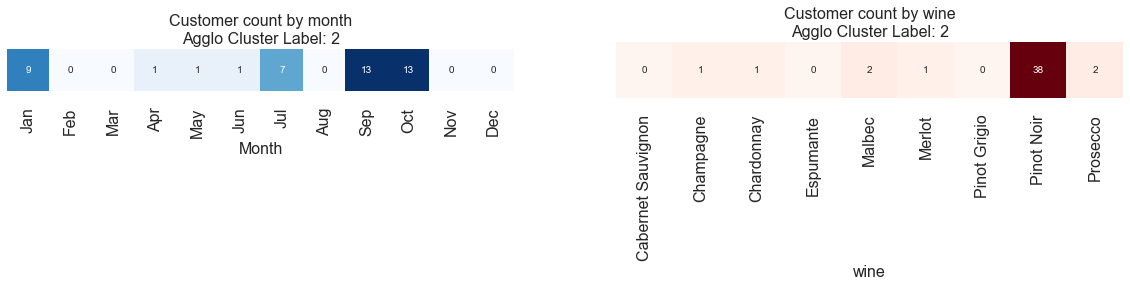

<Figure size 720x216 with 0 Axes>

<Figure size 720x216 with 0 Axes>

cluster label =  3


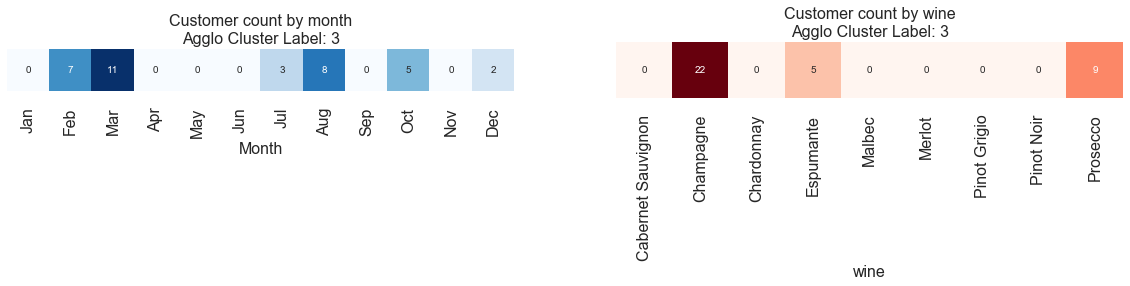

<Figure size 720x216 with 0 Axes>

<Figure size 720x216 with 0 Axes>

cluster label =  4


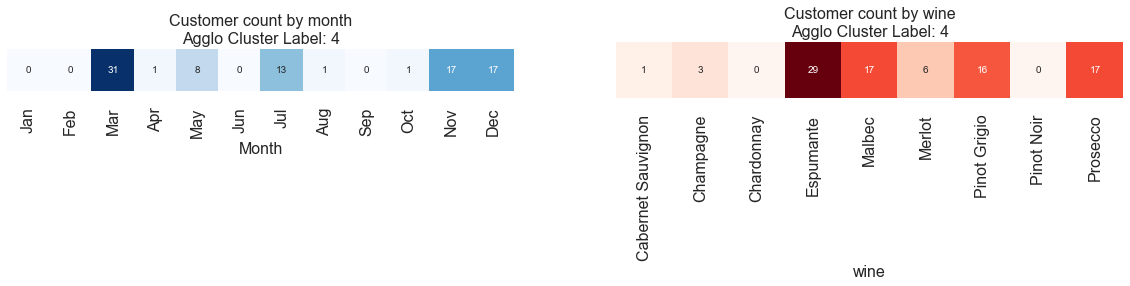

<Figure size 720x216 with 0 Axes>

<Figure size 720x216 with 0 Axes>

In [84]:
for cluster in list_aggc_clusters:
    exclude_cols = combined_data2.columns[:9].tolist()
    sum_cols = combined_data2.columns[9:].tolist()
    sum_list = combined_data2[combined_data2.Agglo_cluster==cluster].drop(exclude_cols,axis=1).sum().tolist()
    sum_df = pd.DataFrame({'n':sum_cols,'ct':sum_list})
    print("cluster label = ",cluster)
    #print(sum_df[sum_df.ct != 0].sort_values(by='ct',ascending=False))

    # get lists of months and wines from sum_df
    list_month =[]
    list_wine = []
    for col in sum_cols:
        list_month.append(col[2])
        list_wine.append(col[3])
    sum_df['month'] = list_month
    sum_df['wine'] = list_wine
    sum_df['month'] = pd.to_datetime(sum_df.month, format='%B', errors='coerce').dt.month

    # to examine purchasing customers in each month: groupby month, count customers
    combined_month_ct = sum_df.groupby('month').sum()
    #print(combined_month_ct)
    
    # to examine purchasing customers by wine type; groupby wine, count customers
    combined_wine_ct = sum_df.drop(['month'],axis=1).groupby('wine').sum()
    #print(combined_wine_ct)
    
    # print 1D heatmap for each
    f = plt.figure(figsize=(20,3))

    ax1 = f.add_subplot(121)
    ax2 = f.add_subplot(122)

    plt_title1 = "Customer count by month\nAgglo Cluster Label: "+str(cluster)
    x_axlabels1 = []
    for n in combined_month_ct.index:
        x_axlabels1.append(calendar.month_abbr[n])
    g1 = plt.figure(figsize=(10,3))
    g1 = sns.heatmap([combined_month_ct['ct']], cmap='Blues', annot=True, yticklabels=False, cbar=False, ax=ax1, square=True)
    g1.set_title(plt_title1,fontsize=16)
    g1.set_xlabel('Month',fontsize=16)
    g1.set_xticklabels(x_axlabels1, fontsize=16, rotation=90)

    plt_title2 = "Customer count by wine\nAgglo Cluster Label: "+str(cluster)
    x_axlabels2 = np.array(combined_wine_ct.index)
    g2 = plt.figure(figsize=(10,3))
    g2 = sns.heatmap([combined_wine_ct['ct']], cmap='Reds', annot=True, yticklabels=False, cbar=False, ax=ax2, square=True)
    g2.set_title(plt_title2,fontsize=16)
    g2.set_xlabel('wine',fontsize=16)
    g2.set_xticklabels(x_axlabels2, fontsize=16, rotation=90)

    plt.show()

cluster label =  -1
                                        n    ct
21             (n, 22, August, Champagne)  21.0
30           (n, 31, December, Champagne)  14.0
10                (n, 11, May, Champagne)  13.0
5                 (n, 6, March, Prosecco)  12.0
3             (n, 4, February, Champagne)  12.0
0                 (n, 1, January, Malbec)  10.0
13                  (n, 14, June, Merlot)   9.0
26            (n, 27, October, Champagne)   7.0
9                (n, 10, April, Prosecco)   7.0
6                 (n, 7, March, Prosecco)   6.0
29              (n, 30, December, Malbec)   6.0
8               (n, 9, April, Chardonnay)   6.0
19    (n, 20, August, Cabernet Sauvignon)   6.0
2             (n, 3, February, Espumante)   6.0
27  (n, 28, November, Cabernet Sauvignon)   6.0
14      (n, 15, June, Cabernet Sauvignon)   6.0
24   (n, 25, October, Cabernet Sauvignon)   6.0
25           (n, 26, October, Pinot Noir)   5.0
15                  (n, 16, June, Merlot)   5.0
1             (n, 2,

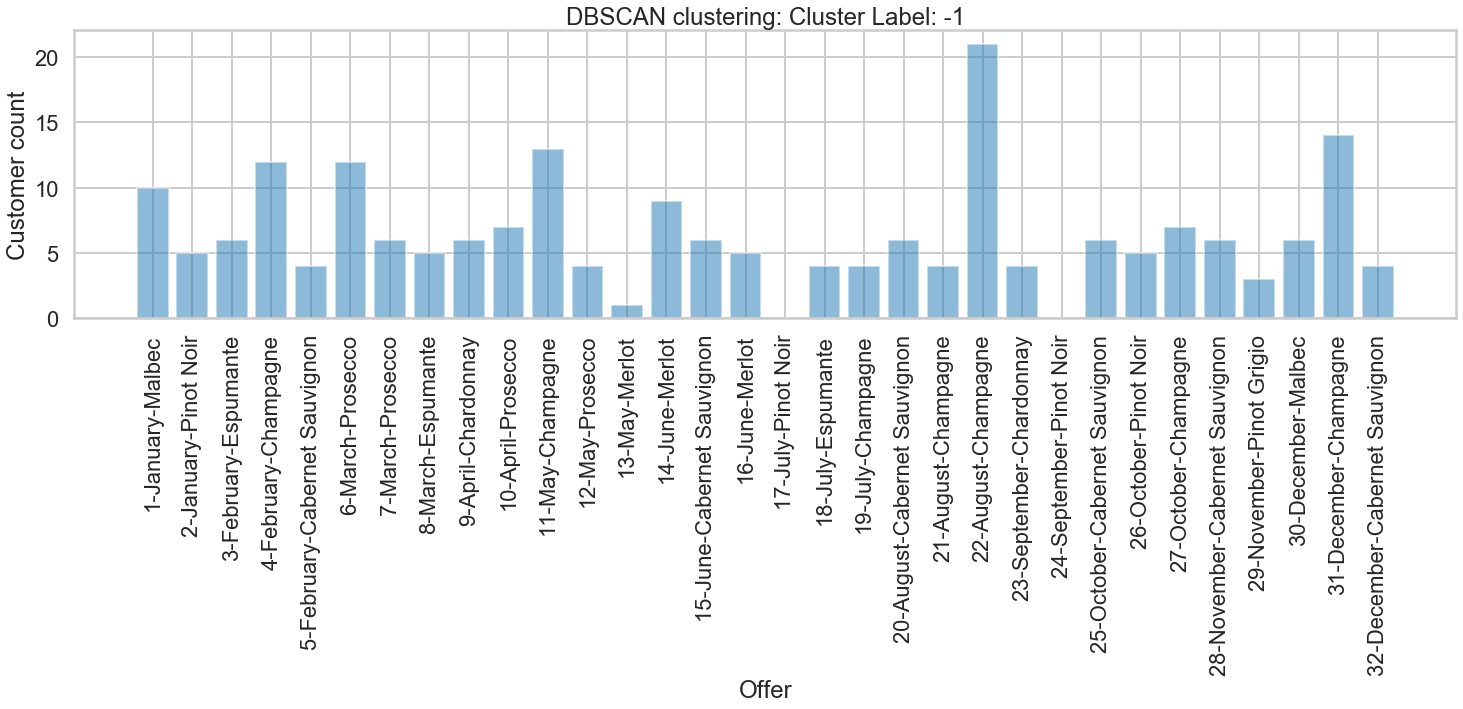

cluster label =  0
                                  n    ct
28  (n, 29, November, Pinot Grigio)  14.0
29        (n, 30, December, Malbec)  14.0
6           (n, 7, March, Prosecco)  12.0
7          (n, 8, March, Espumante)  12.0
17         (n, 18, July, Espumante)   7.0
12             (n, 13, May, Merlot)   2.0
11           (n, 12, May, Prosecco)   1.0
26      (n, 27, October, Champagne)   1.0


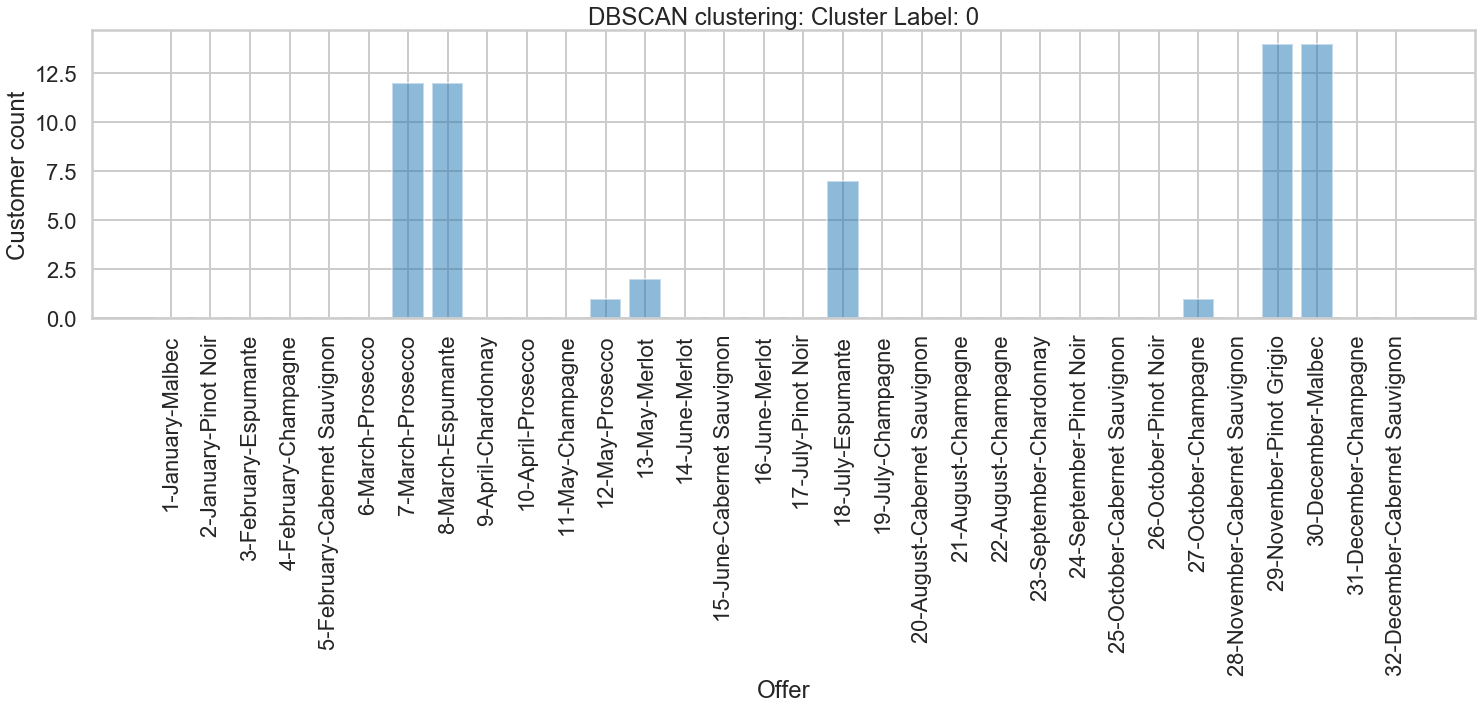

cluster label =  1
                                 n    ct
23  (n, 24, September, Pinot Noir)  12.0
25    (n, 26, October, Pinot Noir)  10.0
16       (n, 17, July, Pinot Noir)   7.0
1      (n, 2, January, Pinot Noir)   5.0


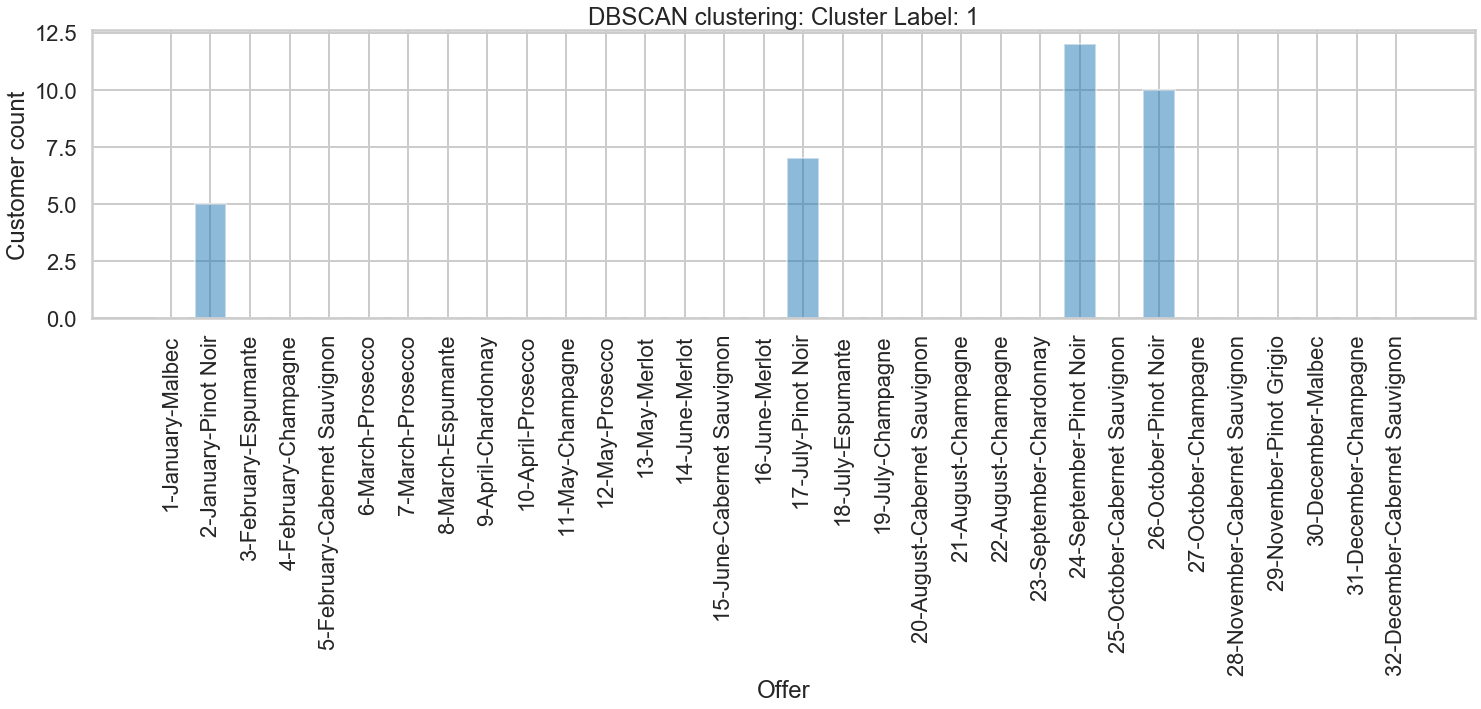

cluster label =  2
                                 n   ct
8        (n, 9, April, Chardonnay)  4.0
30    (n, 31, December, Champagne)  3.0
18        (n, 19, July, Champagne)  1.0
22  (n, 23, September, Chardonnay)  1.0
26     (n, 27, October, Champagne)  1.0


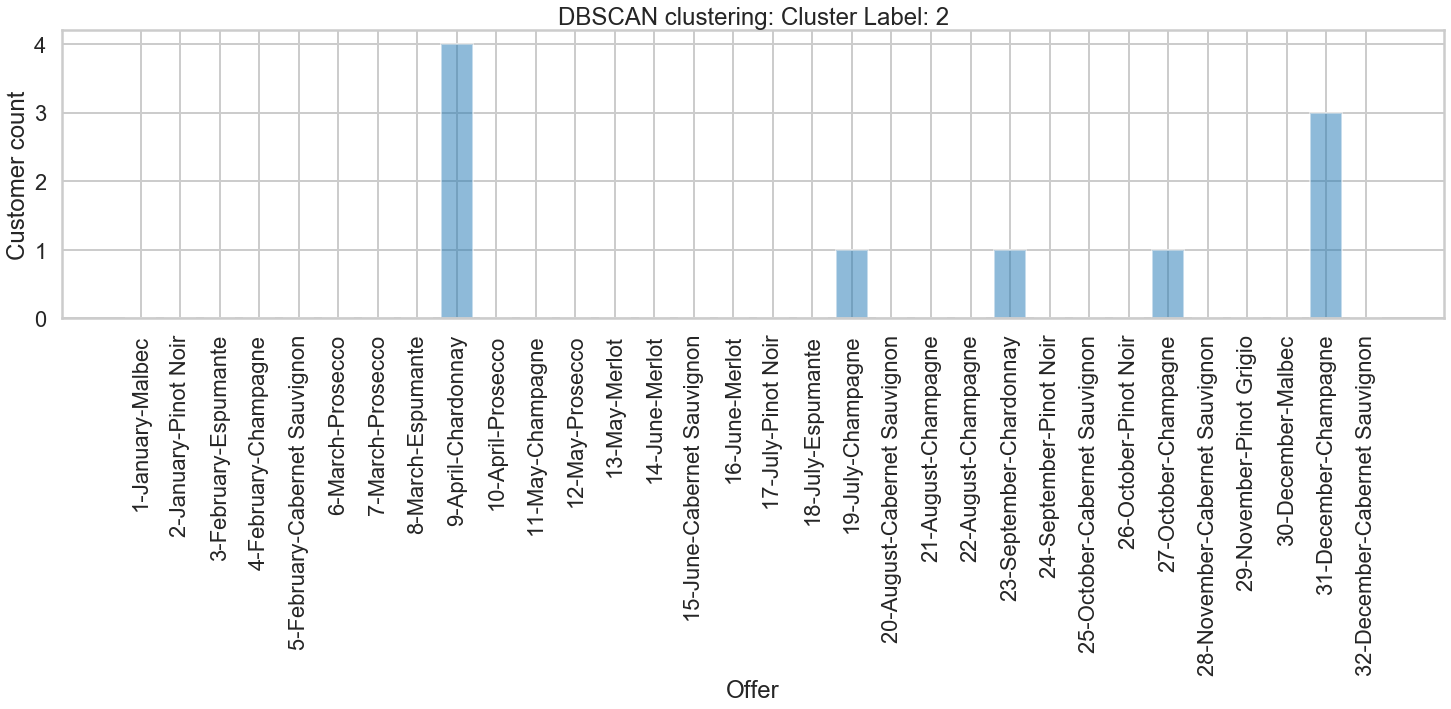

cluster label =  3
                            n   ct
7    (n, 8, March, Espumante)  3.0
12       (n, 13, May, Merlot)  3.0
17   (n, 18, July, Espumante)  3.0
29  (n, 30, December, Malbec)  2.0
6     (n, 7, March, Prosecco)  1.0


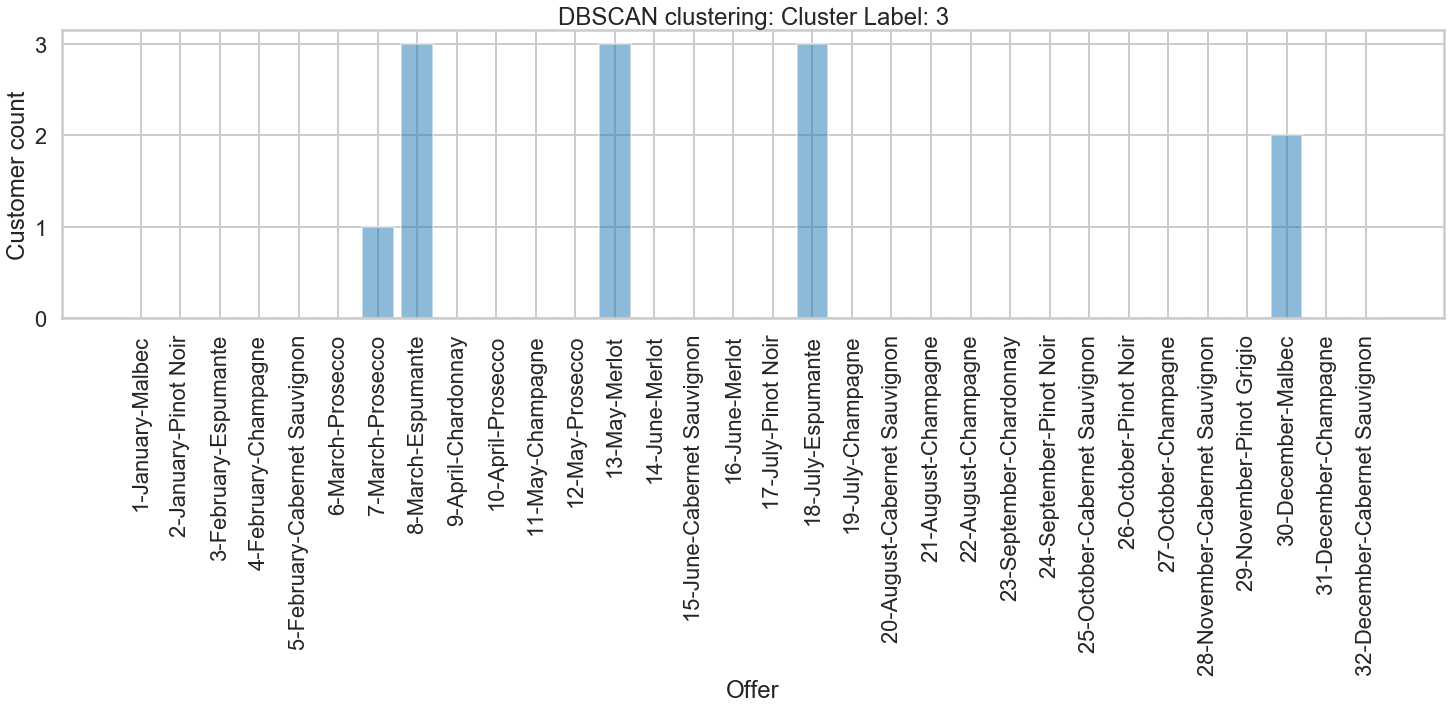

In [87]:
list_db_clusters =np.sort(combined_data2['DBSCAN_cluster'].unique())

for cluster in list_db_clusters:
    exclude_cols = combined_data2.columns[:9].tolist()
    sum_cols = combined_data2.columns[9:].tolist()
    sum_list = combined_data2[combined_data2.DBSCAN_cluster==cluster].drop(exclude_cols,axis=1).sum().tolist()
    sum_df = pd.DataFrame({'n':sum_cols,'ct':sum_list})
    print("cluster label = ",cluster)
    print(sum_df[sum_df.ct != 0].sort_values(by='ct',ascending=False))
    fig= plt.figure(figsize=(24,5))
    axes= fig.add_axes([0.1,0.1,0.8,0.8])
    n_list = []
    offer_list = []
    for n in sum_cols:
        n_list.append(n[1])
        offer_list.append(str(n[1])+"-"+n[2]+"-"+n[3])
    axes.bar(offer_list, sum_df['ct'], align='center',alpha=0.5)
    plt_title = "DBSCAN clustering: Cluster Label: "+str(cluster)
    plt.title(plt_title)
    plt.xlabel('Offer')
    plt.ylabel('Customer count')
    plt.xticks(rotation=90)
    plt.show()

cluster label =  -1


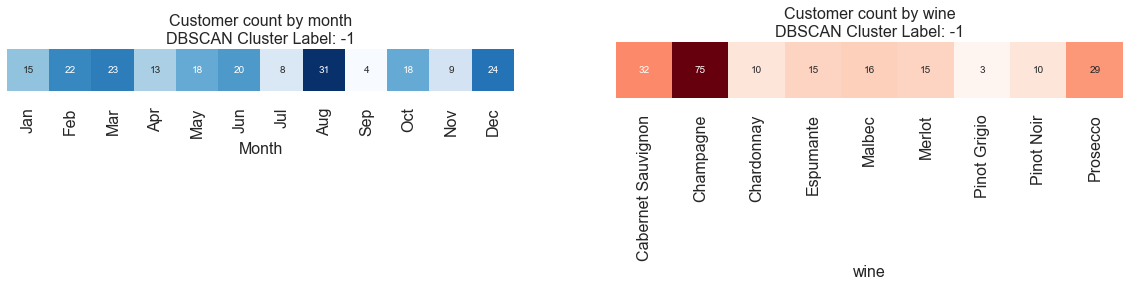

<Figure size 720x216 with 0 Axes>

<Figure size 720x216 with 0 Axes>

cluster label =  0


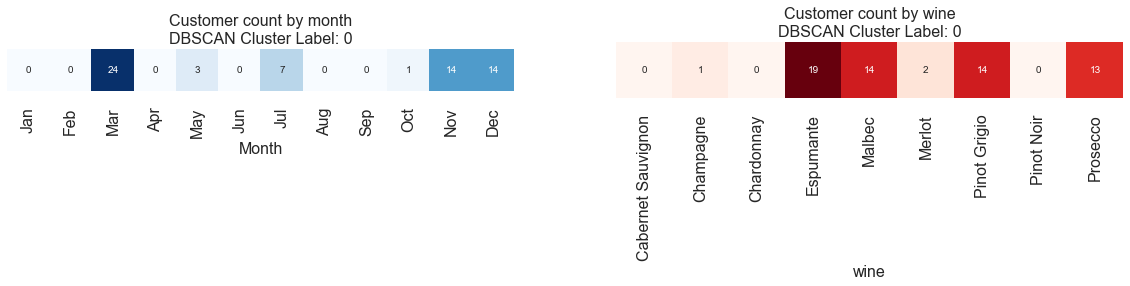

<Figure size 720x216 with 0 Axes>

<Figure size 720x216 with 0 Axes>

cluster label =  1


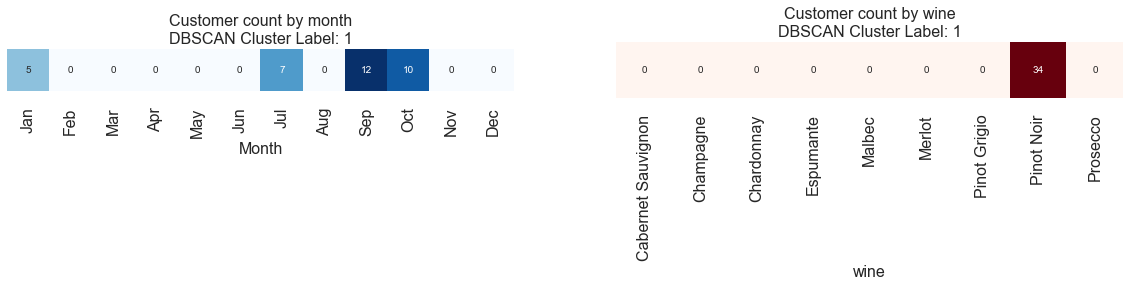

<Figure size 720x216 with 0 Axes>

<Figure size 720x216 with 0 Axes>

cluster label =  2


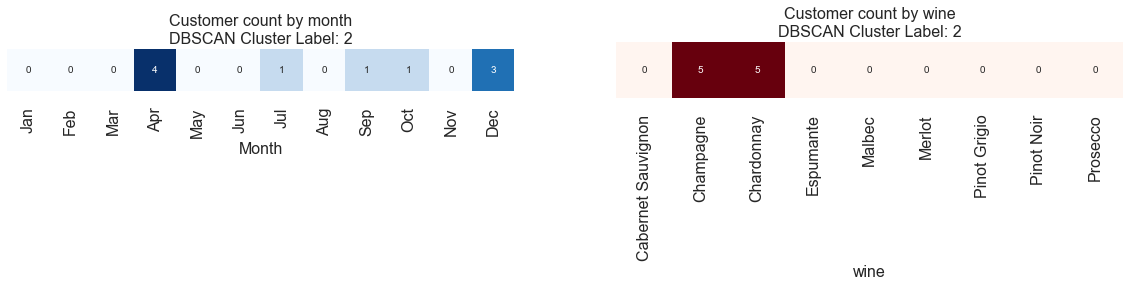

<Figure size 720x216 with 0 Axes>

<Figure size 720x216 with 0 Axes>

cluster label =  3


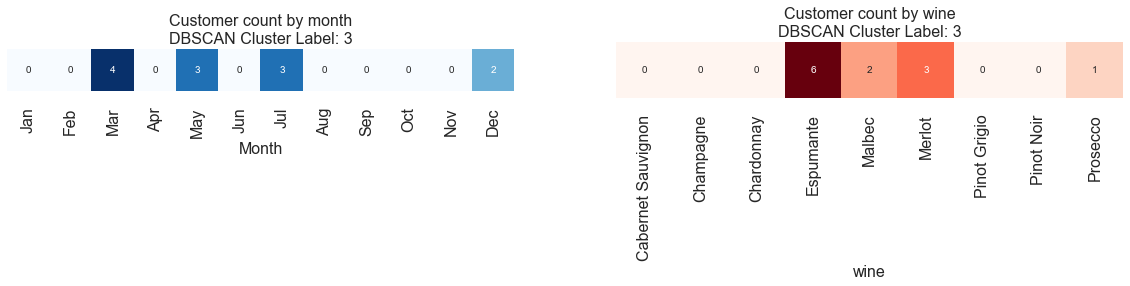

<Figure size 720x216 with 0 Axes>

<Figure size 720x216 with 0 Axes>

In [89]:
for cluster in list_db_clusters:
    exclude_cols = combined_data2.columns[:9].tolist()
    sum_cols = combined_data2.columns[9:].tolist()
    sum_list = combined_data2[combined_data2.DBSCAN_cluster==cluster].drop(exclude_cols,axis=1).sum().tolist()
    sum_df = pd.DataFrame({'n':sum_cols,'ct':sum_list})
    print("cluster label = ",cluster)
    #print(sum_df[sum_df.ct != 0].sort_values(by='ct',ascending=False))

    # get lists of months and wines from sum_df
    list_month =[]
    list_wine = []
    for col in sum_cols:
        list_month.append(col[2])
        list_wine.append(col[3])
    sum_df['month'] = list_month
    sum_df['wine'] = list_wine
    sum_df['month'] = pd.to_datetime(sum_df.month, format='%B', errors='coerce').dt.month

    # to examine purchasing customers in each month: groupby month, count customers
    combined_month_ct = sum_df.groupby('month').sum()
    #print(combined_month_ct)
    
    # to examine purchasing customers by wine type; groupby wine, count customers
    combined_wine_ct = sum_df.drop(['month'],axis=1).groupby('wine').sum()
    #print(combined_wine_ct)
    
    # print 1D heatmap for each
    f = plt.figure(figsize=(20,3))

    ax1 = f.add_subplot(121)
    ax2 = f.add_subplot(122)

    plt_title1 = "Customer count by month\nDBSCAN Cluster Label: "+str(cluster)
    x_axlabels1 = []
    for n in combined_month_ct.index:
        x_axlabels1.append(calendar.month_abbr[n])
    g1 = plt.figure(figsize=(10,3))
    g1 = sns.heatmap([combined_month_ct['ct']], cmap='Blues', annot=True, yticklabels=False, cbar=False, ax=ax1, square=True)
    g1.set_title(plt_title1,fontsize=16)
    g1.set_xlabel('Month',fontsize=16)
    g1.set_xticklabels(x_axlabels1, fontsize=16, rotation=90)

    plt_title2 = "Customer count by wine\nDBSCAN Cluster Label: "+str(cluster)
    x_axlabels2 = np.array(combined_wine_ct.index)
    g2 = plt.figure(figsize=(10,3))
    g2 = sns.heatmap([combined_wine_ct['ct']], cmap='Reds', annot=True, yticklabels=False, cbar=False, ax=ax2, square=True)
    g2.set_title(plt_title2,fontsize=16)
    g2.set_xlabel('wine',fontsize=16)
    g2.set_xticklabels(x_axlabels2, fontsize=16, rotation=90)

    plt.show()

Among the tested models, the DBSCAN method appears to perform best based on the above analysis. Each cluster can be characterized by the wine type. Cluster 1 by pinot noir, cluster 2 by champagne and chardonay, and cluster 3 mainly by Espumante. For clusters -1 and 0, both include many wine types. Cluster -1 include customers that buy all kinds of wines over the year. Cluster 0 include customers that buy about half of the wines that were offered and the purchases took place either in march and the end of year. 

Comparing the results, some clusters from different models do share the same features. For example, some recurring clusters shared by different models include 1) a group of customers who bought only pinot noir, 2) customers who bought champagne, and 3) customers who bought any wines that were offered throughout the year. 